# Data Cleaning and Transformation
## Initial Input

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score, completeness_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import linregress

In [2]:
data = pd.read_csv("Manhattan12.csv", header = 4)
data.shape

(27395, 21)

In [3]:
pd.set_option('display.width', 1080)
pd.set_option('display.max_columns', None)

The shape of the data is (27399, 21) as shown above. This means that there is initially 27399 rows and 21 columns of data.

## Column Renaming

In [4]:
data.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APART\nMENT\nNUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE\nPRICE', 'SALE DATE'], dtype='object')

Columns incorrectly named: 'APART\nMENT\nNUMBER', 'SALE\nPRICE'

In [5]:
data = data.rename(columns = {"APART\nMENT\nNUMBER":"APARTMENT NUMBER", "SALE\nPRICE":"SALE PRICE"})

In [6]:
data.dtypes

BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                 object
COMMERCIAL UNITS                   int64
TOTAL UNITS                       object
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

Column names are now correct!

## Create List of Categoricals and Numerics

In [7]:
numericals = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS']
categoricals = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'EASE-MENT',
                'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER', 'TAX CLASS AT TIME OF SALE', 
                'BUILDING CLASS AT TIME OF SALE', 'BLOCK', 'LOT', 'ADDRESS', 'ZIP CODE', 'YEAR BUILT', 'SALE DATE']

Two lists have been made which contains all the column names. Each column is either in the numerical or categorical list. They are split as followed:

In [8]:
print("Numericals:", str(numericals), "\nCategoricals:", str(categoricals))

Numericals: ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS'] 
Categoricals: ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'BLOCK', 'LOT', 'ADDRESS', 'ZIP CODE', 'YEAR BUILT', 'SALE DATE']


## Fixing Numerical Values

In [9]:
for i in numericals:
    if data[i].dtype not in ["int64"]:
        data[i] = data[i].apply(lambda a: a.replace("$", "").replace(",","")).astype("int64")

All values that should be numerical but aren't have now been converted to "int64"

## Converting Sale Date to datetime

In [10]:
data['SALE DATE'] = pd.to_datetime(data['SALE DATE'], dayfirst=True)

"SALE DATE" is now in datetime

## Fixing Categoricals

In [11]:
for i in categoricals:
    data[i] = data[i].replace(to_replace = r'[\s]+', value = "", regex = True)
    data[i] = data[i].replace(to_replace = "",  value = np.nan)

## Replacing Zeros

In [12]:
nan_features = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE']
for i in nan_features:
    data[i] = data[i].apply(lambda x: np.nan if x == 0 else x)

# Summary of Missing Values

In [13]:
data.isna().sum()

BOROUGH                               0
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            3454
TAX CLASS AT PRESENT                143
BLOCK                                 0
LOT                                   0
EASE-MENT                         27395
BUILDING CLASS AT PRESENT           143
ADDRESS                               0
APARTMENT NUMBER                  14570
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  22906
GROSS SQUARE FEET                 23069
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                         7593
SALE DATE                             0
dtype: int64

The above list shows how many values are missing in each column

## Drop Columns

In [14]:
print("size before:", data.shape)
data.drop(columns = ["BOROUGH", "EASE-MENT", "APARTMENT NUMBER"], inplace = True)
print("size after:", data.shape)

size before: (27395, 21)
size after: (27395, 18)


## Drop Duplicates

In [15]:
print("size before:", data.shape)
data.drop_duplicates(inplace = True)
print("size after:", data.shape)

size before: (27395, 18)
size after: (25790, 18)


## Drop Rows with NaN

In [16]:
og_data = pd.DataFrame(data=data)

print("size before:", data.shape)

# This code does agressive cleaning and leaves us with only 400 rows: data['SALE PRICE'].dropna(inplace = True)
# Since units can be 0, we only drop rows in other numerical columns which are null
data = data.dropna(subset=['SALE PRICE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT'])

print("size after:", data.shape)

size before: (25790, 18)
size after: (2232, 18)


# Outliers

For this data, an outlier will be defined as 2 standard deviations from the mean. Theoretically 95% of all values should be within 2 STD from the mean in any distribution.

In [17]:
data.describe()

BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE
count  2232.000000  2232.000000   2232.000000        2232.000000       2232.000000  2232.000000       2232.000000        2232.000000  2232.000000                2232.000000  2.232000e+03
mean   1214.444444    48.492384  10025.397401           9.758961          2.083333    11.836470       5963.900538       54965.280466  1944.948477                   2.829749  1.008254e+07
std     533.654143    84.960317     28.316174          27.446736          6.322801    28.012158       8793.566208       74804.703895    45.781452                   1.171395  4.246882e+07
min      11.000000     1.000000  10001.000000           0.000000          0.000000     0.000000        469.000000         999.000000  1800.000000                   1.000000  1.000000e+00
25%    1009.000000    26.000000  10019.000000           0.000000          0.000000     2.000000       2018.000000        5662.250000  1910.000000                   2.000000  8.832650e+04
50%    1009.000000    37.000000  10019.000000           1.000000          2.000000     3.000000       4600.000000       17077.500000  1920.000000                   2.000000  2.200000e+06
75%    1661.250000    45.000000  10028.000000          10.000000          2.000000    11.000000       7532.000000      112850.000000  2007.000000                   4.000000  6.256250e+06
max    2246.000000  1502.000000  10463.000000         538.000000        150.000000   550.000000     213650.000000      940000.000000  2013.000000                   4.000000  1.100000e+09

This table shows a description of number values (not numerical) in the data and shows some stastics. Initially we can say that BLOCK, LOT, ZIP CODE and TAX CLASS AT TIME OF SALE, cant contain outliers since they are categorical. For the rest we can check if the max and min values are within two standard deviations of the mean. 

<table>
  <tr>
    <th>Column</th>
    <th>Accepted Range</th>
    <th>Data Range</th>
    <th>Contains Outliers</th>
  </tr>  
  <tr>
    <th>COMMERIAL UNITS</th>
    <th>[-4.419181, 8.755351]</th>
    <th>[1, 63]</th>
    <th>yes</th>
  </tr>
  <tr>
    <th>LAND SQUARE FEET</th>
    <th>[-11868.757473, 20279.297899]</th>
    <th>[469, 150322]</th>
    <th>yes</th>
  </tr>
  <tr>
    <th>GROSS SQUARE FEET</th>
    <th>[-72990.574098, 116091.701758]</th>
    <th>[1650, 509090]</th>
    <th>yes</th>
  </tr>  
  <tr>
    <th>RESIDENTIAL UNITS</th>
    <th>[-72.89177, 113.644962]</th>
    <th>[1, 538]</th>
    <th>yes</th>
  </tr>
   <tr>
    <th>TOTAL UNITS</th>
    <th>[-72.354517, 117.388559]</th>
    <th>[1, 550]</th>
    <th>yes</th>
  </tr>
  <tr>
    <th>SALE PRICE</th>
    <th>[-4.7169550e7, 6.7969650e7]</th>
    <th>[1, 3.8e8]</th>
    <th>yes</th>
  </tr>
</table>

This means all of the columns in the table above should have a check to remove outliers

In [18]:
def identify_outlier(df, features):
    temp = np.zeros(df.shape[0])
    desc = df.describe()
    for i in features:
        iqr = desc[i]["75%"] - desc[i]["25%"]
        for j, x in enumerate(df[i]):
            if x < (desc[i]["25%"] - 1.5*(iqr)) or x > (desc[i]["75%"] + 1.5*(iqr)):
                temp[j] = 1
    df['outlier'] = temp
    return df

data = identify_outlier(data, ["LAND SQUARE FEET","GROSS SQUARE FEET","SALE PRICE"])
print("number of outliers identified:", data['outlier'].sum())
data = data[data.outlier == 0]
data.drop('outlier', axis = 1, inplace = True)


number of outliers identified: 253.0


In [19]:
def treat_outlier_by_zscore(df, features):
    temp = np.zeros(df.shape[0])
    desc = df.describe()
    for i in features:
        for j, x in enumerate(df[i]):
            if x < (desc[i]["mean"] - 3*desc[i]["std"]) or x > (desc[i]["mean"] + 3*desc[i]["std"]):
                temp[j] = 1
    df['outlier'] = temp
    return df

# Summary

In [20]:
data.shape

(1979, 18)

The shape of the resulting data is (375, 18). This means there are 18 different columns and 375 different entries and is the end sample size

# Normalisation and lnprice

In [21]:
data["lnprice"] = np.log(data["SALE PRICE"])
data.describe()

BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE      lnprice
count  1979.000000  1979.000000   1979.000000        1979.000000       1979.000000  1979.000000       1979.000000        1979.000000  1979.000000                1979.000000  1.979000e+03  1979.000000
mean   1233.813542    46.849924  10025.621526           7.341587          1.475998     8.812532       4755.643759       47914.963618  1946.732693                   2.791309  2.932270e+06    13.327149
std     529.164772    69.927821     28.955298          13.243903          2.989500    13.276355       3020.223234       49806.460731    47.073687                   1.176706  3.531781e+06     2.630762
min      11.000000     1.000000  10001.000000           0.000000          0.000000     0.000000        469.000000         999.000000  1800.000000                   1.000000  1.000000e+00     0.000000
25%    1009.000000    28.000000  10019.000000           0.000000          0.000000     2.000000       1999.000000        5235.500000  1910.000000                   2.000000  8.139500e+04    11.307069
50%    1009.000000    37.000000  10019.000000           1.000000          2.000000     2.000000       3850.000000       13828.000000  1920.000000                   2.000000  1.400000e+06    14.151983
75%    1698.000000    44.000000  10029.000000           9.000000          2.000000    10.000000       7532.000000      112850.000000  2007.000000                   4.000000  4.800000e+06    15.384126
max    2246.000000  1502.000000  10463.000000         180.000000         60.000000   181.000000      15800.000000      155975.000000  2013.000000                   4.000000  1.550000e+07    16.556351

In [22]:
def normalise(df, columns):
    desc = df.describe()
    for i in columns:
        print("Normalising column: "+i)
        temp = np.zeros(df.shape[0])
        for j, x in enumerate(df[i]):
            temp[j] = (x-desc[i]["min"])/(desc[i]["max"]-desc[i]["min"])
        df[i] = temp
    return df

In [23]:
data = normalise(data, ["COMMERCIAL UNITS","LAND SQUARE FEET","GROSS SQUARE FEET","RESIDENTIAL UNITS","SALE PRICE", "TOTAL UNITS", "lnprice"])
data.describe()

Normalising column: COMMERCIAL UNITS
Normalising column: LAND SQUARE FEET
Normalising column: GROSS SQUARE FEET
Normalising column: RESIDENTIAL UNITS
Normalising column: SALE PRICE
Normalising column: TOTAL UNITS
Normalising column: lnprice


BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE   SALE PRICE      lnprice
count  1979.000000  1979.000000   1979.000000        1979.000000       1979.000000  1979.000000       1979.000000        1979.000000  1979.000000                1979.000000  1979.000000  1979.000000
mean   1233.813542    46.849924  10025.621526           0.040787          0.024600     0.048688          0.279606           0.302731  1946.732693                   2.791309     0.189179     0.804957
std     529.164772    69.927821     28.955298           0.073577          0.049825     0.073350          0.197001           0.321382    47.073687                   1.176706     0.227857     0.158897
min      11.000000     1.000000  10001.000000           0.000000          0.000000     0.000000          0.000000           0.000000  1800.000000                   1.000000     0.000000     0.000000
25%    1009.000000    28.000000  10019.000000           0.000000          0.000000     0.011050          0.099798           0.027336  1910.000000                   2.000000     0.005251     0.682945
50%    1009.000000    37.000000  10019.000000           0.005556          0.033333     0.011050          0.220534           0.082781  1920.000000                   2.000000     0.090323     0.854777
75%    1698.000000    44.000000  10029.000000           0.050000          0.033333     0.055249          0.460701           0.721731  2007.000000                   4.000000     0.309677     0.929198
max    2246.000000  1502.000000  10463.000000           1.000000          1.000000     1.000000          1.000000           1.000000  2013.000000                   4.000000     1.000000     1.000000



# Data Exploration



### Visualise the prices across specific neighborhoods
Scatter plots do not work with categorical variables, in this case for specific neighbourhoods. Therefore, to get a real depiction of categorical variable of a neighbourhood affecting price (numerical variable) we can use boxplots. 

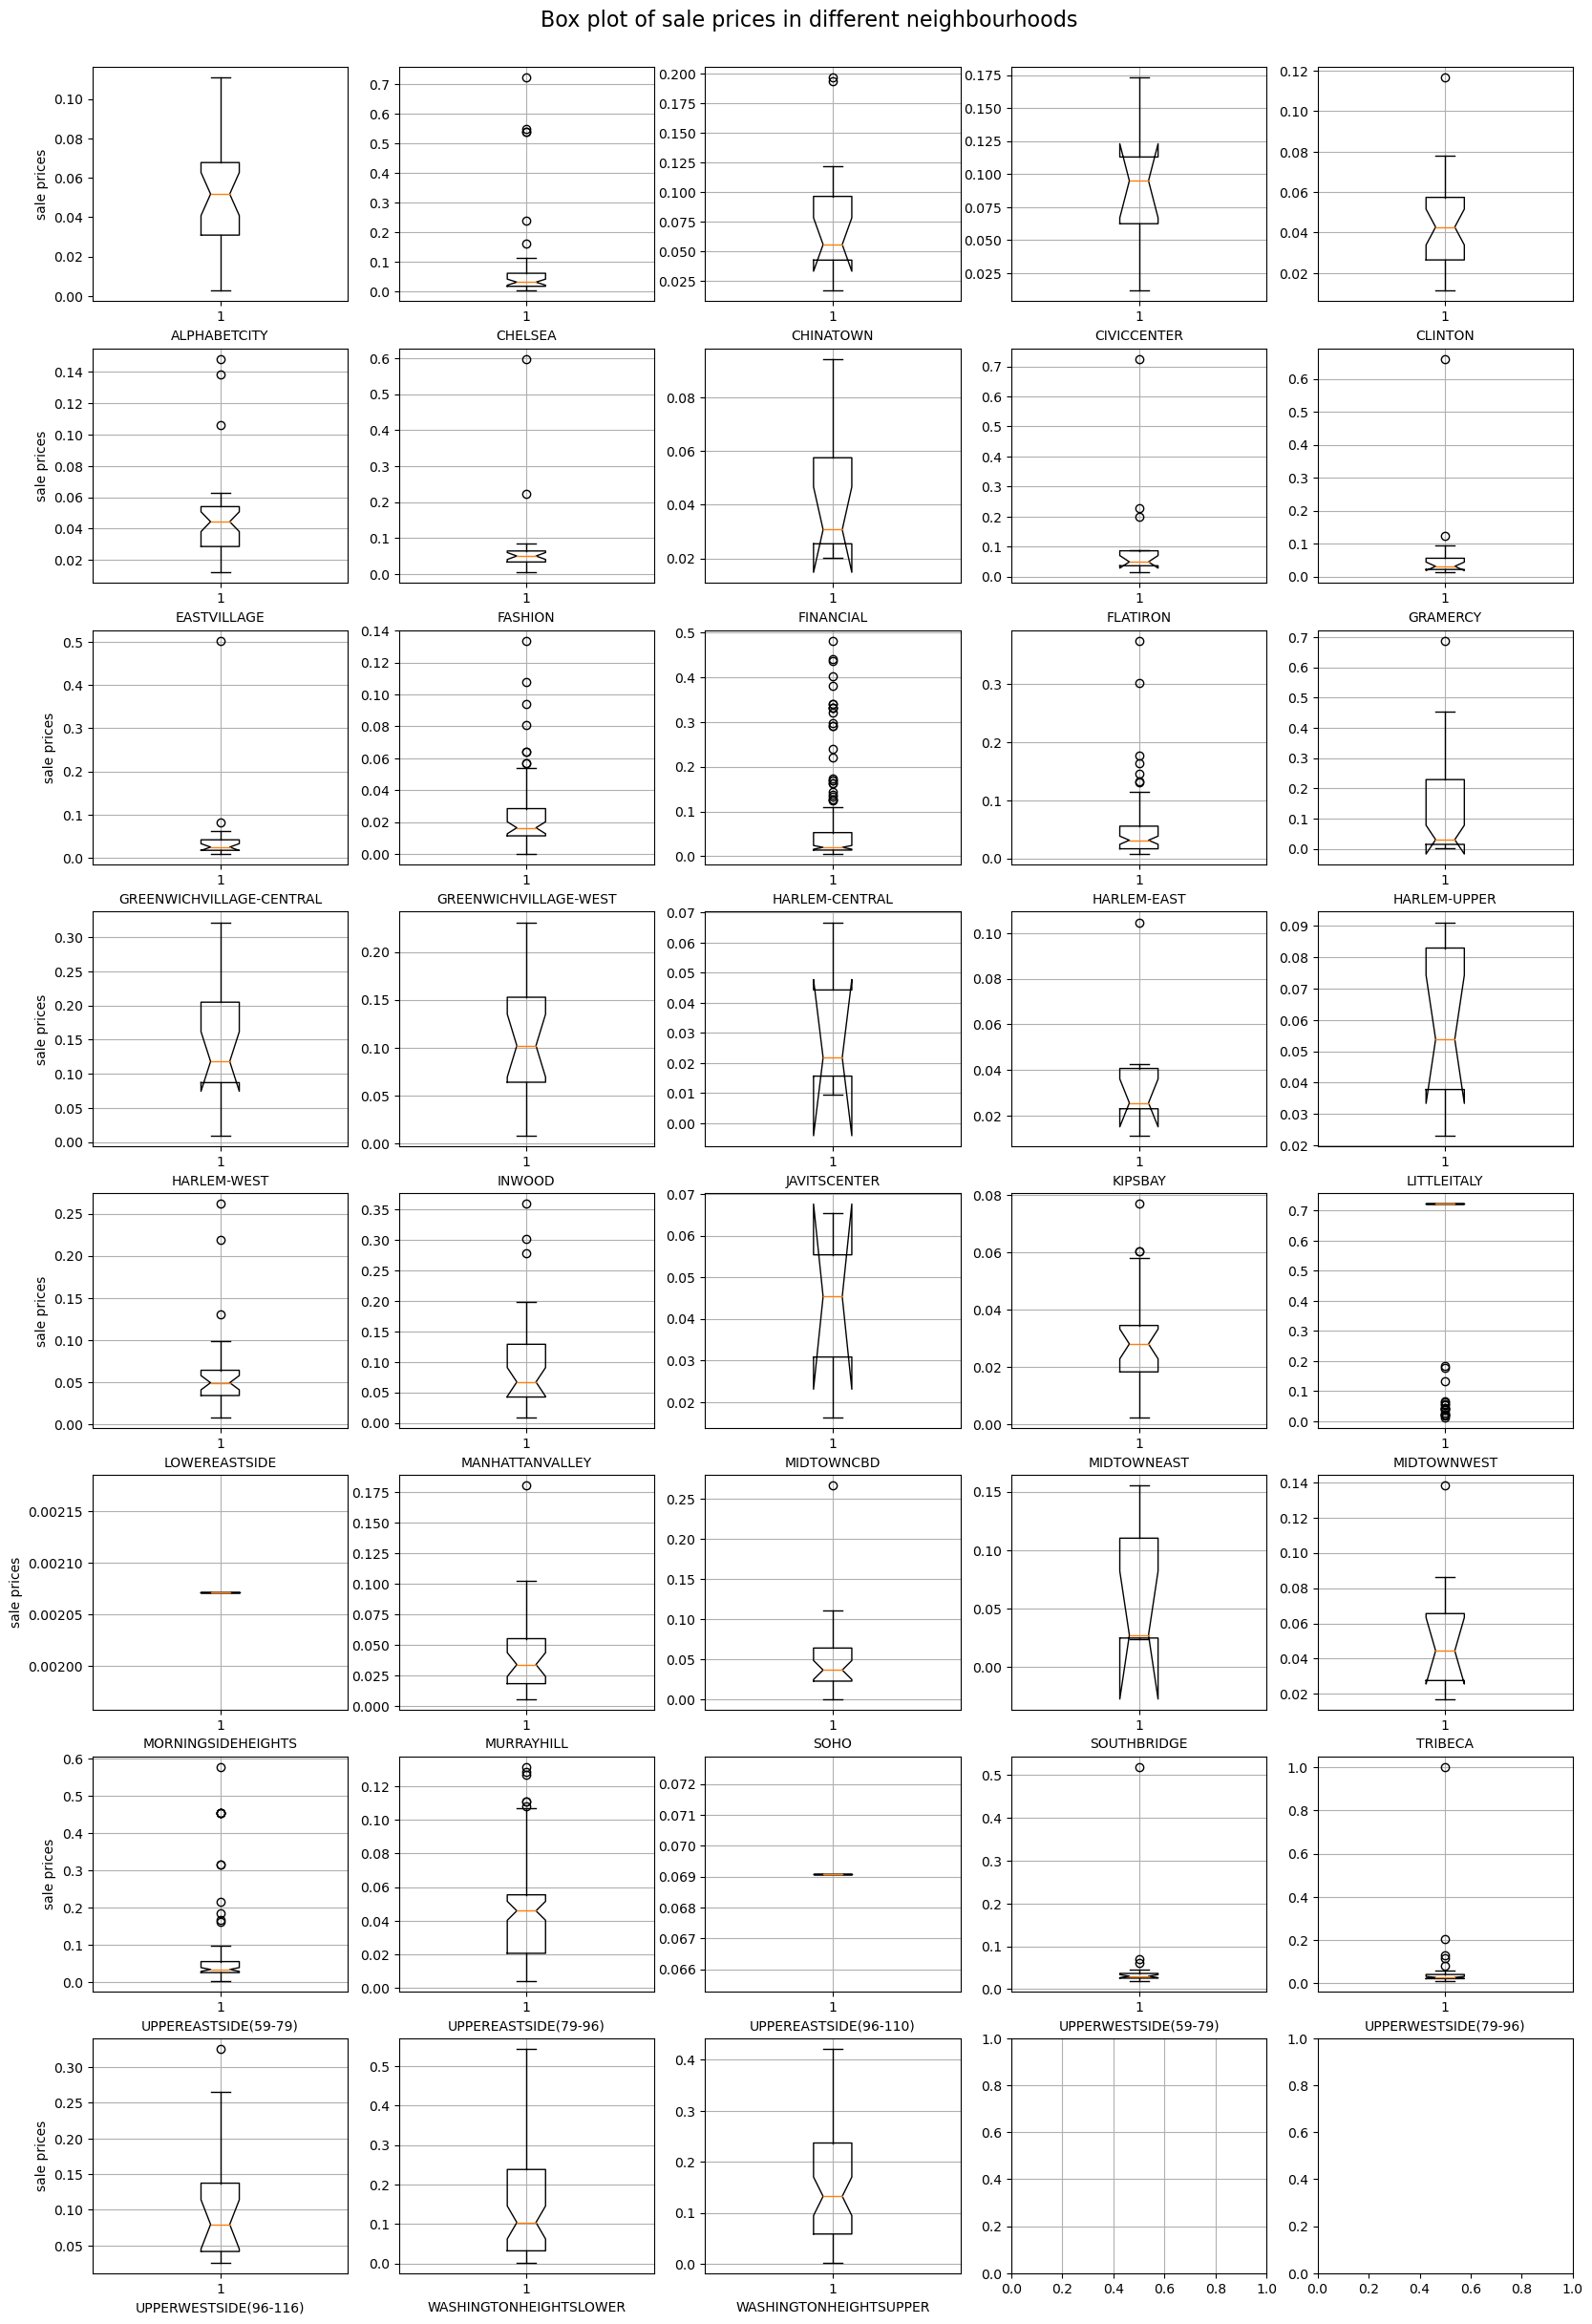

In [24]:
'''
First explore typical prices across different specific neighbourhoods.
'''

def price_neigh(df):
    unique_neigh = df["NEIGHBORHOOD"].unique() 
    fig, axs = plt.subplots(8, 5,figsize=(20, 30), gridspec_kw={'width_ratios': [2, 2, 2, 2, 2],'height_ratios': [8, 8, 8, 8, 8, 8, 8, 8]})
    fig.suptitle('Box plot of sale prices in different neighbourhoods', fontsize=16, y=0.9)
    subr=0
    subc=0
    for un in range(0,len(unique_neigh)):
        dfN = df.loc[df["NEIGHBORHOOD"]==unique_neigh[un]]
        #df.loc[df["NEIGHBORHOOD"]==unique_neigh[un]].boxplot("lnprice","NEIGHBORHOOD", ax)
        axs[subr,subc].boxplot(dfN["GROSS SQUARE FEET"], "NEIGHBORHOOD")
        #axs[subr,subc].set_title("Box plot of sale prices in {}".format(unique_neigh[un]))
        if subc == 0:
            axs[subr,subc].set_ylabel("sale prices")
        axs[subr,subc].set_xlabel(unique_neigh[un])
        axs[subr,subc].set_aspect('auto')
        if subc==4:
            subc=0
            subr+=1
        else:
            subc+=1
        axs[subr,subc].grid()
    plt.show()

    
price_neigh(data)

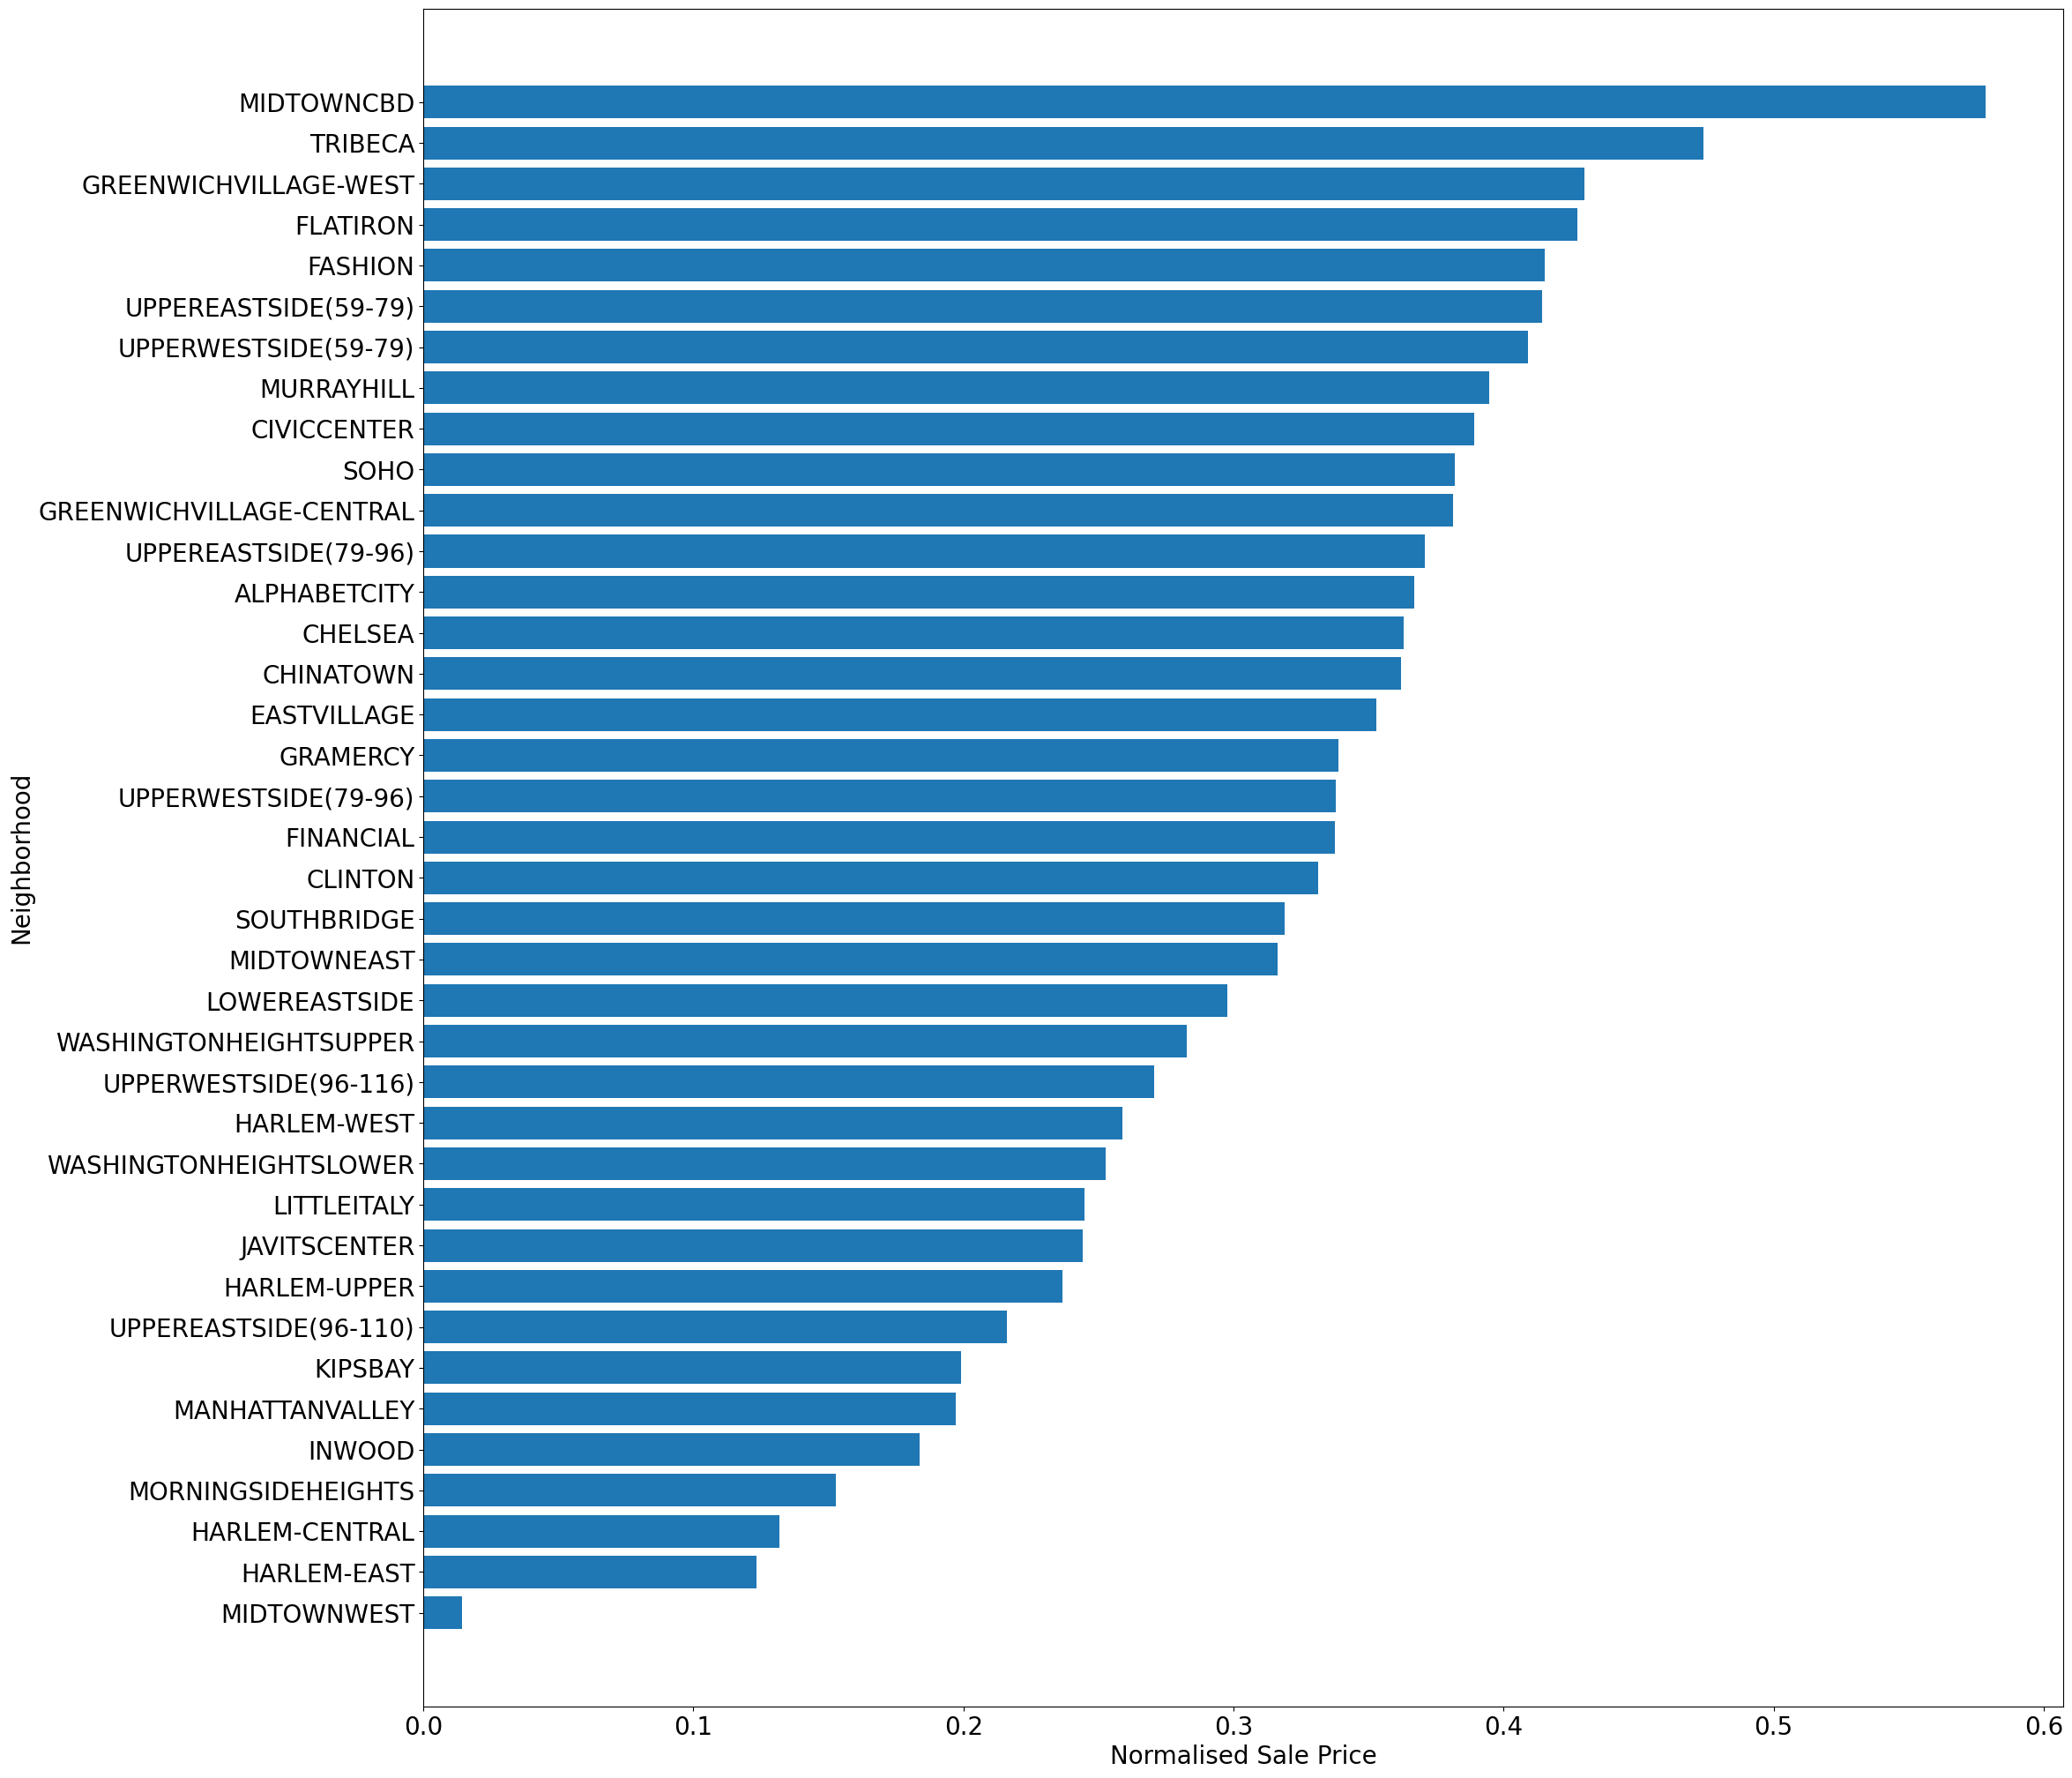

In [25]:
def prices_neigh_bar(df):
    plt.figure(figsize=(24,25))
    neighborhood_means = df.groupby('NEIGHBORHOOD')['SALE PRICE'].mean().sort_values()
    #print(pd.DataFrame(neighborhood_means.keys(),neighborhood_means.values))
    plt.barh(neighborhood_means.keys(),neighborhood_means.values)
    plt.xlabel("Normalised Sale Price", fontsize="20")
    plt.yticks(fontsize="20")
    plt.xticks(fontsize="20")
    plt.ylabel("Neighborhood", fontsize="20")
    plt.show()
prices_neigh_bar(data)

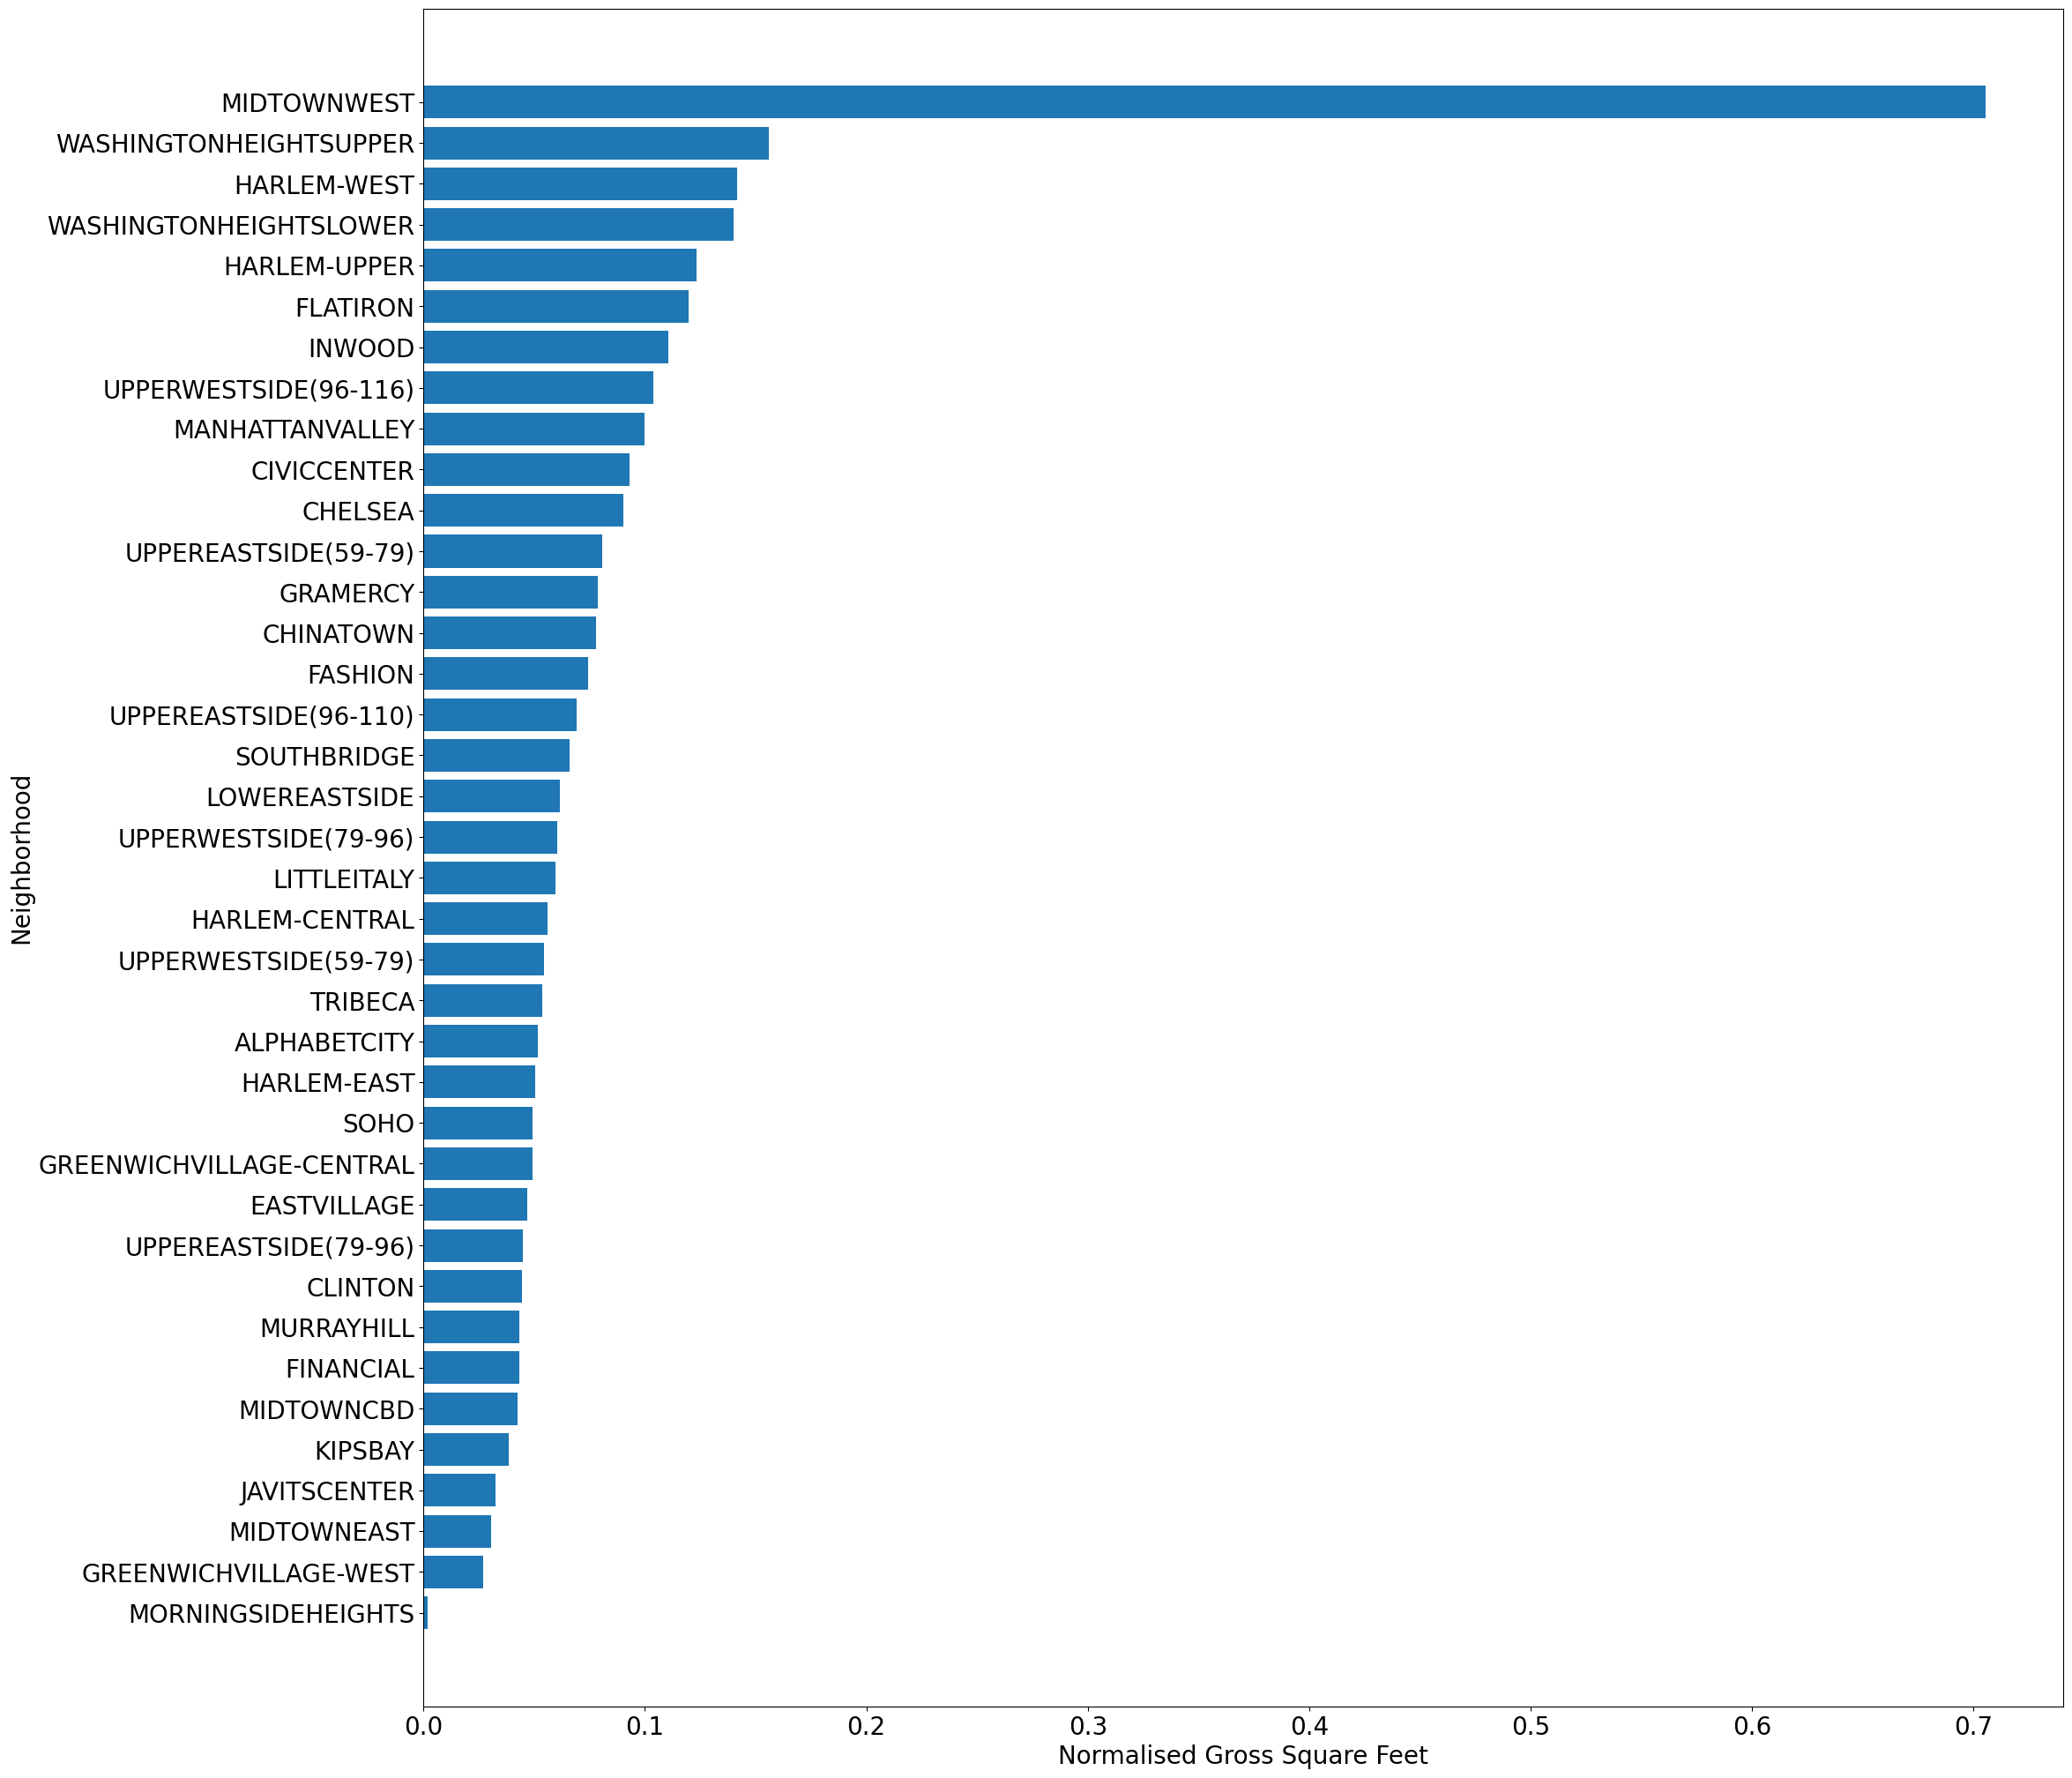

In [26]:
def gross_neigh_bar(df):
    plt.figure(figsize=(24,25))
    neighborhood_means = df.groupby('NEIGHBORHOOD')['GROSS SQUARE FEET'].mean().sort_values()
    #print(pd.DataFrame(neighborhood_means.keys(),neighborhood_means.values))
    plt.barh(neighborhood_means.keys(),neighborhood_means.values)
    plt.xlabel("Normalised Gross Square Feet", fontsize="20")
    plt.yticks(fontsize="20")
    plt.xticks(fontsize="20")
    plt.ylabel("Neighborhood", fontsize="20")
    plt.show()
gross_neigh_bar(data)

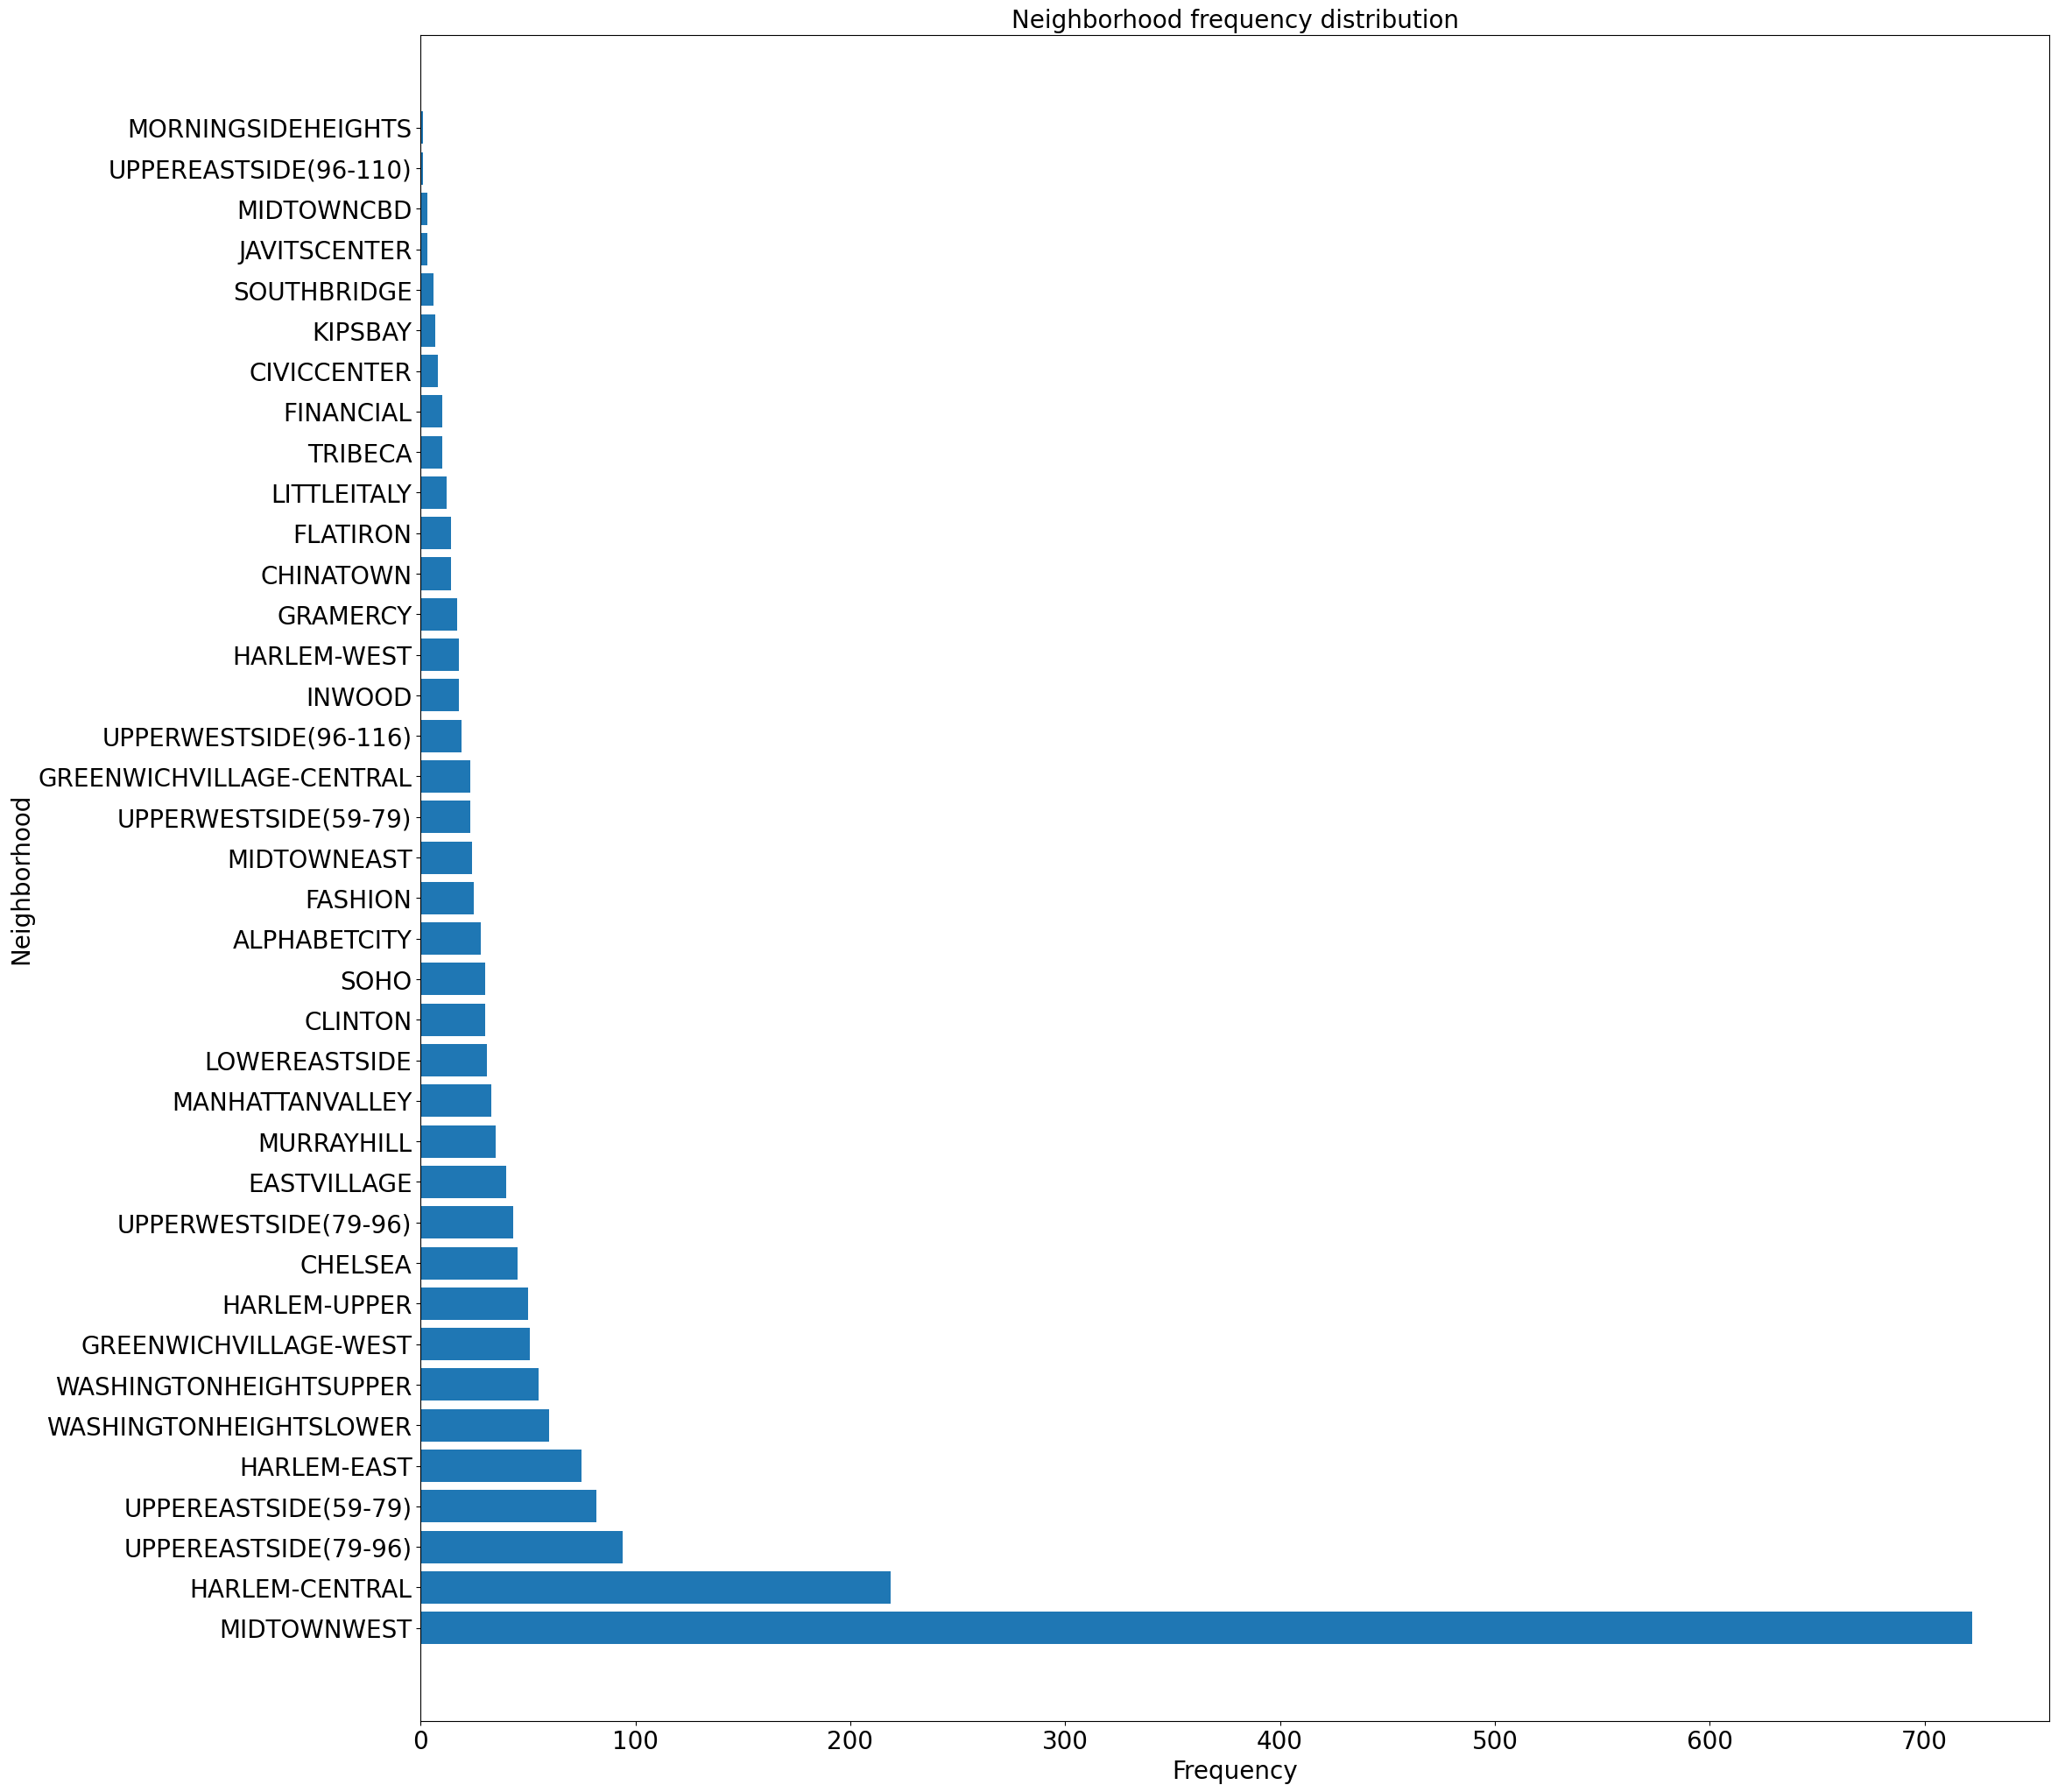

In [27]:
#print(data['NEIGHBORHOOD'].value_counts())
counts = data['NEIGHBORHOOD'].value_counts()
plt.figure(figsize=(24,25))
plt.barh(counts.keys(),counts.values)
plt.title("Neighborhood frequency distribution", fontsize="20")
plt.xlabel("Frequency", fontsize="20")
plt.yticks(fontsize="20")
plt.xticks(fontsize="20")
plt.ylabel("Neighborhood", fontsize="20")
plt.show()

Varying price quartiles and medians within different neighbourhoods suggest that the neighbourhood has an impact on overall sale price and should be considered by the model. 



### Visualise the prices over time

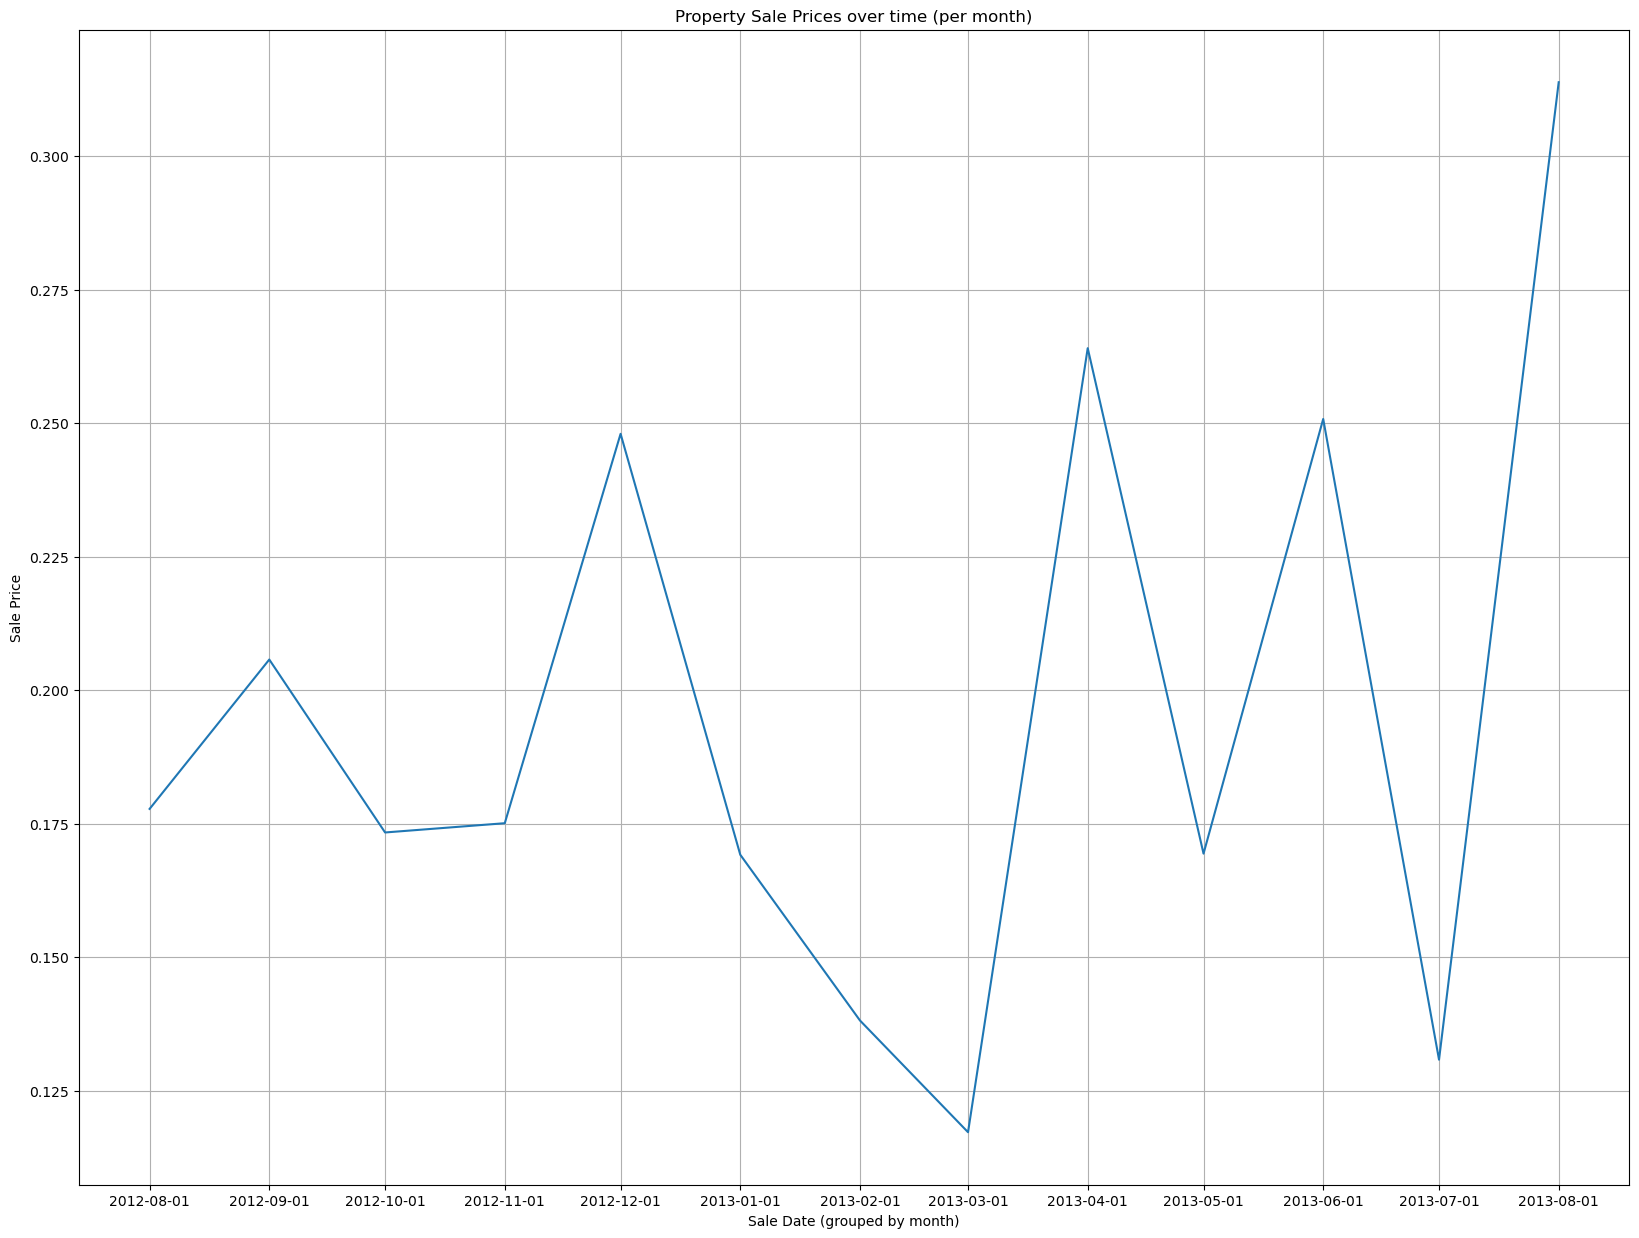

In [28]:
def price_time(df):
    """
    plt.figure(figsize=(20,15))
    plt.scatter(df["SALE DATE"].values.astype('datetime64[M]'), df["SALE PRICE"], c=df["SALE PRICE"], cmap="cool")
    print(df["SALE PRICE"].shape)
    plt.title("prices over time (per month)")
    plt.xlabel("date of sales")
    plt.xticks(df["SALE DATE"].values.astype('datetime64[M]'))
    plt.ylabel("sale price")
    plt.show()
    """
    months_df = data.groupby(df['SALE DATE'].astype('datetime64[M]'))['SALE PRICE'].mean()

    #price_time_df = pd.DataFrame(months_df.keys(), months_df.values)
    plt.figure(figsize=(20,15))
    plt.plot(months_df.keys(),  months_df.values)
    plt.title('Property Sale Prices over time (per month)')
    plt.xlabel('Sale Date (grouped by month)')
    plt.xticks(months_df.keys())
    plt.ylabel('Sale Price')
    plt.grid()
    plt.show()
    
price_time(data)


Can see that prices generally lie between 0 and 0.2 over the years with some outliers from 0.2 and beyond (almost reaching 1). Issue with number of datapoints closer to end date - biasing the scatter plot results. Later prices are not congested between 0 and 0.2 and are positioned nearing higher prices than earlier dates.

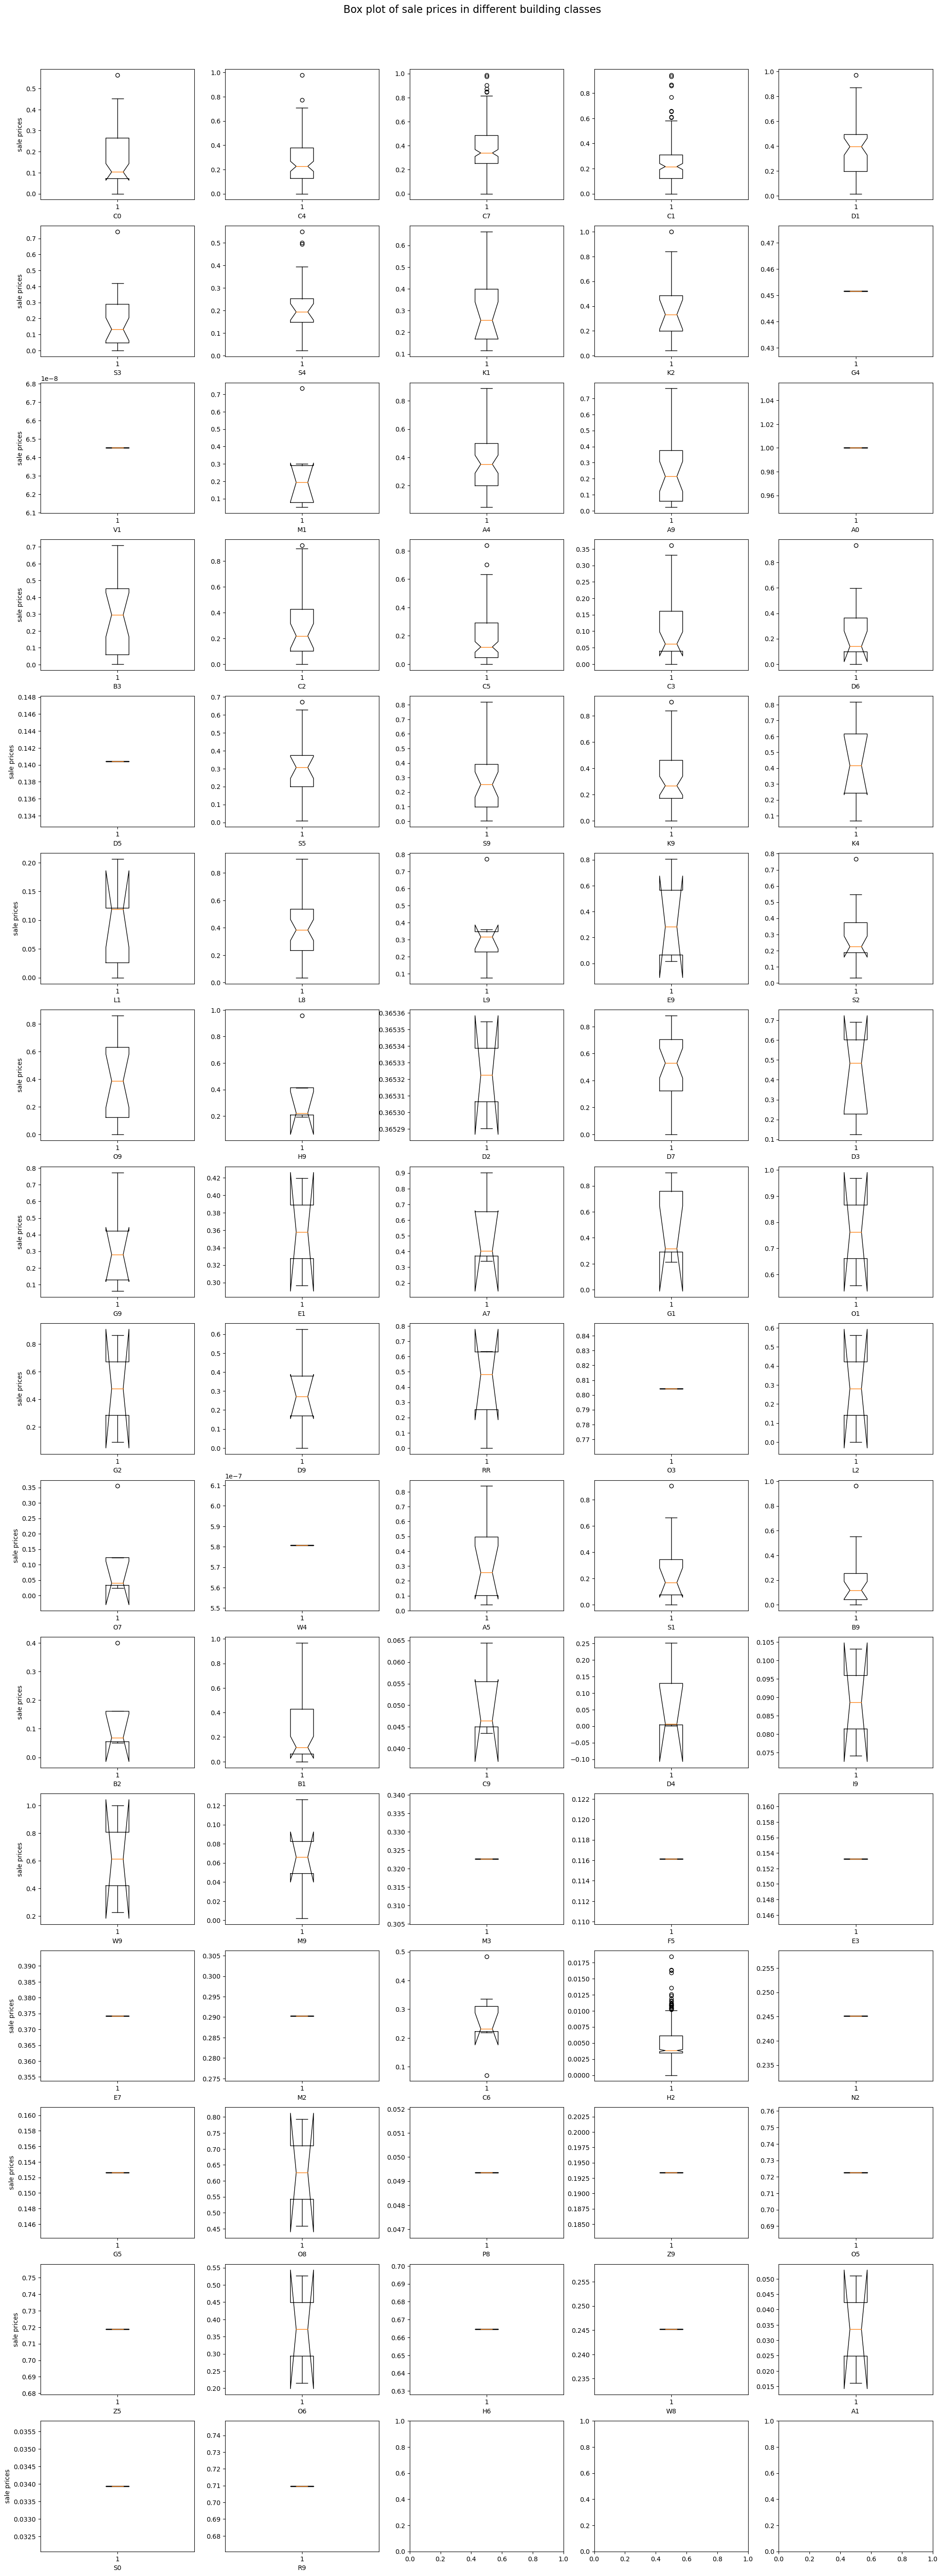

In [29]:
def p_bc(df):
    unique_bc = df["BUILDING CLASS AT TIME OF SALE"].unique() 
    fig, axs = plt.subplots(16, 5,figsize=(25, 70), gridspec_kw={'width_ratios': [2, 2, 2, 2, 2],'height_ratios': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]})
    fig.suptitle('Box plot of sale prices in different building classes', fontsize=16, y=0.9)
    subr=0
    subc=0
    for un in range(0,len(unique_bc)):
        dfN = df.loc[df["BUILDING CLASS AT TIME OF SALE"]==unique_bc[un]]
        axs[subr,subc].boxplot(dfN["SALE PRICE"], "BUILDING CLASS AT TIME OF SALE")
        if subc == 0:
            axs[subr,subc].set_ylabel("sale prices")
        axs[subr,subc].set_xlabel(unique_bc[un])
        axs[subr,subc].set_aspect('auto')
        if subc==4:
            subc=0
            subr+=1
        else:
            subc+=1
    plt.show()
p_bc(data)

Variability within different values of the building class suggest that the class of the property greatly determines the sale price.

             BUILDING CLASS AT TIME OF SALE
6.451613e-08                             V1
5.806452e-07                             W4
4.804789e-03                             H2
3.354832e-02                             A1
3.393542e-02                             S0
...                                     ...
7.187097e-01                             Z5
7.225806e-01                             O5
7.629964e-01                             O1
8.042597e-01                             O3
1.000000e+00                             A0

[77 rows x 1 columns]


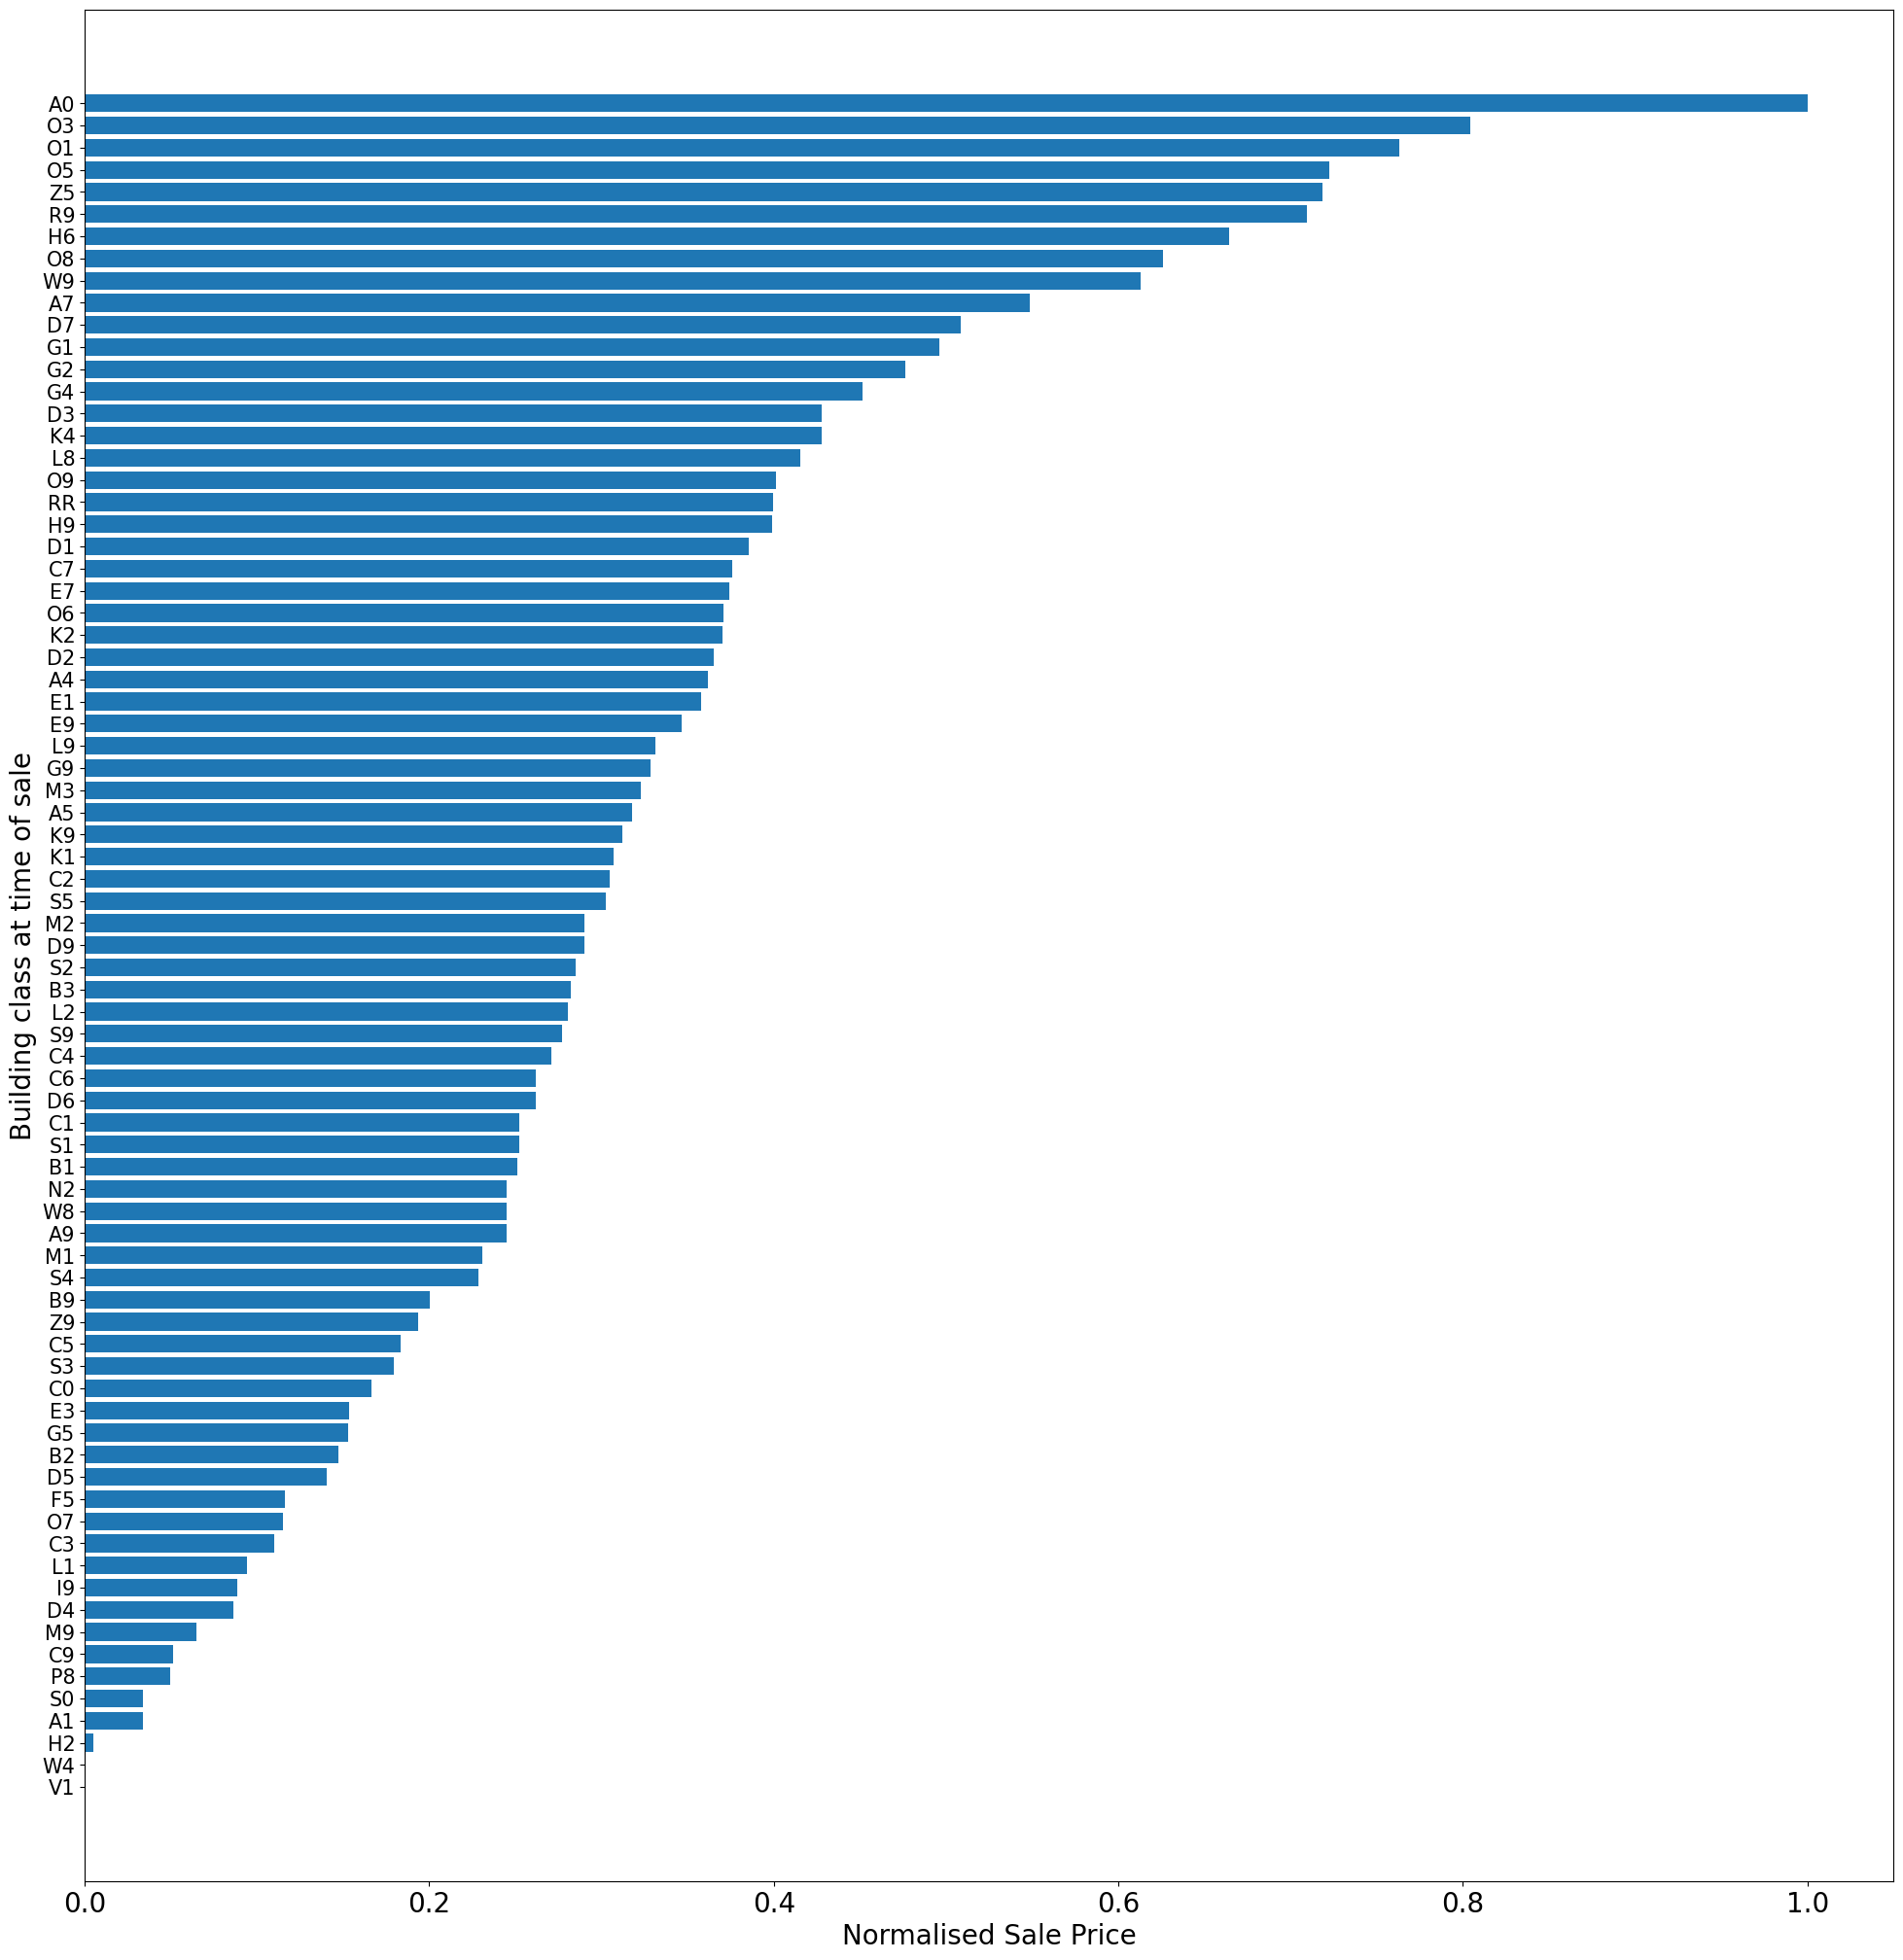

In [30]:
def prices_build(df):
    plt.figure(figsize=(24,25))
    class_means = df.groupby('BUILDING CLASS AT TIME OF SALE')['SALE PRICE'].mean().sort_values()
    print(pd.DataFrame(class_means.keys(),class_means.values))
    plt.barh(class_means.keys(),class_means.values)
    plt.xlabel("Normalised Sale Price", fontsize="20")
    plt.xticks(fontsize="20")
    plt.ylabel("Building class at time of sale", fontsize="20")
    plt.yticks(fontsize="15")
    plt.show()
prices_build(data)

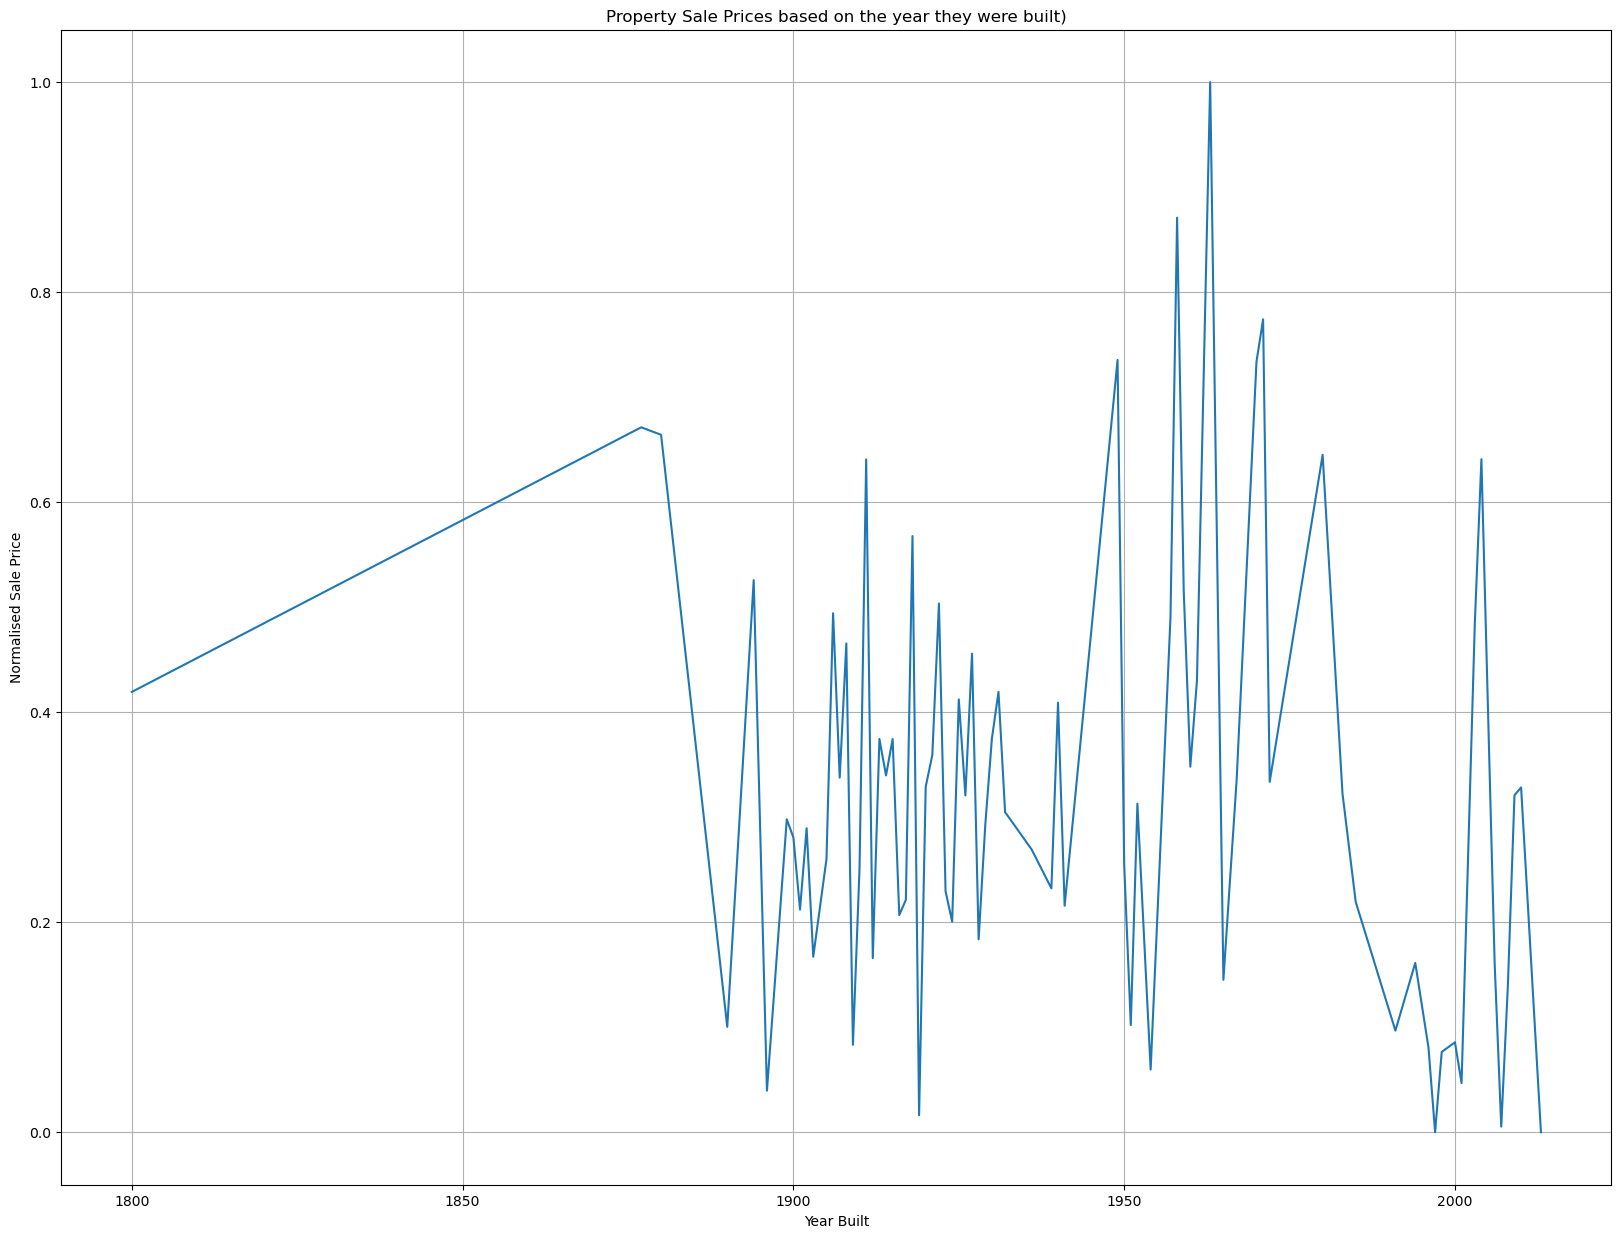

In [31]:
def price_year_built(df):
    year_df = data.groupby(df['YEAR BUILT'])['SALE PRICE'].mean()

    #price_time_df = pd.DataFrame(months_df.keys(), months_df.values)
    plt.figure(figsize=(20,15))
    plt.plot(year_df.keys(),  year_df.values)
    plt.title('Property Sale Prices based on the year they were built)')
    plt.xlabel('Year Built')
    plt.ylabel('Normalised Sale Price')
    plt.grid()
    plt.show()
    
price_year_built(data)

From this scatter plot we can conclude that the year build of the property factors greatly into the price. However, the number of data points for later years (>1960) is reduced. This may build some bias in the model predictions to favour the smaller set of data points for later years. Variability within the different classes for price output suggest that the class parameter could be considered in the final model.

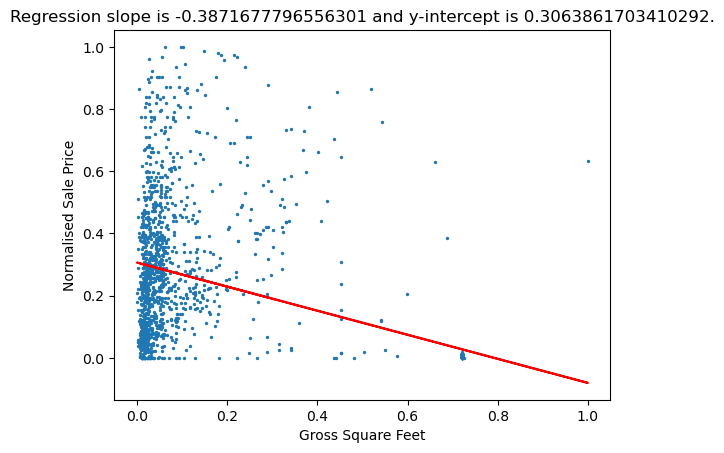

In [32]:
from scipy.stats import linregress

def price_grossSq(df):
    
    # Regression line
    slope, intercept, r_value, p_value, std_err = linregress(df['GROSS SQUARE FEET'], df['SALE PRICE'])
    
    def regression_y(x):
        return slope * x + intercept
    
    #a, b = np.polyfit(df['GROSS SQUARE FEET'], df['SALE PRICE'], 1)
    
    plt.title("Scatter plot of prices over gross sq feet")
    plt.scatter(df["GROSS SQUARE FEET"], df["SALE PRICE"], s=2)
    plt.plot(df['GROSS SQUARE FEET'], regression_y(df['GROSS SQUARE FEET']), 'r')
    #plt.plot(df['GROSS SQUARE FEET'], a*df['GROSS SQUARE FEET']+b, 'g')
    plt.ylabel("Normalised Sale Price")
    plt.xlabel("Gross Square Feet")
    plt.title("Regression slope is {} and y-intercept is {}.".format(slope, intercept))
    plt.show()
    
    
price_grossSq(data)

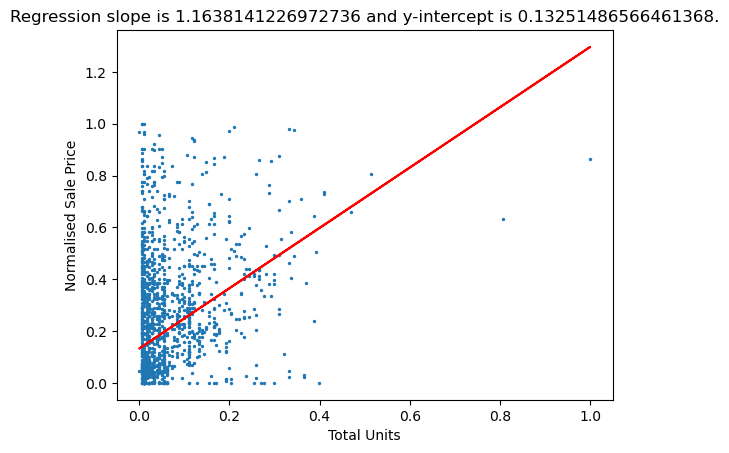

In [33]:
def price_tu(df):
    
    # Regression line
    slope, intercept, r_value, p_value, std_err = linregress(df['TOTAL UNITS'], df['SALE PRICE'])
    
    def regression_y(x):
        return slope * x + intercept
    
    plt.title("Scatter plot of prices over total units of a property")
    plt.scatter(df["TOTAL UNITS"], df["SALE PRICE"], s=2)
    plt.plot(df['TOTAL UNITS'], regression_y(df['TOTAL UNITS']), 'r')
    plt.ylabel("Normalised Sale Price")
    plt.xlabel("Total Units")
    plt.title("Regression slope is {} and y-intercept is {}.".format(slope, intercept))
    plt.show()
    
    
price_tu(data)

## Scatter plot matrix of numeric variables

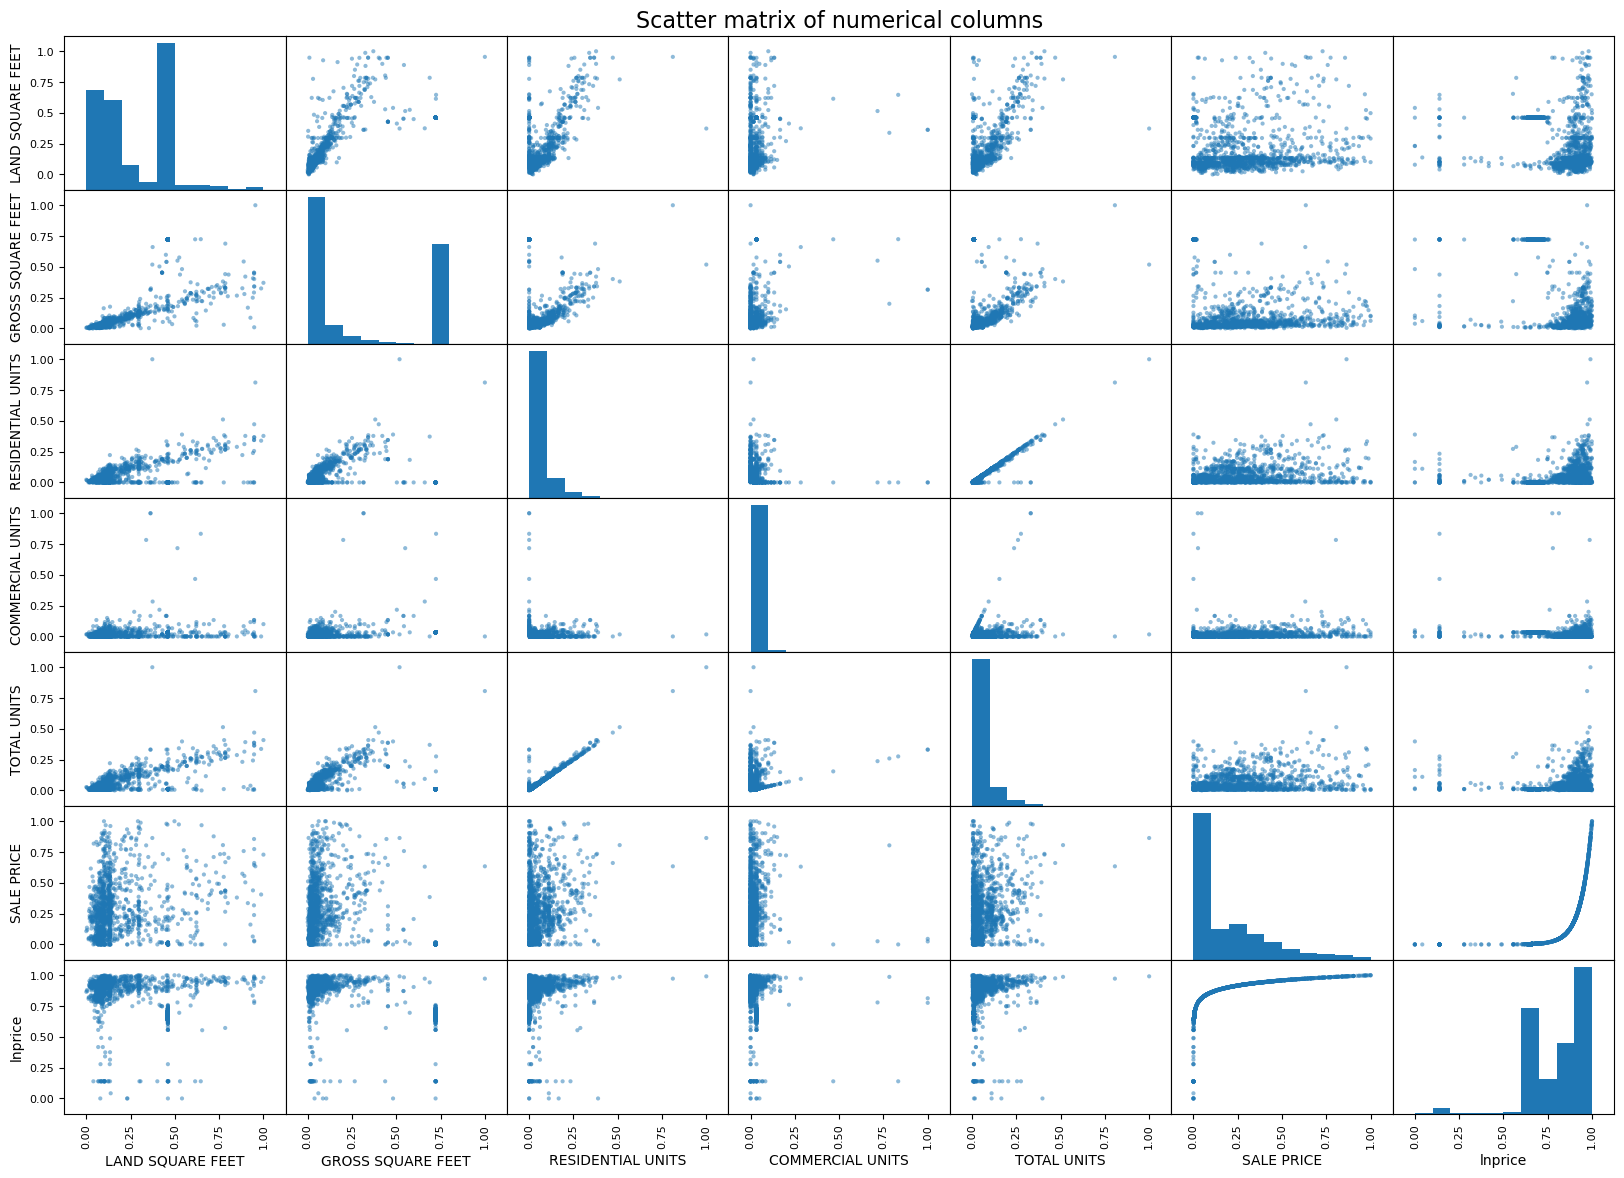

In [34]:
from pandas.plotting import scatter_matrix

def scatter_m(df, numericals):
    scatter_matrix(df[numericals], diagonal='hist', figsize=(20,14), range_padding=0.25)
    plt.title('Scatter matrix of numerical columns', fontsize=16, y=7, x=-2.5)
    plt.show()
    
numericals = ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'SALE PRICE','lnprice']
scatter_m(data,numericals)

Collinearities:
- Near perfect positive correlation:
        - Residential units vs Total units
- Very strong positive correlation:
        - Land Square feet vs Gross square feet
        - Land Square feet vs Residential units
        - Land Square feet vs Total units
        - Gross square feet vs Residential units
        - Gross square feet vs Total units
- Weak positive correlation:
        - Commercial units vs Land Square feet
        - Sale price vs land square feet
        - Sale price vs gross square feet
        - Sale price vs Residential units
        - Sale price vs Commercial units
        - Sale price vs Total units

## Correlation matrix 

In [35]:
corr = data[numericals].corr().style.background_gradient(cmap="spring")
corr

Sale price has higher correl values against other columns and should be used primarily for model outcome rather than lnprice.

# Choosing good predictors

There are 2 ways of choosing predictors for the regression model. You can either use an estimator algorithm that fits the list of numerical columns to find which columns/features best predict the outcome. The number of features we want to select depends on us and in this scenario we want at least 3 so the model generalises well. The second method is to hand pick the predictors based on the correlation matrix and choosing the features with the highest correlation to sale price.

In [36]:
from sklearn import svm, feature_selection, linear_model

def first_ranked_predictors(df, numerical_features, outcome_feature):
    feature_cols = df[numerical_features].columns.values.tolist()

    XO = df[feature_cols]
    YO = df[outcome_feature]
    estimator = svm.SVR(kernel="linear")
    selector = feature_selection.RFE(estimator, n_features_to_select=3, step=1)
    selector = selector.fit(XO, YO)
    # From the ranking you can select your predictors with rank 1
    # Model 1; let us select the folowing features as predictors:
    select_features = np.array(feature_cols)[selector.ranking_ == 1].tolist()
    return select_features

select_features = first_ranked_predictors(data, ['COMMERCIAL UNITS', 'TOTAL UNITS', 'RESIDENTIAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'], 'lnprice')
print(select_features)

['TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']


# Data splitting and Model training
sklearn's functions can be used to split the dataset into a large train set and a small test set to compare the predictions with. Since, we want to predict the house sale price we need to use a linear regression model. After, the model is trained we can find the training and test accuracy.

In [37]:
from sklearn.model_selection import train_test_split

def data_split_train(df, predictor_features, outcome_feature):
    X = df[predictor_features]
    Y = df[outcome_feature]
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2) #, random_state=42)
    lm = linear_model.LinearRegression()
    lm.fit(trainX, trainY)
    # Inspect the calculated model equations
    print("Y-axis intercept {:6.4f}".format(lm.intercept_))
    print("Weight coefficients:")
    for feat, coef in zip(predictor_features, lm.coef_):
        print(" {:>20}: {:6.4f}".format(feat, coef))
    # The value of R^2
    print("R squared for the training data is {:4.3f}".format(lm.score(trainX, trainY)))
    print("Score against test data: {:4.3f}".format(lm.score(testX, testY)))
    return (lm, testX, testY)


In [38]:
sp_lm, sp_testX, sp_testY = data_split_train(data, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')
print("Mean Squared Error: {}".format(mean_squared_error(sp_testY, sp_lm.predict(sp_testX))))

Y-axis intercept 0.8656
Weight coefficients:
     LAND SQUARE FEET: 0.1680
          TOTAL UNITS: 0.1809
    GROSS SQUARE FEET: -0.3843
R squared for the training data is 0.414
Score against test data: 0.499
Mean Squared Error: 0.012174560430015696


# Histogram of residuals
Residuals are the difference in the actual value and predicted value to find out how far off the model was.

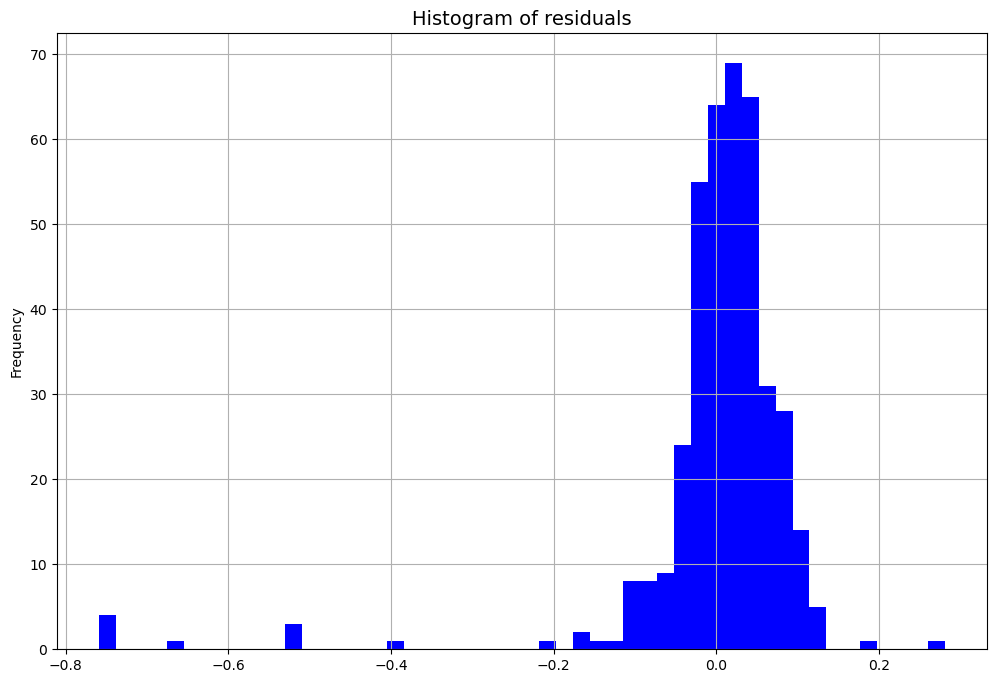

In [39]:
def hist_res(tModel, testX, testY):
    prediction = tModel.predict(testX)
    residuals = (testY - prediction)

    plt.figure(figsize=(12, 8))
    plt.title('Histogram of residuals', fontsize=14)
    plt.hist(residuals, color='blue', bins=50)
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    return
hist_res(sp_lm, sp_testX, sp_testY)

# Cross validation

In [40]:
from sklearn.model_selection import cross_val_score, KFold

def cv(df, tModel, pred_features, outcome):
    crossvalidation = KFold(10, shuffle=True)
    X = df[pred_features]
    Y = df[outcome]
    scores = cross_val_score(tModel, X, Y, cv=crossvalidation) # 5 K-folds is the default value
    print("Cross validation scores: {}".format(scores))
    print("Cross validation mean scores: {}".format(np.mean(scores)))
cv(data, sp_lm, ['TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'], 'lnprice')

Cross validation scores: [0.34947952 0.52234155 0.36033433 0.55821514 0.27135123 0.49073521
 0.54107    0.46881744 0.49518141 0.34115149]
Cross validation mean scores: 0.4398677316520108


# PART 2

## With a focus on cleaning the Part 1 dataset differently

In [41]:
valid_sp_df = pd.DataFrame(og_data[og_data['SALE PRICE'].notna()])


print("After removing rows with null sale price values")
print(valid_sp_df.shape)
print(valid_sp_df.isna().sum())


valid_lasqft_df = valid_sp_df[valid_sp_df['LAND SQUARE FEET'].notna()]

valid_grsqft_df = pd.DataFrame(valid_lasqft_df[valid_lasqft_df['GROSS SQUARE FEET'].notna()])

print("After removing rows with null land square feet values")
print(valid_lasqft_df.shape)
print(valid_lasqft_df.isna().sum())

print("After removing rows with null gross square feet values")
print(valid_grsqft_df.shape)
print(valid_grsqft_df.isna().sum())


After removing rows with null sale price values
(18928, 18)
NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            1145
TAX CLASS AT PRESENT                116
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT           116
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  16616
GROSS SQUARE FEET                 16690
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64
After removing rows with null land square feet values
(2312, 18)
NEIGHBORHOOD                       0
BUILDING CLASS CATEGORY            0
TAX CLASS AT PRESENT               0
BLOCK                          

In [42]:
valid_grsqft_df['RESIDENTIAL UNITS'] = valid_grsqft_df['RESIDENTIAL UNITS'].replace(to_replace = np.nan,  value = 0)
valid_grsqft_df['COMMERCIAL UNITS'] = valid_grsqft_df['COMMERCIAL UNITS'].replace(to_replace = np.nan,  value = 0)
valid_grsqft_df['TOTAL UNITS'] = valid_grsqft_df['TOTAL UNITS'].replace(to_replace = np.nan,  value = 0)

In [43]:
print(numericals)

['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'SALE PRICE', 'lnprice']


In [44]:
valid_grsqft_df.isna().sum()

NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [45]:
valid_grsqft_df.shape

(2232, 18)

In [46]:
valid_grsqft_df["lnprice"] = pd.DataFrame(np.log(valid_grsqft_df["SALE PRICE"]))

In [47]:
valid_grsqft_df.describe()

BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE      lnprice
count  2232.000000  2232.000000   2232.000000        2232.000000       2232.000000  2232.000000       2232.000000        2232.000000  2232.000000                2232.000000  2.232000e+03  2232.000000
mean   1214.444444    48.492384  10025.397401           9.758961          2.083333    11.836470       5963.900538       54965.280466  1944.948477                   2.829749  1.008254e+07    13.751327
std     533.654143    84.960317     28.316174          27.446736          6.322801    28.012158       8793.566208       74804.703895    45.781452                   1.171395  4.246882e+07     2.853660
min      11.000000     1.000000  10001.000000           0.000000          0.000000     0.000000        469.000000         999.000000  1800.000000                   1.000000  1.000000e+00     0.000000
25%    1009.000000    26.000000  10019.000000           0.000000          0.000000     2.000000       2018.000000        5662.250000  1910.000000                   2.000000  8.832650e+04    11.388792
50%    1009.000000    37.000000  10019.000000           1.000000          2.000000     3.000000       4600.000000       17077.500000  1920.000000                   2.000000  2.200000e+06    14.603968
75%    1661.250000    45.000000  10028.000000          10.000000          2.000000    11.000000       7532.000000      112850.000000  2007.000000                   4.000000  6.256250e+06    15.649090
max    2246.000000  1502.000000  10463.000000         538.000000        150.000000   550.000000     213650.000000      940000.000000  2013.000000                   4.000000  1.100000e+09    20.818576

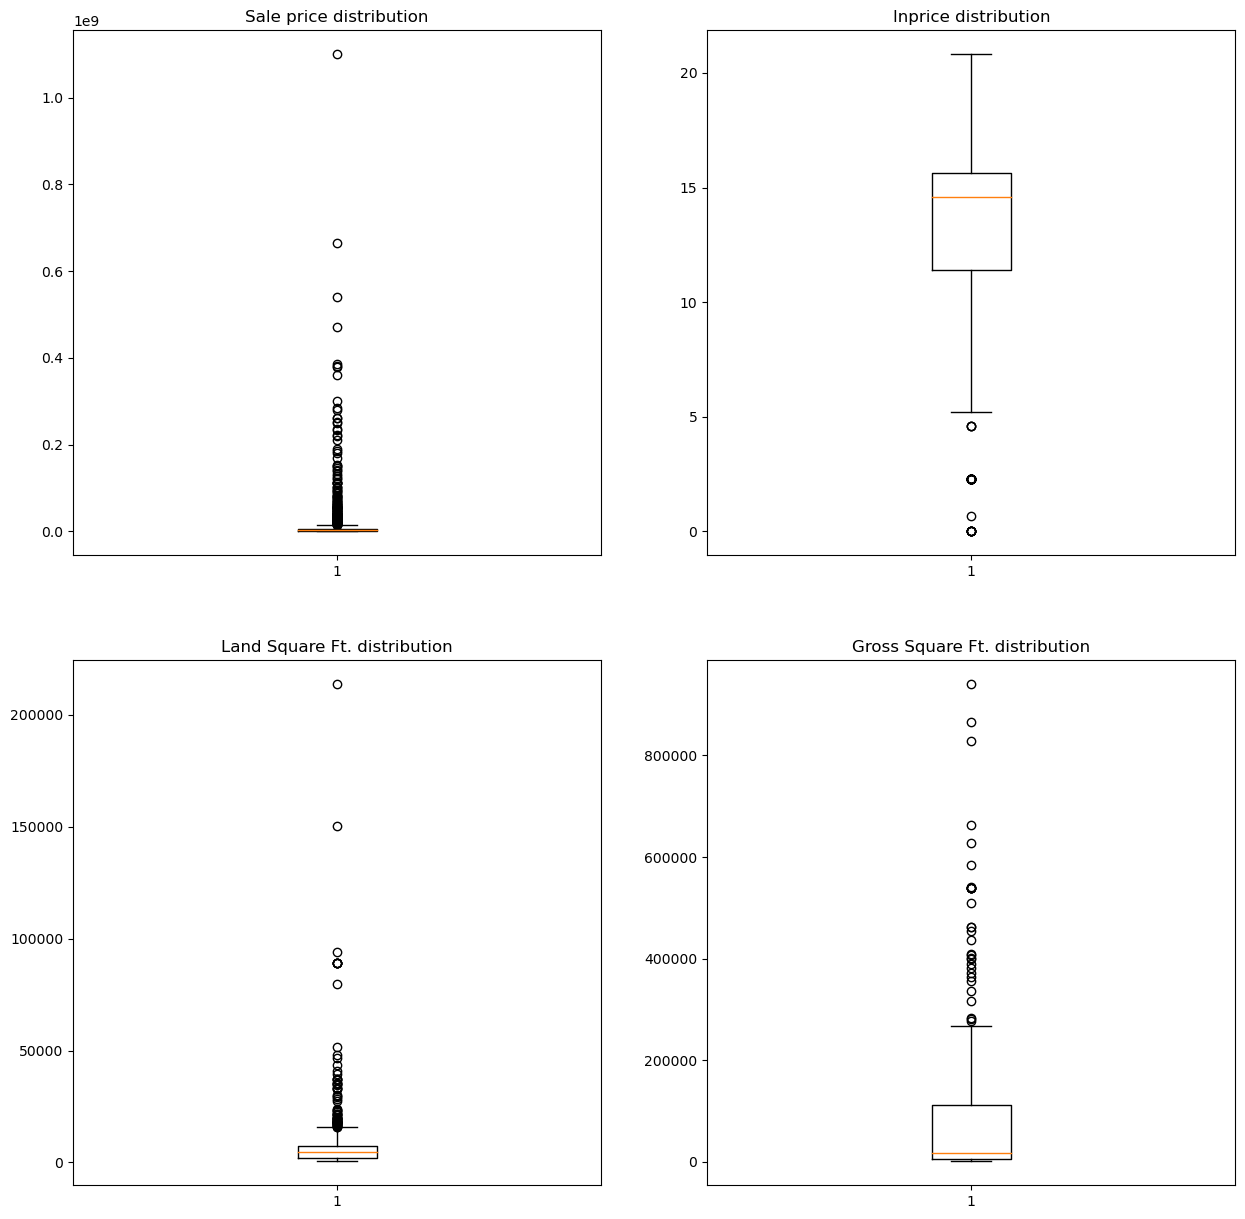

In [48]:
# Creating sub plots
fig, axs = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)

#Boxplots within each subplot space
axs[0,0].boxplot((valid_grsqft_df['SALE PRICE']))
axs[0,0].set_title("Sale price distribution")
axs[0,1].boxplot((valid_grsqft_df['lnprice']))
axs[0,1].set_title("lnprice distribution")
axs[1,0].boxplot((valid_grsqft_df['LAND SQUARE FEET']))
axs[1,0].set_title("Land Square Ft. distribution")
axs[1,1].boxplot((valid_grsqft_df['GROSS SQUARE FEET']))
axs[1,1].set_title("Gross Square Ft. distribution")

# show plot
plt.show()

In [49]:
valid_grsqft_df = identify_outlier(valid_grsqft_df, ["SALE PRICE", "lnprice", "LAND SQUARE FEET", "GROSS SQUARE FEET"])
print(display(valid_grsqft_df.head(10)))
print("number of outliers identified:", valid_grsqft_df['outlier'].sum())
valid_grsqft_df = valid_grsqft_df[valid_grsqft_df.outlier == 0]
valid_grsqft_df.drop('outlier', axis = 1, inplace = True)


NEIGHBORHOOD     BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  LOT BUILDING CLASS AT PRESENT               ADDRESS  ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET  YEAR BUILT  TAX CLASS AT TIME OF SALE BUILDING CLASS AT TIME OF SALE  SALE PRICE  SALE DATE    lnprice  outlier
18  ALPHABETCITY          03THREEFAMILYHOMES                    1    377   66                        C0      243EAST7THSTREET     10009                  3                 0            3            2381.0             3084.0        1899                          1                             C0   3150000.0 2013-03-06  14.962913      0.0
21  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                    2    375   62                        C4      715EAST5THSTREET     10009                 20                 0           20            2426.0             9345.0        1900                          2                             C4   3650000.0 2012-09-06  15.110238      0.0
22  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                    2    376   30                        C4  274EASTSEVENTHSTREET     10009                 13                 0           13            2726.0            13002.0        1910                          2                             C4    895250.0 2012-10-25  13.704858      0.0
24  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                   2B    385    1                        C7             17AVENUEB     10009                  7                 1            8            2093.0             5852.0        1997                          2                             C7       283.0 2013-04-18   5.645447      0.0
25  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                    2    391   55                        C4      309EAST8THSTREET     10009                 17                 0           17            2164.0             9071.0        1900                          2                             C4   3500000.0 2012-10-16  15.068274      0.0
26  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                    2    397   33                        C7             14AVENUEB     10009                 25                 2           27            3574.0            18212.0        1925                          2                             C7  13185684.0 2013-01-31  16.394642      0.0
30  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                    2    398   53                        C7      170EAST2NDSTREET     10009                 36                 3           39            4452.0            17664.0        1900                          2                             C7   3810602.0 2012-10-26  15.153298      0.0
31  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                   2B    400   56                        C4      203EAST4THSTREET     10009                 10                 1           10            2404.0             6975.0        1900                          2                             C4   7333333.0 2013-04-09  15.807941      0.0
32  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                   2B    400   57                        C4      201EAST4THSTREET     10009                  9                 1            9            2404.0             6875.0        1900                          2                             C4   7333333.0 2013-04-09  15.807941      0.0
33  ALPHABETCITY  07RENTALS-WALKUPAPARTMENTS                   2B    400   58                        C4      199EAST4THSTREET     10009                  9                 1           10            2404.0             7110.0        1900                          2                             C4   7333333.0 2013-04-09  15.807941      0.0

None
number of outliers identified: 294.0


In [50]:
valid_grsqft_df.shape

(1938, 19)

In [51]:
valid_grsqft_df.describe()
stats = valid_grsqft_df.describe()
display(stats)

BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE      lnprice
count  1938.000000  1938.000000   1938.000000        1938.000000        1938.00000  1938.000000       1938.000000        1938.000000  1938.000000                1938.000000  1.938000e+03  1938.000000
mean   1231.640351    46.449432  10025.655831           7.312693           1.44324     8.750774       4762.994324       48086.784314  1946.949948                   2.796182  2.994304e+06    13.563589
std     529.283937    67.061024     29.198990          13.223321           2.74038    13.209652       3022.515326       49851.971484    47.107212                   1.176805  3.542832e+06     2.084434
min      11.000000     1.000000  10001.000000           0.000000           0.00000     0.000000        469.000000         999.000000  1800.000000                   1.000000  1.830000e+02     5.209486
25%    1009.000000    29.000000  10019.000000           0.000000           0.00000     2.000000       1998.500000        5272.000000  1910.000000                   2.000000  8.349500e+04    11.332542
50%    1009.000000    37.000000  10019.000000           1.000000           2.00000     2.000000       3871.000000       14000.000000  1920.000000                   2.000000  1.555000e+06    14.256981
75%    1688.000000    44.000000  10029.000000           9.000000           2.00000    10.000000       7532.000000      112850.000000  2007.000000                   4.000000  4.900000e+06    15.404746
max    2246.000000  1502.000000  10463.000000         180.000000          60.00000   181.000000      15800.000000      155975.000000  2010.000000                   4.000000  1.550000e+07    16.556351

Histograms of GSQF AND LSQF against different price ranges


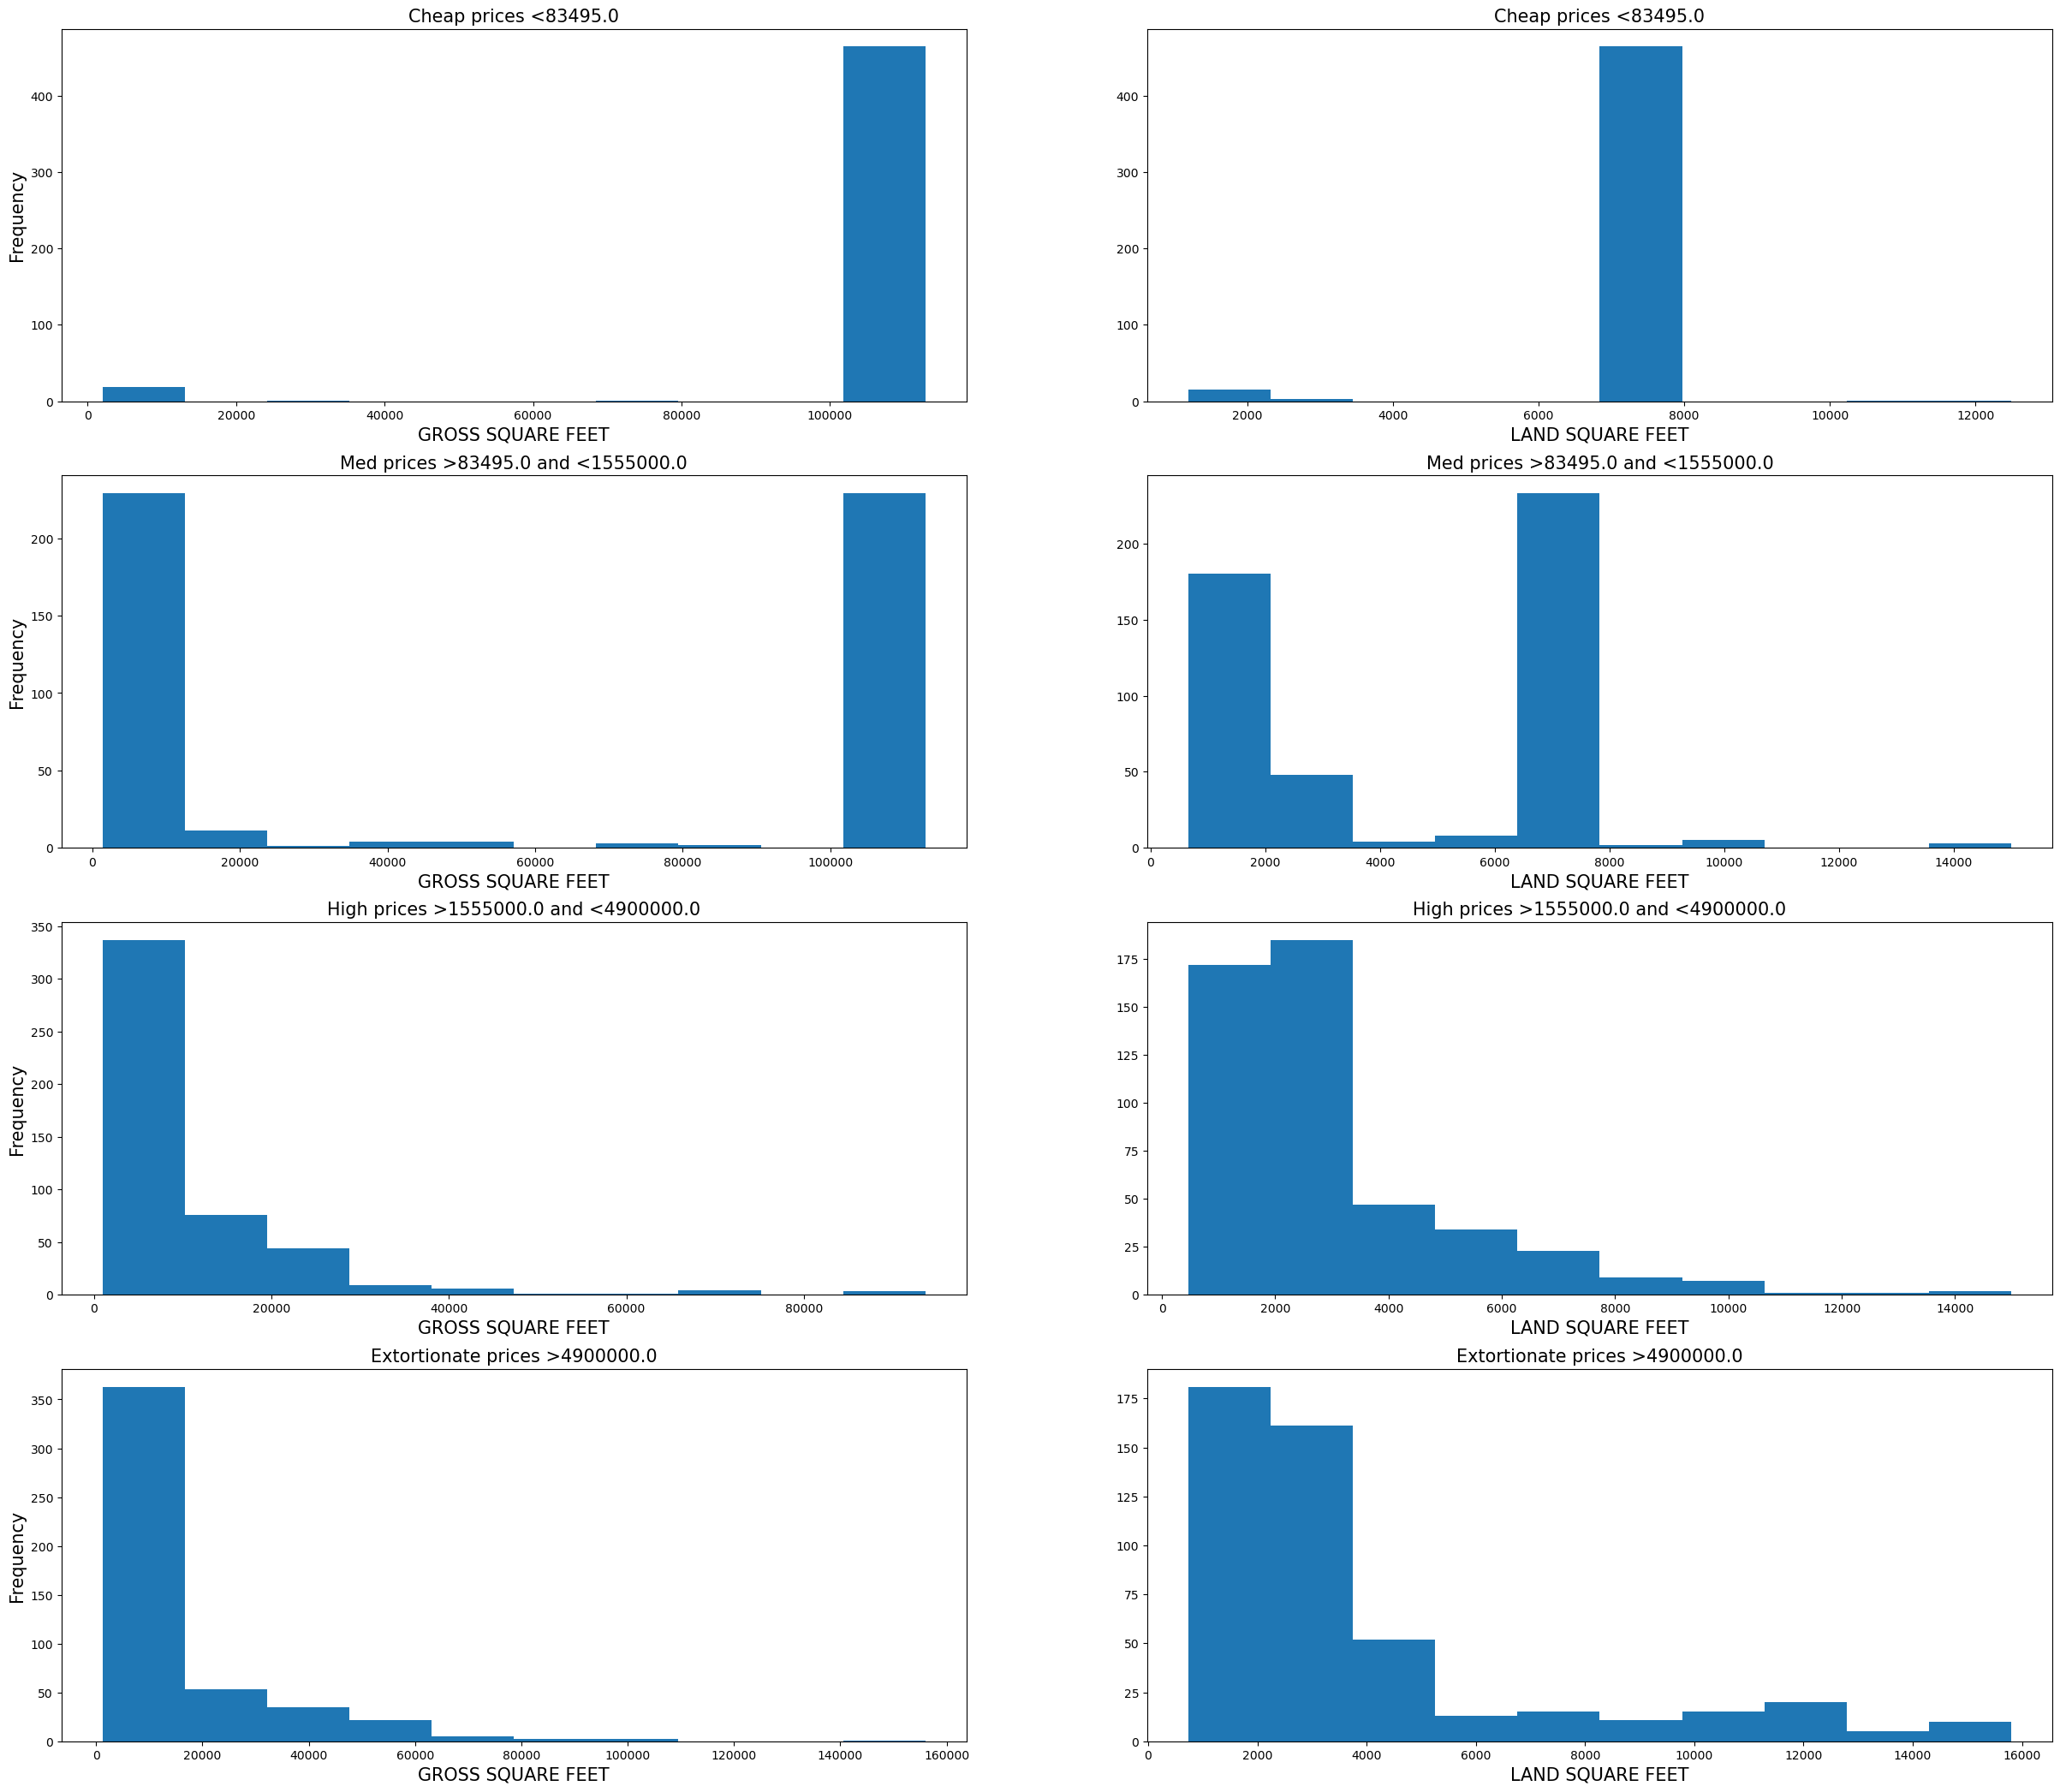

In [52]:
# We need to find the relationship between Land and Gross Square Feet in relation to different costs of sale prices

def land_gross_sp_distribution(df, desc):
    #sale price since lnprice proportionalised to sale price more tightly
    #for gross
    cheap = df.loc[df["SALE PRICE"] < desc["SALE PRICE"]["25%"]]
    med = df.loc[(df["SALE PRICE"] > desc["SALE PRICE"]["25%"]) & (df["SALE PRICE"] < desc["SALE PRICE"]["50%"])]
    high = df.loc[(df["SALE PRICE"] > desc["SALE PRICE"]["50%"]) & (df["SALE PRICE"] < desc["SALE PRICE"]["75%"])]
    extortionate = df.loc[df["SALE PRICE"] > desc["SALE PRICE"]["75%"]]

    print('Histograms of GSQF AND LSQF against different price ranges')
    fig, axs = plt.subplots(4, 2,figsize=(30, 20), gridspec_kw={'width_ratios': [7, 7],'height_ratios': [20, 20, 20, 20]})
    #fig.suptitle('Histograms of GSQF AND LSQF against different price ranges', fontsize=16, y=0.99)
    plt.subplots_adjust(top=2, bottom=1)
    subr=0
    subc=0
    for c in ["cheap","med","high","extortionate"]:
        for x in ["gross","land"]:   
            if c == "cheap" and x == "gross": 
                axs[subr,subc].hist(cheap["GROSS SQUARE FEET"])
                axs[subr,subc].set_title("Cheap prices <"+str(desc["SALE PRICE"]["25%"]), fontsize="15")
                axs[subr,subc].set_xlabel("GROSS SQUARE FEET" , fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "med" and x == "gross":
                axs[subr,subc].hist(med["GROSS SQUARE FEET"])
                axs[subr,subc].set_title("Med prices >"+str(desc["SALE PRICE"]["25%"])+" and <"+str(desc["SALE PRICE"]["50%"]), fontsize="15")
                axs[subr,subc].set_xlabel("GROSS SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "high" and x == "gross":
                axs[subr,subc].hist(high["GROSS SQUARE FEET"])
                axs[subr,subc].set_title("High prices >"+str(desc["SALE PRICE"]["50%"])+" and <"+str(desc["SALE PRICE"]["75%"]), fontsize="15")
                axs[subr,subc].set_xlabel("GROSS SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "extortionate" and x == "gross":
                axs[subr,subc].hist(extortionate["GROSS SQUARE FEET"])
                axs[subr,subc].set_title("Extortionate prices >"+str(desc["SALE PRICE"]["75%"]), fontsize="15")
                axs[subr,subc].set_xlabel("GROSS SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "cheap" and x == "land":
                axs[subr,subc].hist(cheap["LAND SQUARE FEET"])
                axs[subr,subc].set_title("Cheap prices <"+str(desc["SALE PRICE"]["25%"]), fontsize="15")
                axs[subr,subc].set_xlabel("LAND SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "med" and x == "land":
                axs[subr,subc].hist(med["LAND SQUARE FEET"])
                axs[subr,subc].set_title("Med prices >"+str(desc["SALE PRICE"]["25%"])+" and <"+str(desc["SALE PRICE"]["50%"]), fontsize="15")
                axs[subr,subc].set_xlabel("LAND SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "high" and x == "land":
                axs[subr,subc].hist(high["LAND SQUARE FEET"])
                axs[subr,subc].set_title("High prices >"+str(desc["SALE PRICE"]["50%"])+" and <"+str(desc["SALE PRICE"]["75%"]), fontsize="15")
                axs[subr,subc].set_xlabel("LAND SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            elif c == "extortionate" and x == "land":
                axs[subr,subc].hist(extortionate["LAND SQUARE FEET"])
                axs[subr,subc].set_title("Extortionate prices >"+str(desc["SALE PRICE"]["75%"]), fontsize="15")
                axs[subr,subc].set_xlabel("LAND SQUARE FEET", fontsize="15")
                axs[subr,subc].set_aspect('auto')
            if subc == 0:
                axs[subr,subc].set_ylabel("Frequency", fontsize="15")
            if subc==1:
                subc=0
                subr+=1
            else:
                subc+=1
    plt.show()
land_gross_sp_distribution(valid_grsqft_df, stats)

In [53]:
normalised_df = normalise(valid_grsqft_df, ["COMMERCIAL UNITS","GROSS SQUARE FEET","LAND SQUARE FEET","RESIDENTIAL UNITS","SALE PRICE", "TOTAL UNITS", "lnprice"])
desc = normalised_df.describe()
display(desc)


Normalising column: COMMERCIAL UNITS
Normalising column: GROSS SQUARE FEET
Normalising column: LAND SQUARE FEET
Normalising column: RESIDENTIAL UNITS
Normalising column: SALE PRICE
Normalising column: TOTAL UNITS
Normalising column: lnprice


BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE   SALE PRICE      lnprice
count  1938.000000  1938.000000   1938.000000        1938.000000       1938.000000  1938.000000       1938.000000        1938.000000  1938.000000                1938.000000  1938.000000  1938.000000
mean   1231.640351    46.449432  10025.655831           0.040626          0.024054     0.048347          0.280086           0.303839  1946.949948                   2.796182     0.193171     0.736248
std     529.283937    67.061024     29.198990           0.073463          0.045673     0.072982          0.197151           0.321675    47.107212                   1.176805     0.228573     0.183701
min      11.000000     1.000000  10001.000000           0.000000          0.000000     0.000000          0.000000           0.000000  1800.000000                   1.000000     0.000000     0.000000
25%    1009.000000    29.000000  10019.000000           0.000000          0.000000     0.011050          0.099765           0.027572  1910.000000                   2.000000     0.005375     0.539625
50%    1009.000000    37.000000  10019.000000           0.005556          0.033333     0.011050          0.221903           0.083890  1920.000000                   2.000000     0.100312     0.797356
75%    1688.000000    44.000000  10029.000000           0.050000          0.033333     0.055249          0.460701           0.721731  2007.000000                   4.000000     0.316121     0.898509
max    2246.000000  1502.000000  10463.000000           1.000000          1.000000     1.000000          1.000000           1.000000  2010.000000                   4.000000     1.000000     1.000000

Histograms of GSQF AND LSQF against different price ranges


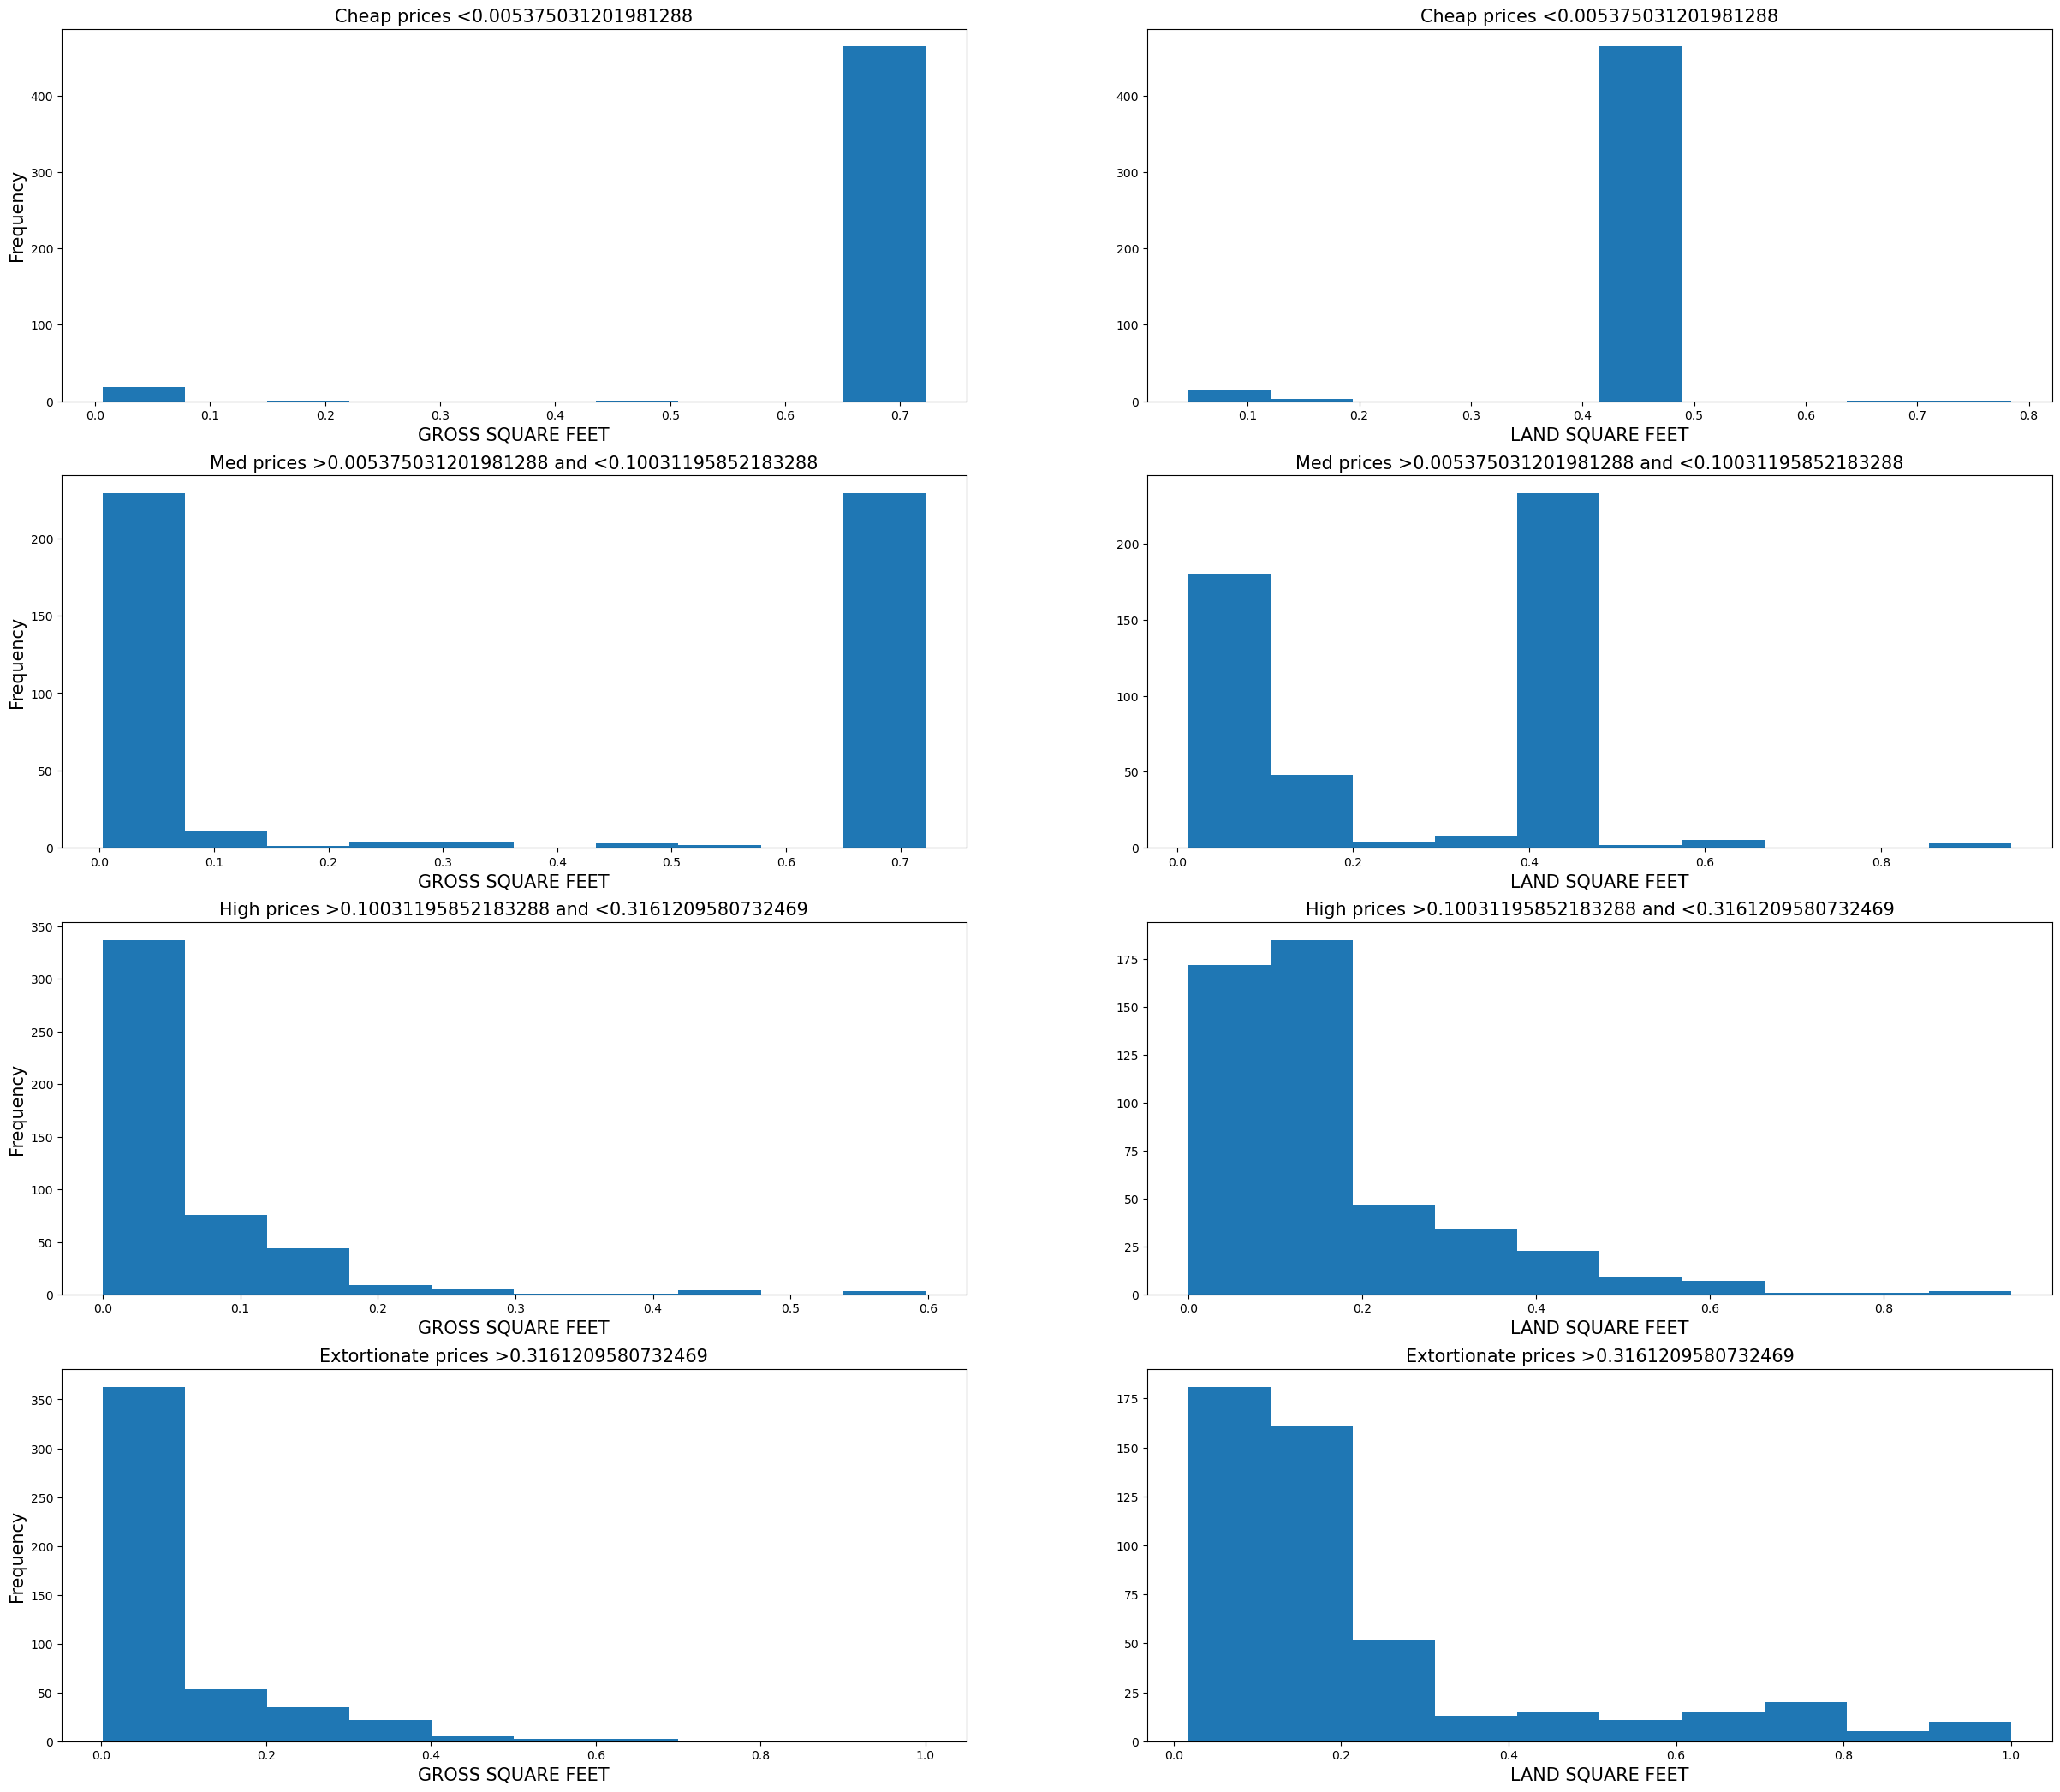

In [54]:
land_gross_sp_distribution(normalised_df, desc)

In [55]:
#cleaned_data.hist(bins=60, figsize=(20, 10))

In [56]:
normalised_df.shape

(1938, 19)

In [57]:
corr = normalised_df[numericals].corr().style.background_gradient(cmap="spring")
corr

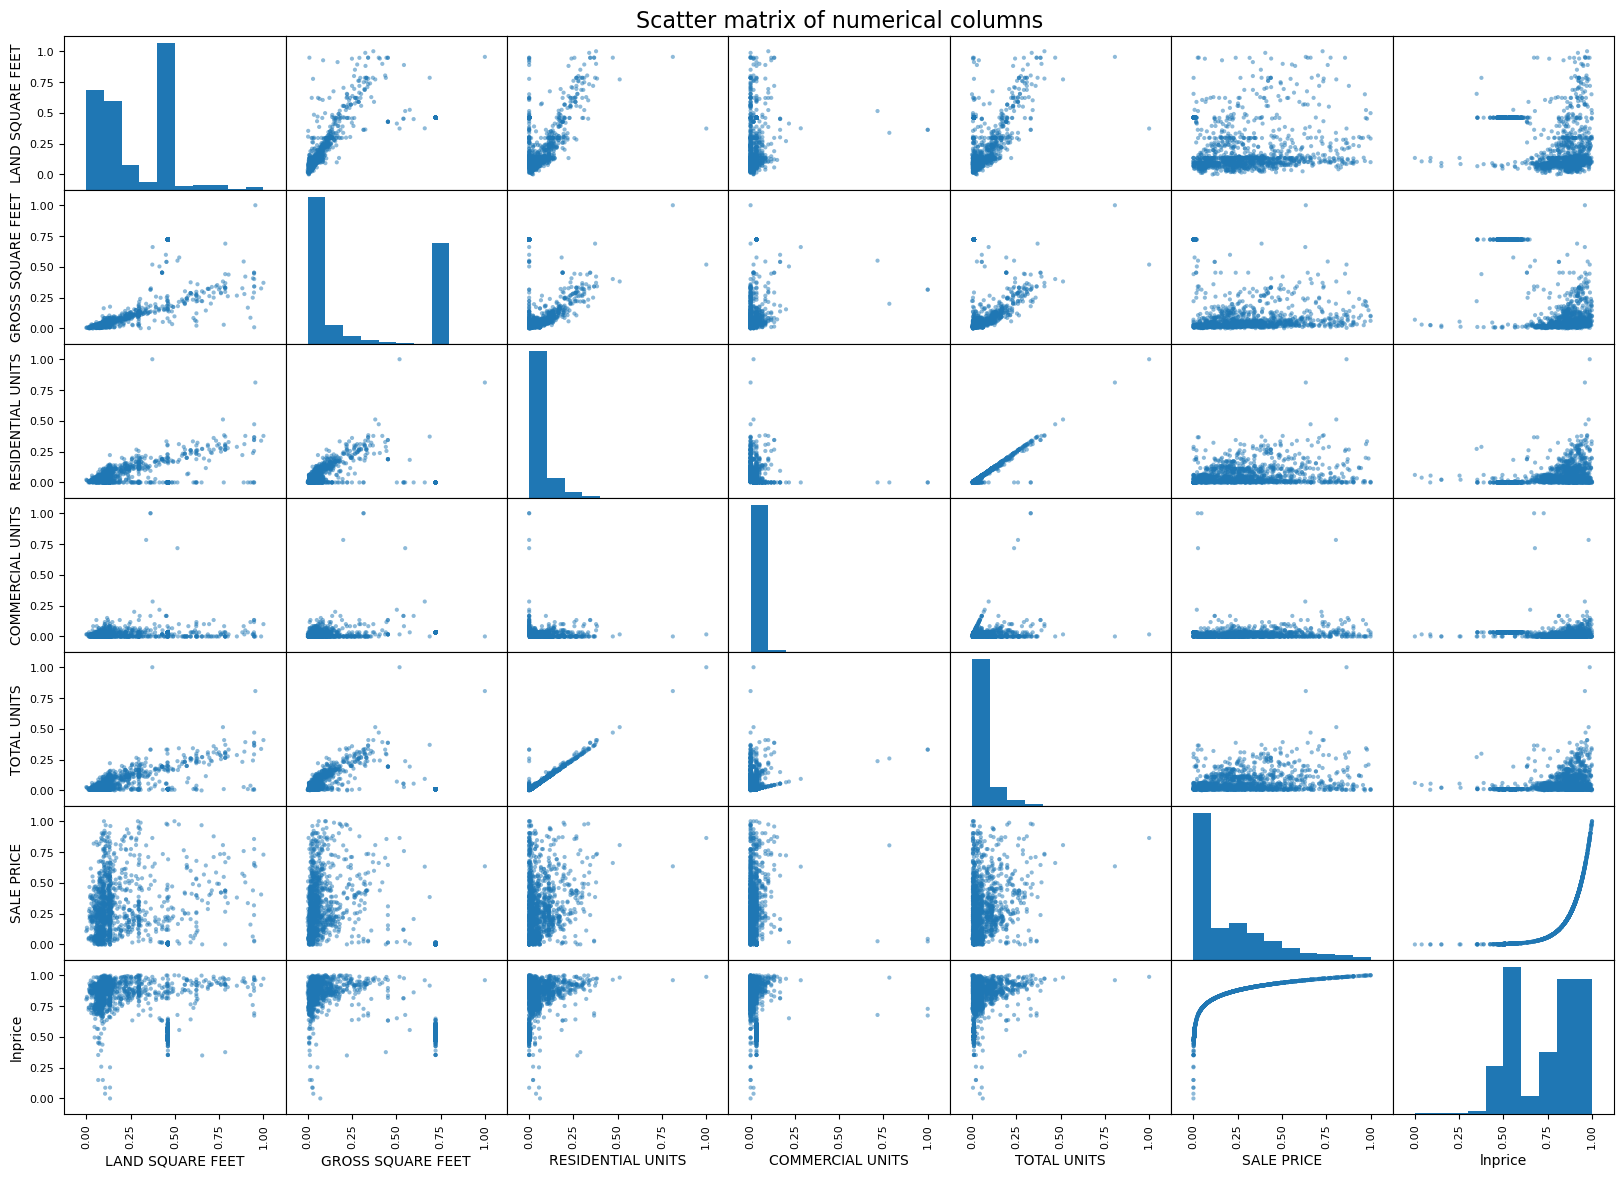

In [58]:
scatter_m(normalised_df,numericals)

['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'SALE PRICE', 'lnprice']


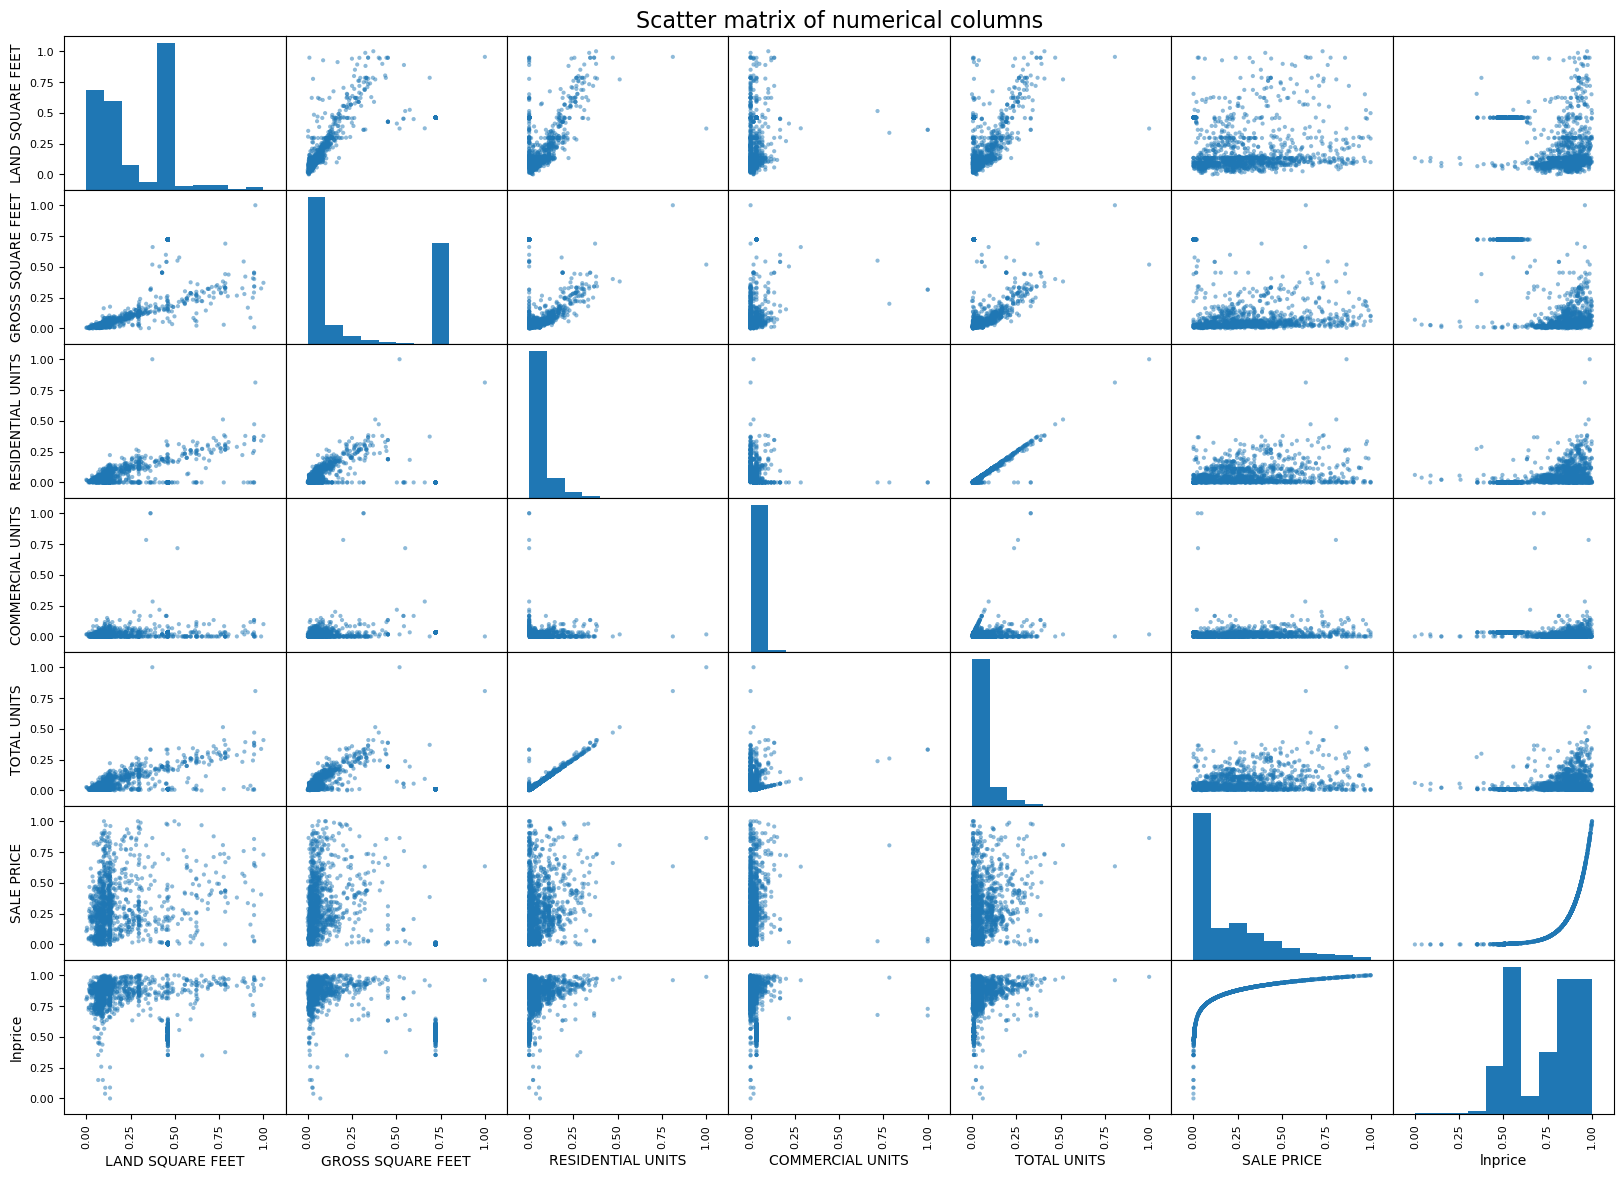

In [59]:
print(numericals)

scatter_m(normalised_df,numericals)

In [60]:
normalised_df[numericals].corr().style.background_gradient(cmap="spring")

In [61]:
cleanedDf_predictors = first_ranked_predictors(normalised_df, ['COMMERCIAL UNITS', 'TOTAL UNITS', 'RESIDENTIAL UNITS', 'TAX CLASS AT TIME OF SALE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'], 'lnprice')
print(cleanedDf_predictors)

['TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']


In [62]:
price_lm, price_testX, price_testY = data_split_train(normalised_df, ['TOTAL UNITS', 'RESIDENTIAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')
print("Mean Squared Error: {}".format(mean_squared_error(price_testY, price_lm.predict(price_testX))))

Y-axis intercept 0.8428
Weight coefficients:
          TOTAL UNITS: 0.9608
    RESIDENTIAL UNITS: -0.3694
    GROSS SQUARE FEET: -0.4520
R squared for the training data is 0.757
Score against test data: 0.712
Mean Squared Error: 0.009750576441443188


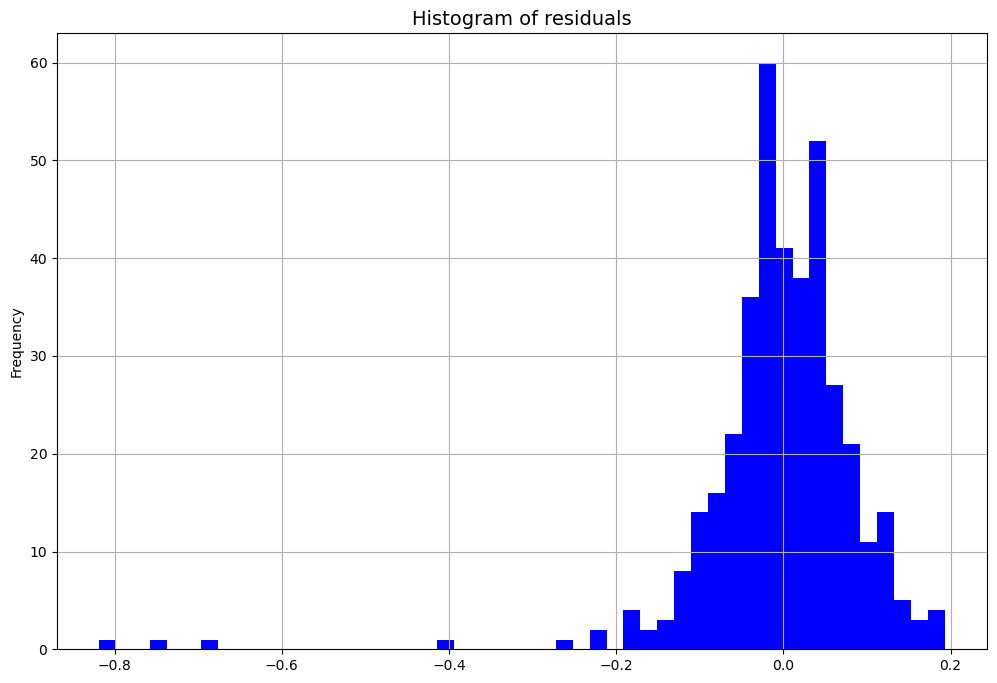

In [63]:
hist_res(price_lm, price_testX, price_testY)

In [64]:
cv(normalised_df, price_lm, ['TOTAL UNITS', 'RESIDENTIAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')

Cross validation scores: [0.74638695 0.81541887 0.81862369 0.7537332  0.60709425 0.82393486
 0.71461695 0.73549458 0.73217667 0.70754979]
Cross validation mean scores: 0.7455029820199706


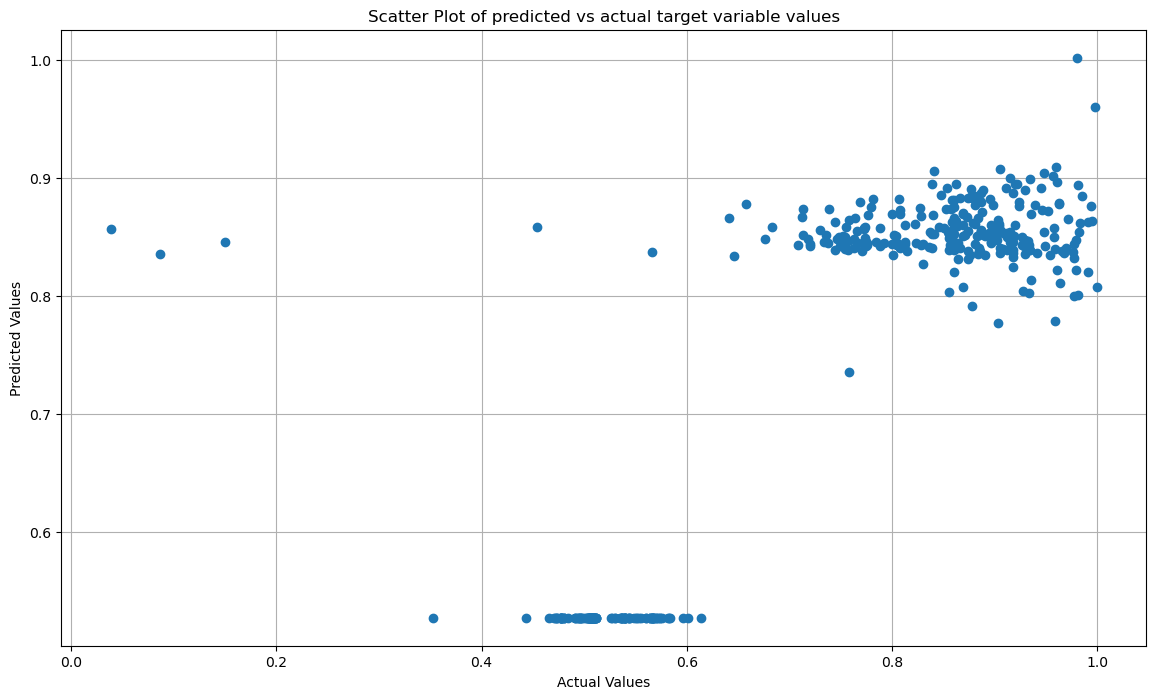

In [65]:
def pred_vs_actual(data, model, X, Y):
    
    pred_Y2=model.predict(X)
    plt.figure(figsize=(14,8))
    plt.plot(Y, pred_Y2,'o')
    plt.xlabel('Actual Values')
    plt.ylabel("Predicted Values")
    plt.title("Scatter Plot of predicted vs actual target variable values")
    plt.grid()
    plt.show()

    
pred_vs_actual(normalised_df, price_lm, price_testX, price_testY)  

# PART 2 upgrades

In [66]:
from sklearn.ensemble import RandomForestRegressor

def rf_train(df, predictor_features, outcome_feature):
    X = df[predictor_features]
    Y = df[outcome_feature]
    trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2) #, random_state=42)
    rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 5, random_state = 18).fit(trainX, trainY)
    print("R squared for the training data is {:4.3f}".format(rf.score(trainX, trainY)))
    print("Score against test data: {:4.3f}".format(rf.score(testX, testY)))
    return rf, testX, testY


In [67]:
first_ranked_predictors(normalised_df, ['COMMERCIAL UNITS', 'TOTAL UNITS', 'RESIDENTIAL UNITS', 'TAX CLASS AT TIME OF SALE', 'LAND SQUARE FEET', 'GROSS SQUARE FEET'], 'lnprice')

['TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET']

In [68]:
price_rf, price_testX, price_testY = rf_train(normalised_df, ['TOTAL UNITS', 'RESIDENTIAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')
print("Mean Squared Error: {}".format(mean_squared_error(price_testY, price_rf.predict(price_testX))))

R squared for the training data is 0.817
Score against test data: 0.832
Mean Squared Error: 0.00546947512805962


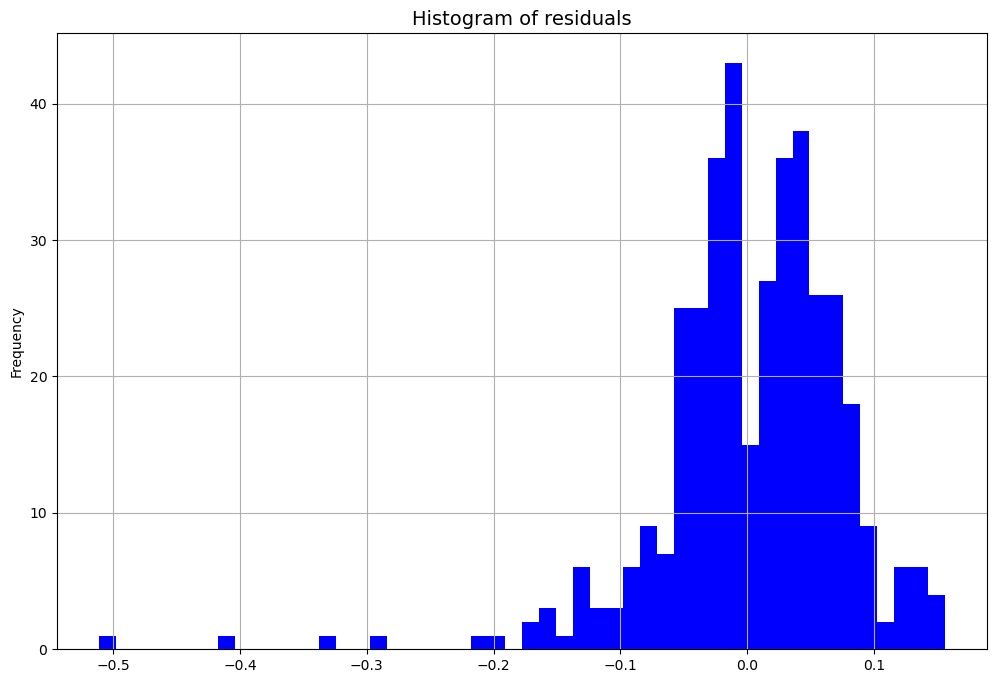

In [69]:
hist_res(price_rf, price_testX, price_testY)

In [70]:
cv(normalised_df, price_rf, ['TOTAL UNITS', 'RESIDENTIAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')

Cross validation scores: [0.70734788 0.78127651 0.88201913 0.76110173 0.8466552  0.88670055
 0.85795279 0.69154773 0.80136835 0.72889254]
Cross validation mean scores: 0.7944862421745207


In [71]:
gross_rf, gross_testX, gross_testY = rf_train(normalised_df, ['TOTAL UNITS', 'lnprice'], 'GROSS SQUARE FEET')
print("Mean Squared Error: {}".format(mean_squared_error(gross_testY, gross_rf.predict(gross_testX))))

R squared for the training data is 0.980
Score against test data: 0.962
Mean Squared Error: 0.003927438540735736


In [72]:
cv(normalised_df, gross_rf, ['TOTAL UNITS', 'lnprice'], 'GROSS SQUARE FEET')

Cross validation scores: [0.97594926 0.95992857 0.91306162 0.96721567 0.9833346  0.99174321
 0.95446861 0.98616174 0.951231   0.96199232]
Cross validation mean scores: 0.9645086585617426


In [73]:
land_rf, land_testX, land_testY = rf_train(normalised_df, ['TOTAL UNITS', 'lnprice', 'GROSS SQUARE FEET'], 'LAND SQUARE FEET')
print("Mean Squared Error: {}".format(mean_squared_error(land_testY, land_rf.predict(land_testX))))

R squared for the training data is 0.929
Score against test data: 0.874
Mean Squared Error: 0.00494848634796824


In [74]:
cv(normalised_df, land_rf, ['TOTAL UNITS', 'lnprice', 'GROSS SQUARE FEET'], 'LAND SQUARE FEET')

Cross validation scores: [0.9272172  0.90203891 0.88972575 0.92706318 0.93087521 0.83473876
 0.88689043 0.83599958 0.92161493 0.84246171]
Cross validation mean scores: 0.8898625660980253


In [75]:
valid_sp_df.isna().sum()

NEIGHBORHOOD                         17
BUILDING CLASS CATEGORY            1145
TAX CLASS AT PRESENT                116
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT           116
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  16616
GROSS SQUARE FEET                 16690
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64

In [76]:
valid_sp_df['lnprice'] = np.log(valid_sp_df['SALE PRICE'])

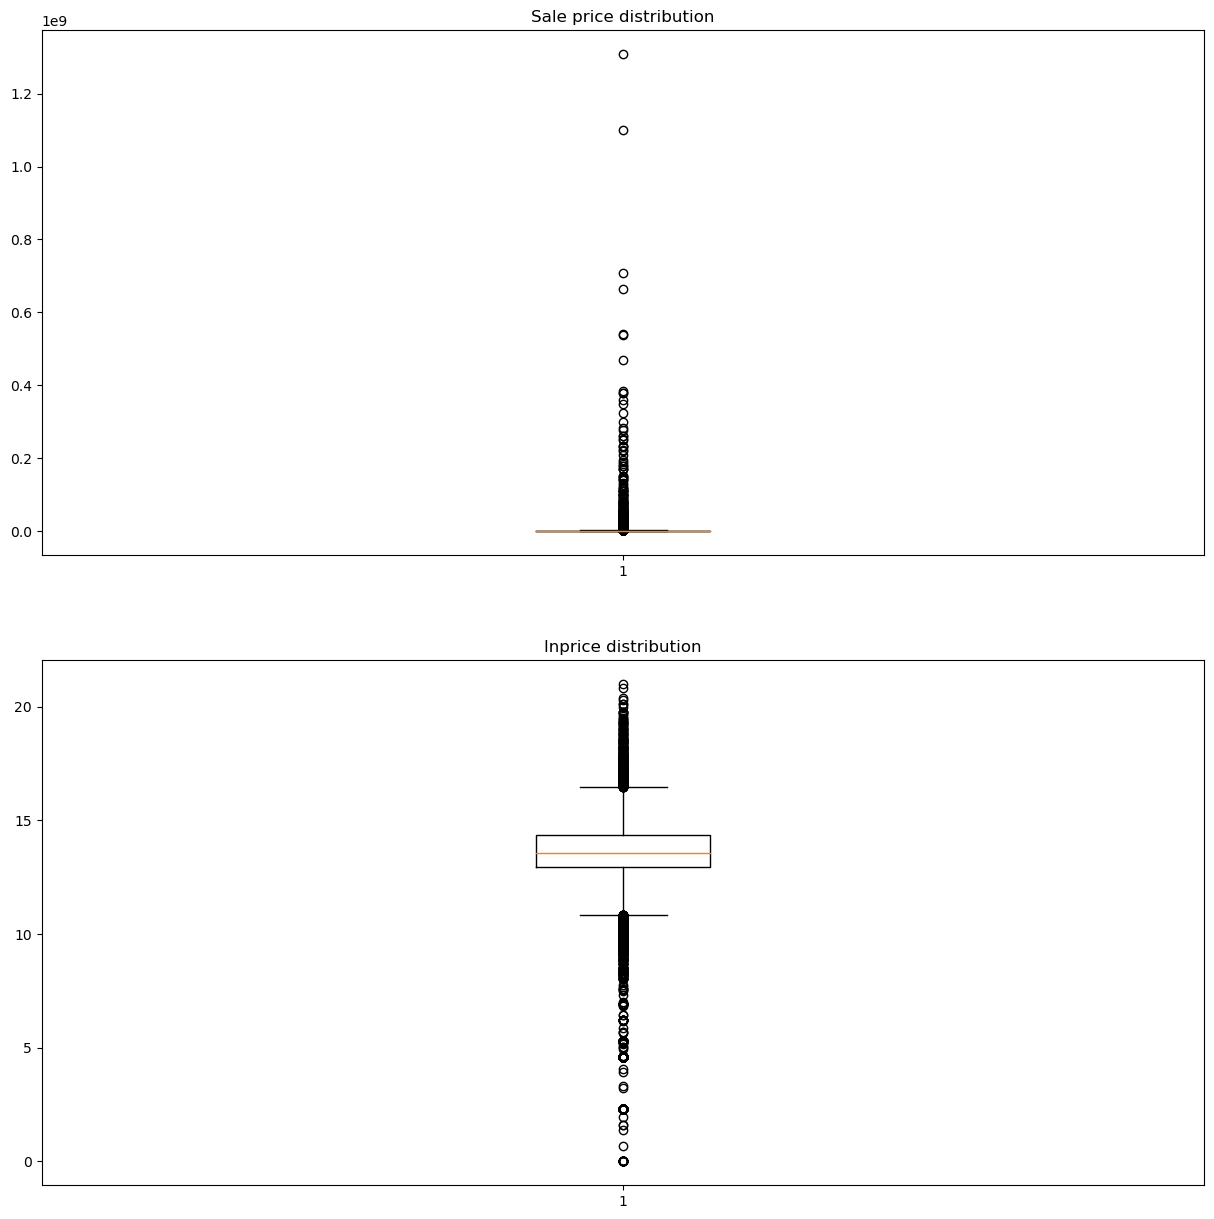

In [77]:
# Creating sub plots
fig, axs = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)

#Boxplots within each subplot space
axs[0].boxplot((valid_sp_df['SALE PRICE']))
axs[0].set_title("Sale price distribution")
axs[1].boxplot((valid_sp_df['lnprice']))
axs[1].set_title("lnprice distribution")


# show plot
plt.show()

In [78]:
no_outliers = identify_outlier(valid_sp_df, ["SALE PRICE", 'lnprice'])
print("number of outliers identified:", no_outliers['outlier'].sum())
no_outliers = no_outliers[no_outliers.outlier == 0]
no_outliers.drop('outlier', axis = 1, inplace = True)

missing_gross = pd.DataFrame(no_outliers[no_outliers['GROSS SQUARE FEET'].isna()])

missing_gross['RESIDENTIAL UNITS'] = missing_gross['RESIDENTIAL UNITS'].replace(to_replace = np.nan,  value = 0)
missing_gross['COMMERCIAL UNITS'] = missing_gross['COMMERCIAL UNITS'].replace(to_replace = np.nan,  value = 0)
missing_gross['TOTAL UNITS'] = missing_gross['TOTAL UNITS'].replace(to_replace = np.nan,  value = 0)

missing_gross = normalise(missing_gross, ["COMMERCIAL UNITS","GROSS SQUARE FEET","LAND SQUARE FEET","RESIDENTIAL UNITS","SALE PRICE", "TOTAL UNITS", "lnprice"])

missing_X = missing_gross[['TOTAL UNITS', 'lnprice']]

number of outliers identified: 3517.0
Normalising column: COMMERCIAL UNITS


/var/folders/pm/hch49fg94wx7ycdhtqxym5880000gn/T/ipykernel_36610/1822057308.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_outliers.drop('outlier', axis = 1, inplace = True)


Normalising column: GROSS SQUARE FEET
Normalising column: LAND SQUARE FEET
Normalising column: RESIDENTIAL UNITS
Normalising column: SALE PRICE
Normalising column: TOTAL UNITS
Normalising column: lnprice


In [79]:
missing_gross.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE       lnprice
count  14284.000000  14284.000000  14284.000000       14284.000000      14284.000000  14284.000000         42.000000                0.0  14284.000000               14284.000000  14284.000000  14284.000000
mean    1120.473887    699.994679  10031.176561           0.043460          0.007841      0.046696          0.159877                NaN   1689.605923                   2.059717      0.272964      0.644221
std      506.907608    864.676312     38.977630           0.054796          0.088204      0.055411          0.186205                NaN    666.133332                   0.343783      0.212554      0.172875
min       11.000000      1.000000  10001.000000           0.000000          0.000000      0.000000          0.000000                NaN      0.000000                   1.000000      0.000000      0.000000
25%      803.000000     26.000000  10013.000000           0.000000          0.000000      0.000000          0.065445                NaN   1914.000000                   2.000000      0.121580      0.529551
50%     1171.000000    410.500000  10022.000000           0.000000          0.000000      0.000000          0.105968                NaN   1939.000000                   2.000000      0.199910      0.636138
75%     1451.000000   1153.000000  10028.000000           0.111111          0.000000      0.111111          0.160937                NaN   1965.000000                   2.000000      0.364964      0.769845
max     2250.000000   9046.000000  10282.000000           1.000000          1.000000      1.000000          1.000000                NaN   2013.000000                   4.000000      1.000000      1.000000

In [80]:
pred_gross = gross_rf.predict(missing_X)
missing_gross['GROSS SQUARE FEET'] = pred_gross


In [81]:
missing_gross.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE       lnprice
count  14284.000000  14284.000000  14284.000000       14284.000000      14284.000000  14284.000000         42.000000       14284.000000  14284.000000               14284.000000  14284.000000  14284.000000
mean    1120.473887    699.994679  10031.176561           0.043460          0.007841      0.046696          0.159877           0.150233   1689.605923                   2.059717      0.272964      0.644221
std      506.907608    864.676312     38.977630           0.054796          0.088204      0.055411          0.186205           0.091963    666.133332                   0.343783      0.212554      0.172875
min       11.000000      1.000000  10001.000000           0.000000          0.000000      0.000000          0.000000           0.034207      0.000000                   1.000000      0.000000      0.000000
25%      803.000000     26.000000  10013.000000           0.000000          0.000000      0.000000          0.065445           0.067913   1914.000000                   2.000000      0.121580      0.529551
50%     1171.000000    410.500000  10022.000000           0.000000          0.000000      0.000000          0.105968           0.143362   1939.000000                   2.000000      0.199910      0.636138
75%     1451.000000   1153.000000  10028.000000           0.111111          0.000000      0.111111          0.160937           0.268148   1965.000000                   2.000000      0.364964      0.769845
max     2250.000000   9046.000000  10282.000000           1.000000          1.000000      1.000000          1.000000           0.474037   2013.000000                   4.000000      1.000000      1.000000

In [82]:
valid_gross = pd.DataFrame(no_outliers[no_outliers['GROSS SQUARE FEET'].notna()])

valid_gross['RESIDENTIAL UNITS'] = valid_gross['RESIDENTIAL UNITS'].replace(to_replace = np.nan,  value = 0)
valid_gross['COMMERCIAL UNITS'] = valid_gross['COMMERCIAL UNITS'].replace(to_replace = np.nan,  value = 0)
valid_gross['TOTAL UNITS'] = valid_gross['TOTAL UNITS'].replace(to_replace = np.nan,  value = 0)

valid_gross = normalise(valid_gross, ["COMMERCIAL UNITS","GROSS SQUARE FEET","LAND SQUARE FEET","RESIDENTIAL UNITS","SALE PRICE", "TOTAL UNITS", "lnprice"])

valid_gross.isna().sum()

Normalising column: COMMERCIAL UNITS
Normalising column: GROSS SQUARE FEET
Normalising column: LAND SQUARE FEET
Normalising column: RESIDENTIAL UNITS
Normalising column: SALE PRICE
Normalising column: TOTAL UNITS
Normalising column: lnprice


NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
lnprice                           0
dtype: int64

In [83]:
valid_gross.describe()

BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE   SALE PRICE      lnprice
count  1127.000000  1127.000000   1127.000000        1127.000000       1127.000000  1127.000000       1127.000000        1127.000000  1127.000000                1127.000000  1127.000000  1127.000000
mean   1304.400177    48.272405  10025.637090           0.015562          0.024460     0.019957          0.112575           0.179751  1959.566105                   3.004437     0.257811     0.452544
std     506.813239    69.362598     32.172804           0.044988          0.050169     0.044967          0.082457           0.158944    48.930777                   1.178922     0.320504     0.368357
min      64.000000     1.000000  10001.000000           0.000000          0.000000     0.000000          0.000000           0.000000  1890.000000                   1.000000     0.000000     0.000000
25%    1009.000000    37.000000  10019.000000           0.000000          0.000000     0.005988          0.034928           0.011592  1910.000000                   2.000000     0.008408     0.109578
50%    1009.000000    37.000000  10019.000000           0.000000          0.033333     0.005988          0.164137           0.249583  2007.000000                   4.000000     0.053641     0.367405
75%    1829.000000    38.500000  10029.000000           0.014970          0.033333     0.017964          0.164137           0.333342  2007.000000                   4.000000     0.461501     0.823023
max    2238.000000  1103.000000  10463.000000           1.000000          1.000000     1.000000          1.000000           1.000000  2013.000000                   4.000000     1.000000     1.000000

In [84]:
treated_gross = pd.concat([missing_gross,valid_gross])
treated_gross.isna().sum()

NEIGHBORHOOD                         15
BUILDING CLASS CATEGORY             242
TAX CLASS AT PRESENT                 96
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT            96
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  14242
GROSS SQUARE FEET                     0
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
lnprice                               0
dtype: int64

In [85]:
treated_gross.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE       lnprice
count  15411.000000  15411.000000  15411.000000       15411.000000      15411.000000  15411.000000       1169.000000       15411.000000  15411.000000               15411.000000  15411.000000  15411.000000
mean    1133.924340    652.334501  10030.771462           0.041420          0.009056      0.044740          0.114275           0.152392   1709.347998                   2.128804      0.271856      0.630203
std      509.141222    849.781303     38.546847           0.054622          0.086103      0.055155          0.088597           0.098710    645.287956                   0.521151      0.222253      0.200263
min       11.000000      1.000000  10001.000000           0.000000          0.000000      0.000000          0.000000           0.000000      0.000000                   1.000000      0.000000      0.000000
25%      838.000000     27.000000  10014.000000           0.000000          0.000000      0.000000          0.035579           0.067294   1913.000000                   2.000000      0.114586      0.517173
50%     1170.000000     69.000000  10022.000000           0.000000          0.000000      0.000000          0.164137           0.143858   1939.000000                   2.000000      0.197113      0.633061
75%     1459.000000   1133.000000  10028.000000           0.111111          0.000000      0.111111          0.164137           0.275141   1971.000000                   2.000000      0.370559      0.773272
max     2250.000000   9046.000000  10463.000000           1.000000          1.000000      1.000000          1.000000           1.000000   2013.000000                   4.000000      1.000000      1.000000

In [86]:
missing_land = pd.DataFrame(treated_gross[treated_gross['LAND SQUARE FEET'].isna()])

In [87]:
missing_land.isna().sum()

NEIGHBORHOOD                         15
BUILDING CLASS CATEGORY             242
TAX CLASS AT PRESENT                 96
BLOCK                                 0
LOT                                   0
BUILDING CLASS AT PRESENT            96
ADDRESS                               0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  14242
GROSS SQUARE FEET                     0
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
lnprice                               0
dtype: int64

In [88]:
missing_land.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE       lnprice
count  14242.000000  14242.000000  14242.000000       14242.000000      14242.000000  14242.000000               0.0       14242.000000  14242.000000               14242.000000  14242.000000  14242.000000
mean    1118.779174    701.854374  10031.176801           0.043518          0.007794      0.046755               NaN           0.150250   1694.454501                   2.053995      0.272854      0.644195
std      505.807144    865.246901     39.023579           0.054238          0.087941      0.054856               NaN           0.091886    660.905786                   0.327719      0.212366      0.172779
min       11.000000      1.000000  10001.000000           0.000000          0.000000      0.000000               NaN           0.034207      0.000000                   1.000000      0.000000      0.000000
25%      802.000000     26.000000  10013.000000           0.000000          0.000000      0.000000               NaN           0.067923   1915.000000                   2.000000      0.121580      0.529551
50%     1171.000000    489.000000  10022.000000           0.000000          0.000000      0.000000               NaN           0.143362   1939.000000                   2.000000      0.199910      0.636138
75%     1450.000000   1154.000000  10028.000000           0.111111          0.000000      0.111111               NaN           0.267582   1965.000000                   2.000000      0.364790      0.769738
max     2250.000000   9046.000000  10282.000000           0.111111          1.000000      0.111111               NaN           0.288882   2013.000000                   4.000000      1.000000      1.000000

In [89]:
missing_land_X = missing_land[['TOTAL UNITS', 'lnprice', 'GROSS SQUARE FEET']]
pred_land = land_rf.predict(missing_land_X)
missing_land['LAND SQUARE FEET'] = pred_land

In [90]:
missing_land.isna().sum()

NEIGHBORHOOD                       15
BUILDING CLASS CATEGORY           242
TAX CLASS AT PRESENT               96
BLOCK                               0
LOT                                 0
BUILDING CLASS AT PRESENT          96
ADDRESS                             0
ZIP CODE                            0
RESIDENTIAL UNITS                   0
COMMERCIAL UNITS                    0
TOTAL UNITS                         0
LAND SQUARE FEET                    0
GROSS SQUARE FEET                   0
YEAR BUILT                          0
TAX CLASS AT TIME OF SALE           0
BUILDING CLASS AT TIME OF SALE      0
SALE PRICE                          0
SALE DATE                           0
lnprice                             0
dtype: int64

In [91]:
missing_land.describe()

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE       lnprice
count  14242.000000  14242.000000  14242.000000       14242.000000      14242.000000  14242.000000      14242.000000       14242.000000  14242.000000               14242.000000  14242.000000  14242.000000
mean    1118.779174    701.854374  10031.176801           0.043518          0.007794      0.046755          0.296109           0.150250   1694.454501                   2.053995      0.272854      0.644195
std      505.807144    865.246901     39.023579           0.054238          0.087941      0.054856          0.132427           0.091886    660.905786                   0.327719      0.212366      0.172779
min       11.000000      1.000000  10001.000000           0.000000          0.000000      0.000000          0.121535           0.034207      0.000000                   1.000000      0.000000      0.000000
25%      802.000000     26.000000  10013.000000           0.000000          0.000000      0.000000          0.167030           0.067923   1915.000000                   2.000000      0.121580      0.529551
50%     1171.000000    489.000000  10022.000000           0.000000          0.000000      0.000000          0.303538           0.143362   1939.000000                   2.000000      0.199910      0.636138
75%     1450.000000   1154.000000  10028.000000           0.111111          0.000000      0.111111          0.440302           0.267582   1965.000000                   2.000000      0.364790      0.769738
max     2250.000000   9046.000000  10282.000000           0.111111          1.000000      0.111111          0.465005           0.288882   2013.000000                   4.000000      1.000000      1.000000

In [92]:
valid_land = treated_gross[treated_gross['LAND SQUARE FEET'].notna()]

In [93]:
valid_land.describe()

BLOCK          LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET   YEAR BUILT  TAX CLASS AT TIME OF SALE   SALE PRICE      lnprice
count  1169.000000  1169.000000   1169.000000        1169.000000       1169.000000  1169.000000       1169.000000        1169.000000  1169.000000                1169.000000  1169.000000  1169.000000
mean   1318.438837    49.030796  10025.833191           0.015859          0.024437     0.020190          0.114275           0.178487  1890.796407                   3.040205     0.259700     0.459739
std     513.647692    71.845075     31.777863           0.052814          0.057116     0.052842          0.088597           0.157715   363.823992                   1.172279     0.318857     0.365621
min      64.000000     1.000000  10001.000000           0.000000          0.000000     0.000000          0.000000           0.000000     0.000000                   1.000000     0.000000     0.000000
25%    1009.000000    37.000000  10019.000000           0.000000          0.000000     0.005988          0.035579           0.011972  1910.000000                   2.000000     0.008700     0.112597
50%    1009.000000    37.000000  10019.000000           0.000000          0.033333     0.005988          0.164137           0.209183  1941.000000                   4.000000     0.083814     0.453254
75%    1843.000000    40.000000  10029.000000           0.011976          0.033333     0.014970          0.164137           0.333342  2007.000000                   4.000000     0.461501     0.823023
max    2238.000000  1103.000000  10463.000000           1.000000          1.000000     1.000000          1.000000           1.000000  2013.000000                   4.000000     1.000000     1.000000

In [94]:
treated_land = pd.concat([missing_land,valid_land])
treated_land.isna().sum()

NEIGHBORHOOD                       15
BUILDING CLASS CATEGORY           242
TAX CLASS AT PRESENT               96
BLOCK                               0
LOT                                 0
BUILDING CLASS AT PRESENT          96
ADDRESS                             0
ZIP CODE                            0
RESIDENTIAL UNITS                   0
COMMERCIAL UNITS                    0
TOTAL UNITS                         0
LAND SQUARE FEET                    0
GROSS SQUARE FEET                   0
YEAR BUILT                          0
TAX CLASS AT TIME OF SALE           0
BUILDING CLASS AT TIME OF SALE      0
SALE PRICE                          0
SALE DATE                           0
lnprice                             0
dtype: int64

In [95]:
treated_data = treated_land
treated_data.shape

(15411, 19)

In [96]:
imputed_stats = treated_data.describe()
imputed_stats

BLOCK           LOT      ZIP CODE  RESIDENTIAL UNITS  COMMERCIAL UNITS   TOTAL UNITS  LAND SQUARE FEET  GROSS SQUARE FEET    YEAR BUILT  TAX CLASS AT TIME OF SALE    SALE PRICE       lnprice
count  15411.000000  15411.000000  15411.000000       15411.000000      15411.000000  15411.000000      15411.000000       15411.000000  15411.000000               15411.000000  15411.000000  15411.000000
mean    1133.924340    652.334501  10030.771462           0.041420          0.009056      0.044740          0.282316           0.152392   1709.347998                   2.128804      0.271856      0.630203
std      509.141222    849.781303     38.546847           0.054622          0.086103      0.055155          0.138273           0.098710    645.287956                   0.521151      0.222253      0.200263
min       11.000000      1.000000  10001.000000           0.000000          0.000000      0.000000          0.000000           0.000000      0.000000                   1.000000      0.000000      0.000000
25%      838.000000     27.000000  10014.000000           0.000000          0.000000      0.000000          0.163338           0.067294   1913.000000                   2.000000      0.114586      0.517173
50%     1170.000000     69.000000  10022.000000           0.000000          0.000000      0.000000          0.249837           0.143858   1939.000000                   2.000000      0.197113      0.633061
75%     1459.000000   1133.000000  10028.000000           0.111111          0.000000      0.111111          0.433077           0.275141   1971.000000                   2.000000      0.370559      0.773272
max     2250.000000   9046.000000  10463.000000           1.000000          1.000000      1.000000          1.000000           1.000000   2013.000000                   4.000000      1.000000      1.000000

Histograms of GSQF AND LSQF against different price ranges


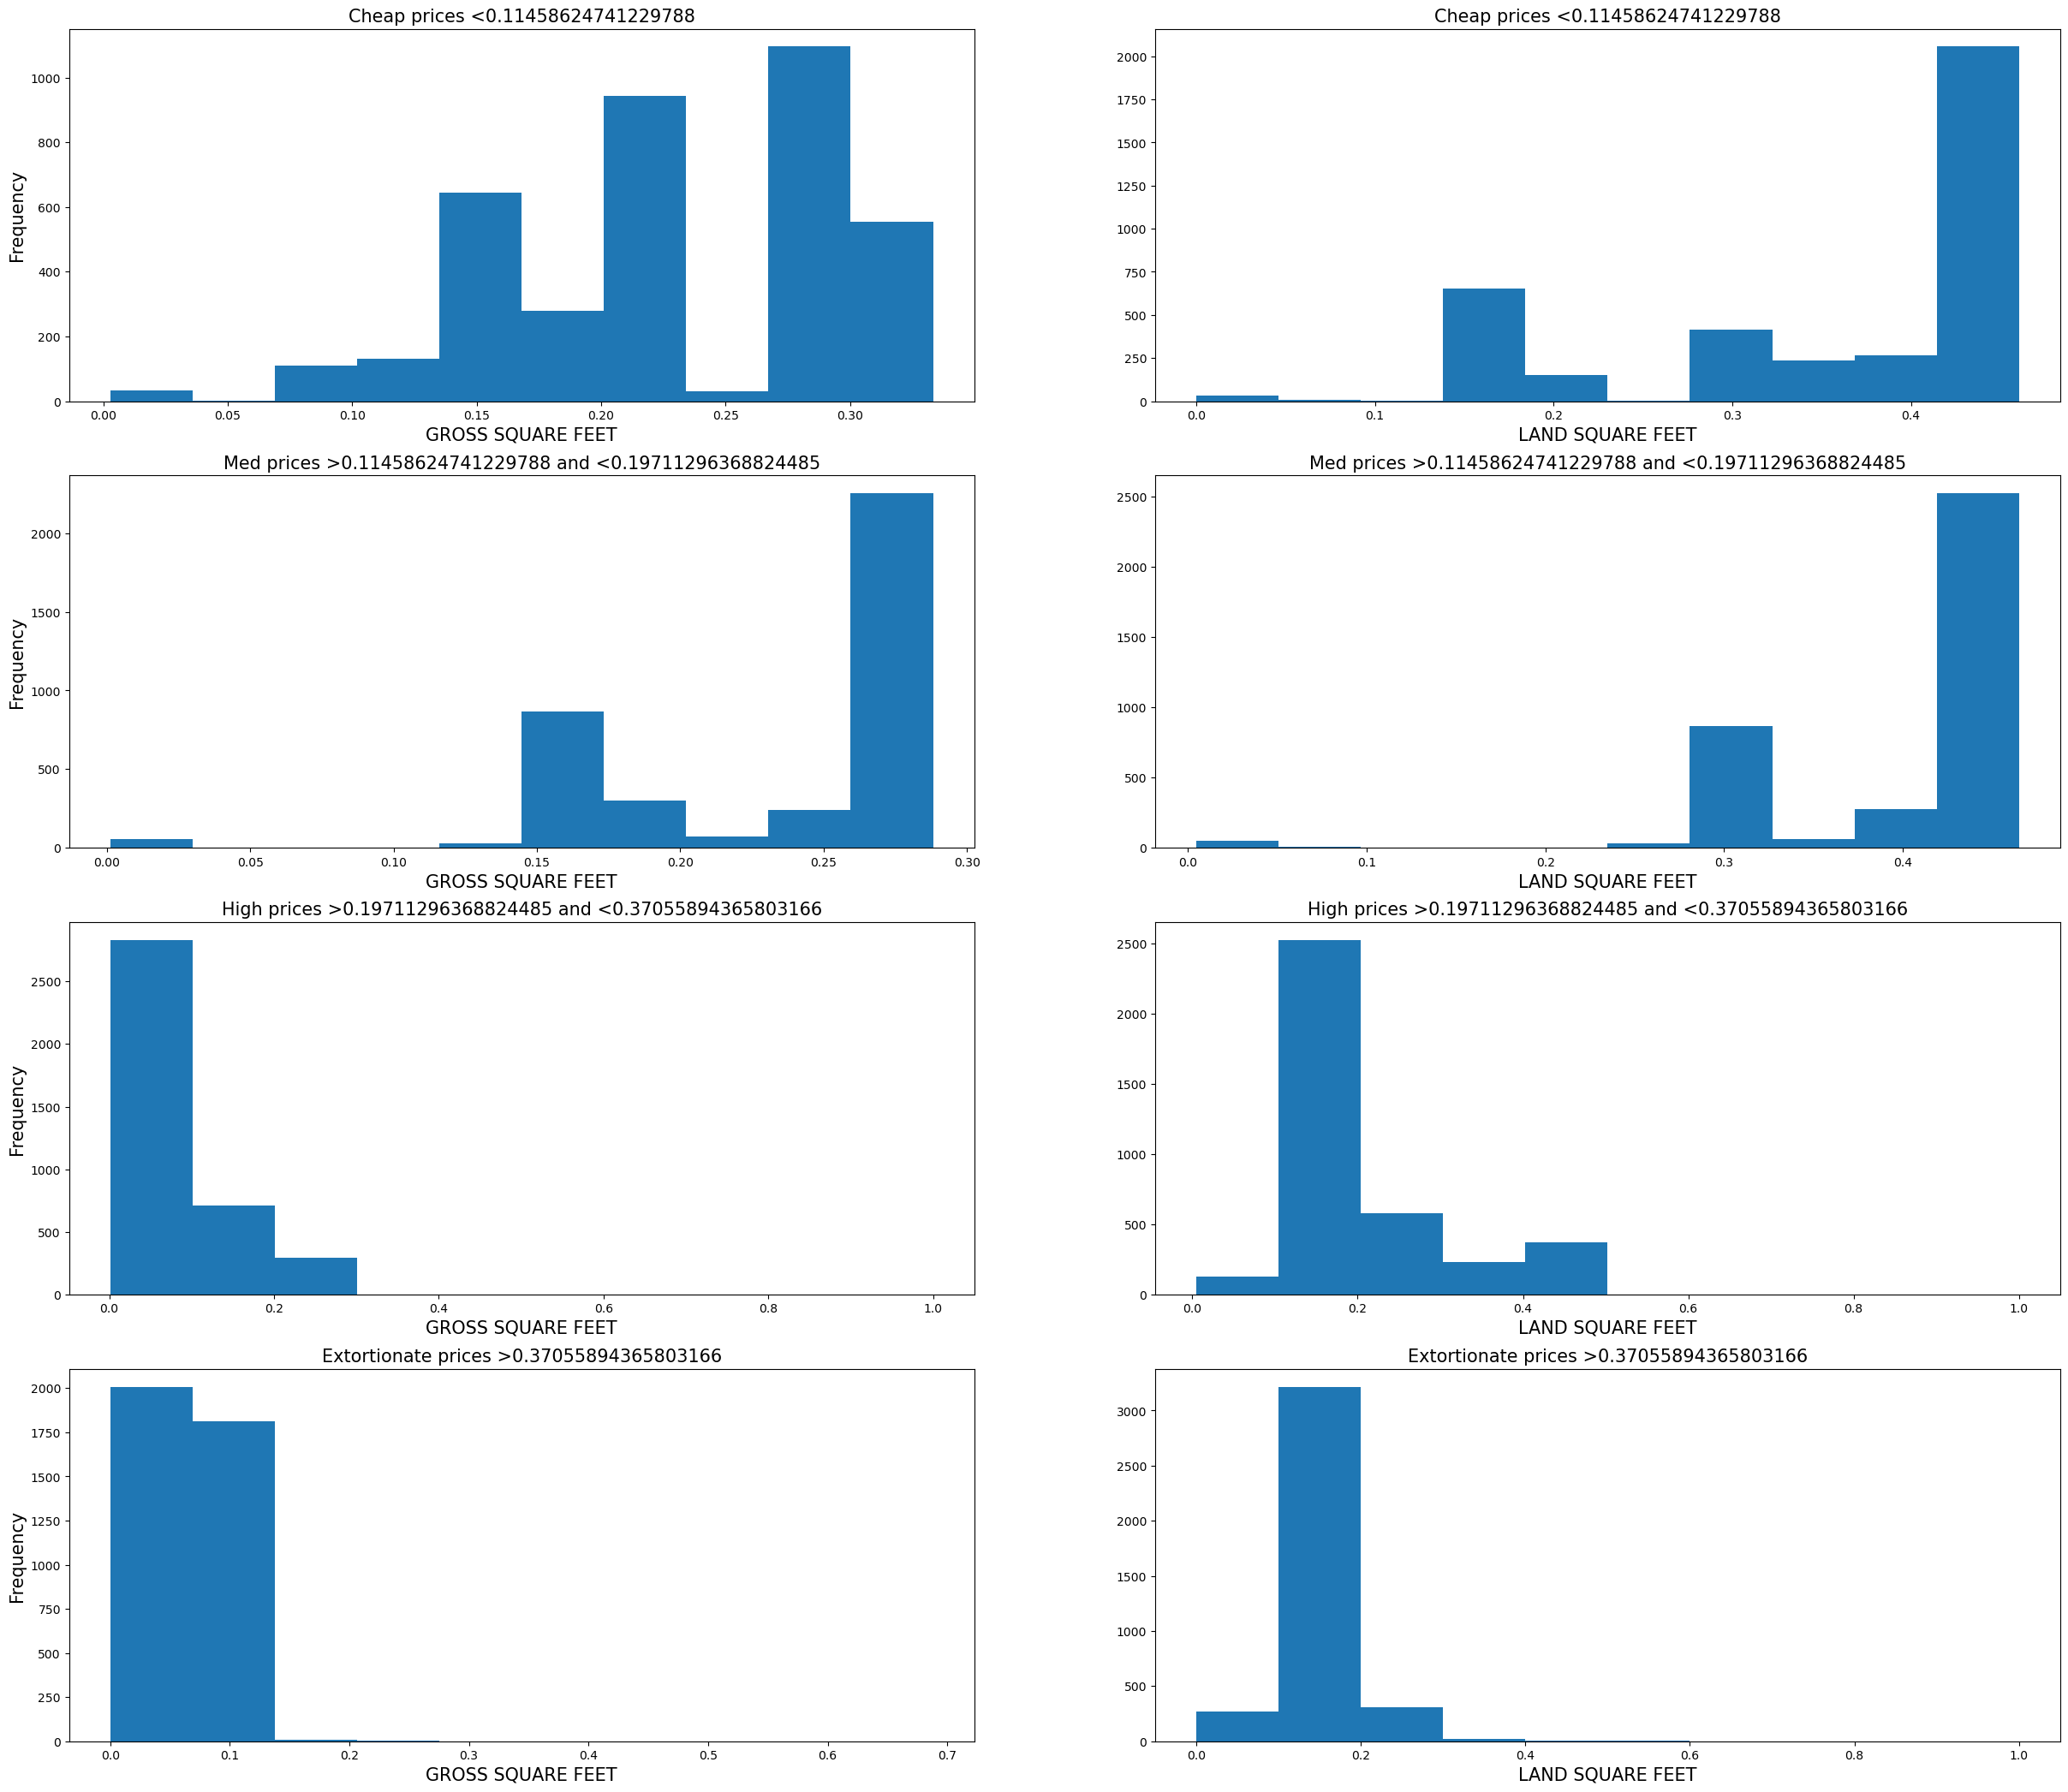

In [97]:
land_gross_sp_distribution(treated_data, imputed_stats)

In [98]:
treated_corr = treated_data[numericals].corr().style.background_gradient(cmap="spring")
treated_corr

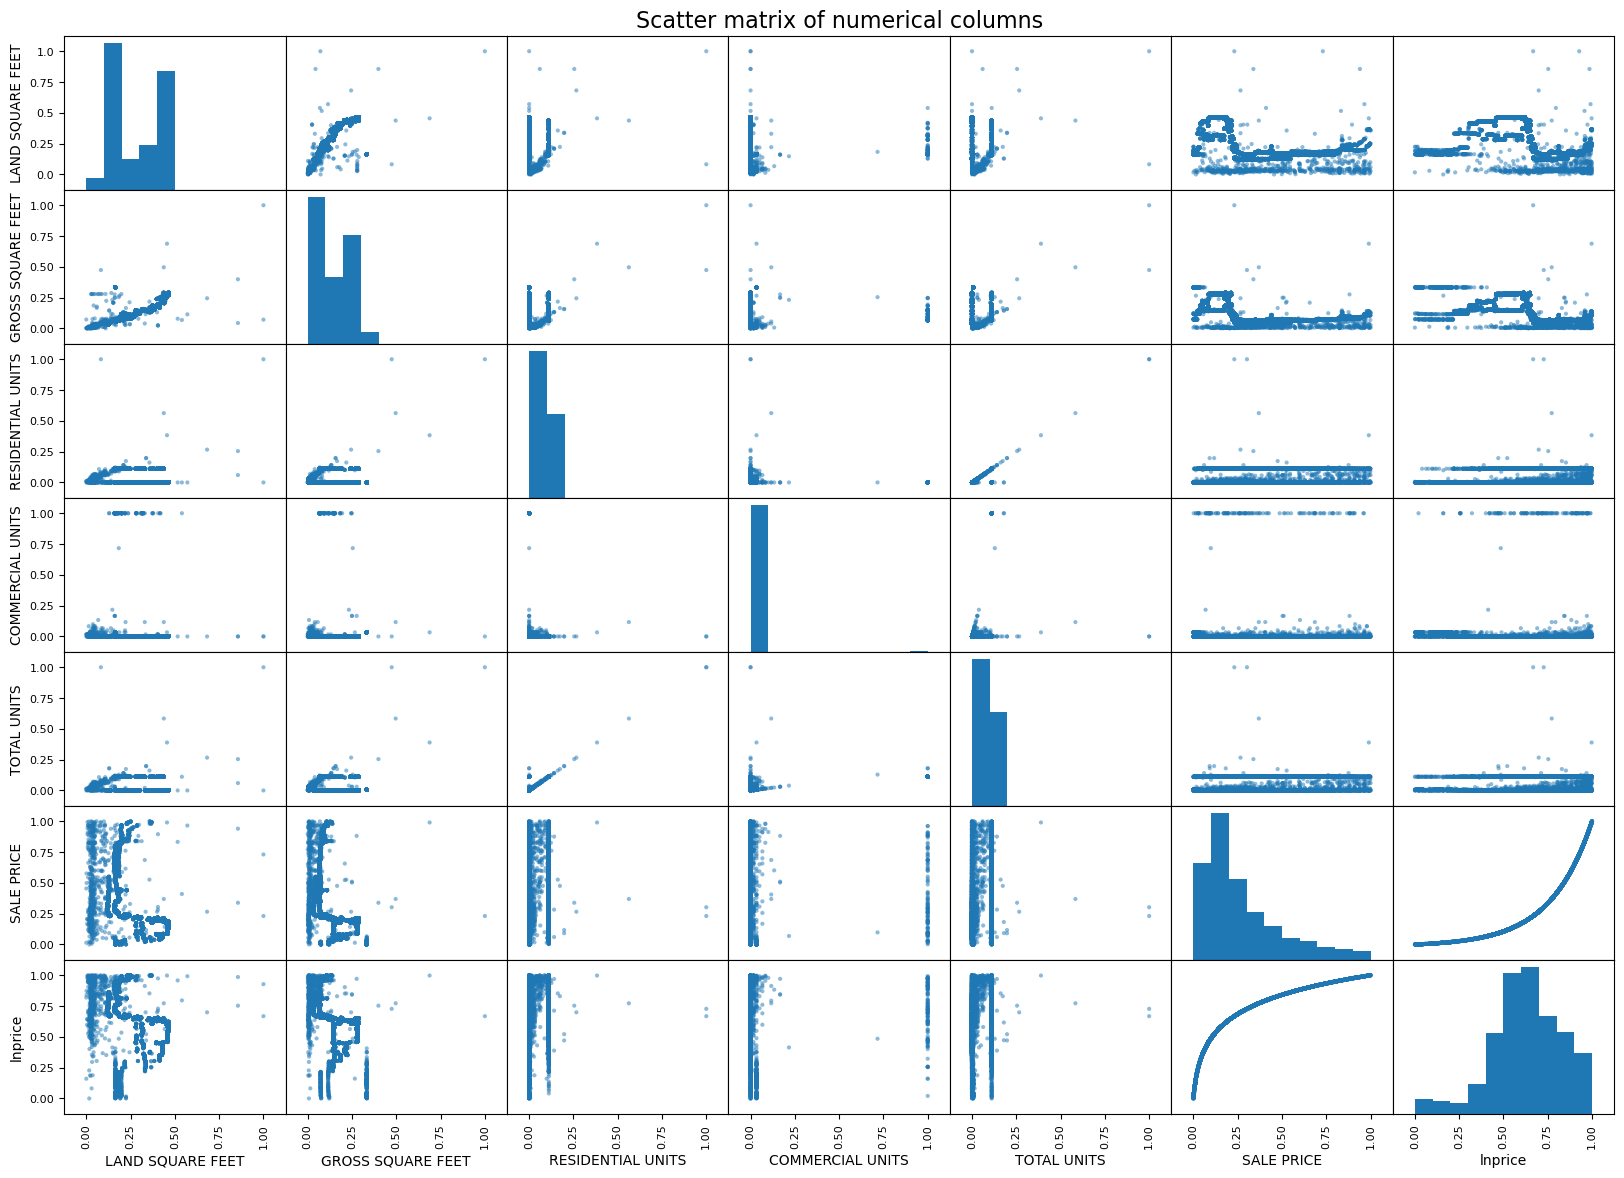

In [99]:
scatter_m(treated_data,numericals)

R squared for the training data is 0.831
Score against test data: 0.838


Text(0.5, 0, 'Feature Importance')

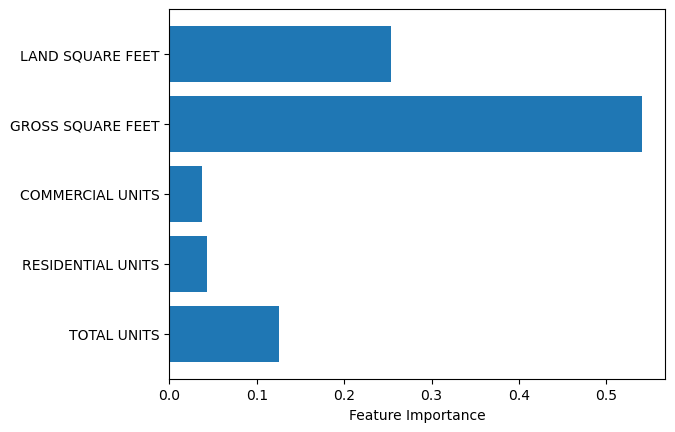

In [100]:
feat_select_rf, feat_select_testX, feat_select_testY = rf_train(treated_data, ['COMMERCIAL UNITS', 'RESIDENTIAL UNITS', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'LAND SQUARE FEET'], 'lnprice')

potential_predictors = ['TOTAL UNITS', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'GROSS SQUARE FEET', 'LAND SQUARE FEET']
plt.barh(potential_predictors, feat_select_rf.feature_importances_)
plt.xlabel("Feature Importance")

In [101]:
treated_rf, treated_testX, treated_testY = rf_train(treated_data, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')
print("Mean Squared Error: {}".format(mean_squared_error(treated_testY, treated_rf.predict(treated_testX))))

R squared for the training data is 0.835
Score against test data: 0.846
Mean Squared Error: 0.006327825170052144


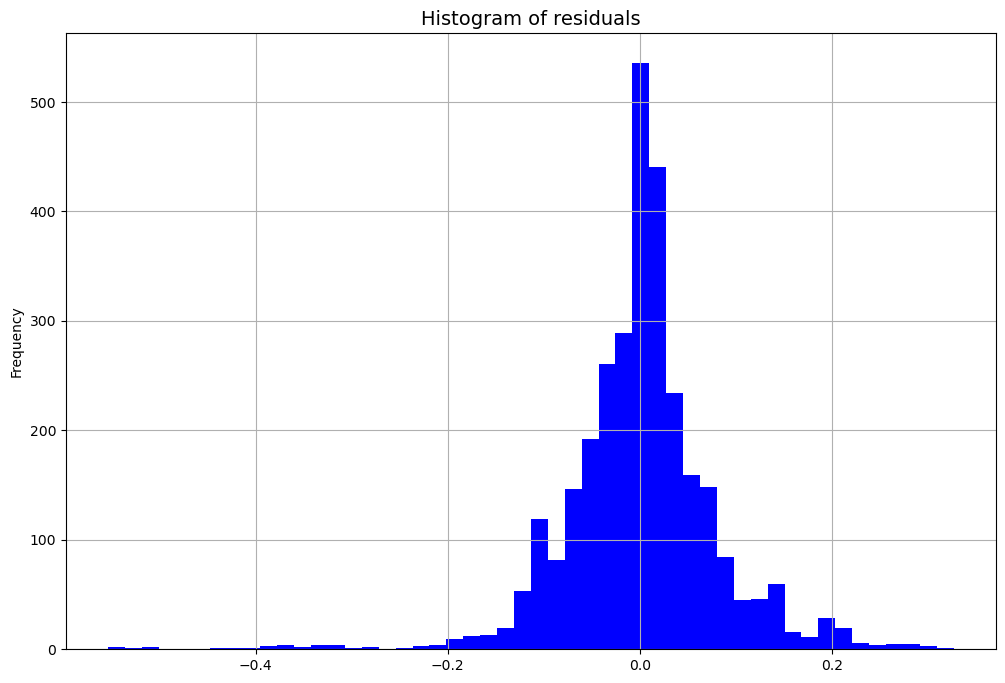

In [102]:
hist_res(treated_rf, treated_testX, treated_testY)

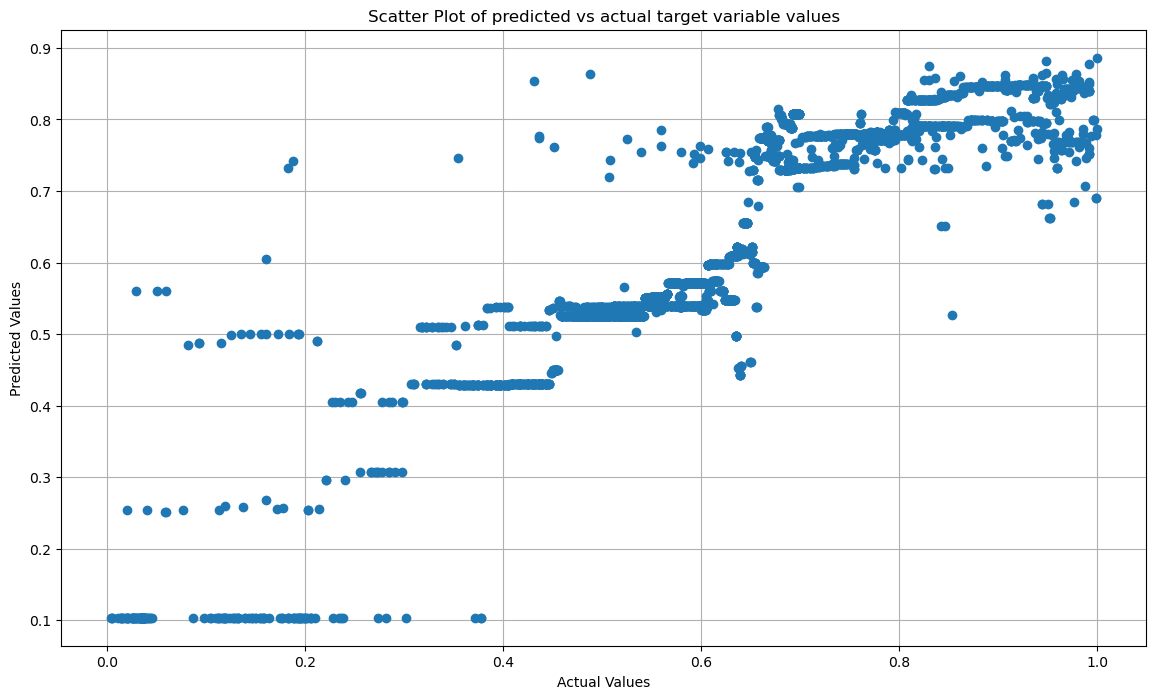

In [103]:
pred_vs_actual(treated_data, treated_rf, treated_testX, treated_testY)  

In [104]:
cv(treated_data, treated_rf, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET'], 'lnprice')

Cross validation scores: [0.83372432 0.82643448 0.82226563 0.83766177 0.84685151 0.82984385
 0.82951791 0.8404598  0.8346377  0.81586808]
Cross validation mean scores: 0.8317265043011688


# K-Means Clustering

2 431.1841988396802
4 205.16154316510261
6 123.38436333677637
8 95.75080394587701
10 77.90271928627922
12 64.60293100116525
14 53.99428172023776


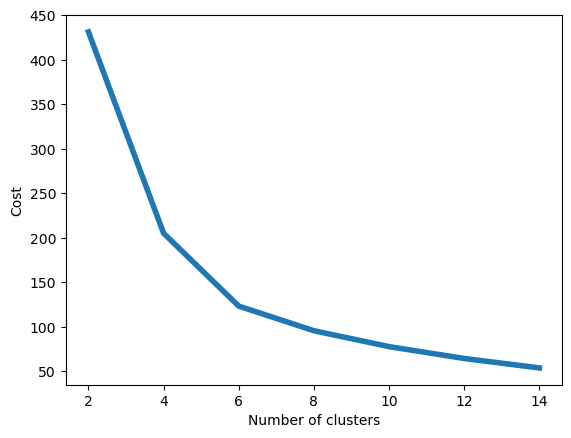

In [105]:
def elbow(data):
    sse = {}
    for k in range(2, 15, 2):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
        print(k, kmeans.inertia_)
        sse[k] = kmeans.inertia_  
        # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()), linewidth=4)
    plt.xlabel("Number of clusters")
    plt.ylabel("Cost")
    plt.show()
elbow(treated_data[['LAND SQUARE FEET', 'GROSS SQUARE FEET','lnprice','TOTAL UNITS']])

Text(0.5, 1.0, 'Regression line slope is -0.6608177705327816 and y-intercept is 0.8167630550128514')

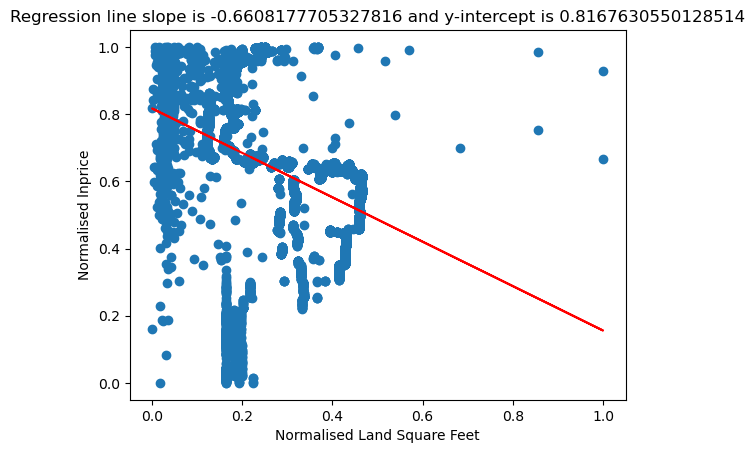

In [106]:


# Regression line
slope, intercept, r_value, p_value, std_err = linregress(treated_data['LAND SQUARE FEET'], treated_data['lnprice'])

def regression_y(x):
    return slope * x + intercept

plt.scatter(treated_data['LAND SQUARE FEET'], treated_data['lnprice'])
plt.plot(treated_data['LAND SQUARE FEET'], regression_y(treated_data['LAND SQUARE FEET']), 'r')
plt.xlabel('Normalised Land Square Feet')
plt.ylabel('Normalised lnprice')
plt.title("Regression line slope is {} and y-intercept is {}".format(slope, intercept))

In [ ]:
treat_copy = treated_data[numericals].copy()

X = treated_data[['LAND SQUARE FEET', 'GROSS SQUARE FEET']]

Y = treated_data['lnprice']

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

###fit the whole df so we get true testY vals aswell
model_whole = KMeans(n_clusters=4).fit(treated_data[numericals])
labels = model_whole.predict(treated_data[numericals])
print(model_whole.cluster_centers_)

treated_data['clust'] = labels

df1 = treated_data[treated_data.clust==0]
df2 = treated_data[treated_data.clust==1]
df3 = treated_data[treated_data.clust==2]
df4 = treated_data[treated_data.clust==3]
#df5 = treated_data[treated_data.clust==4]


plt.scatter(df1['LAND SQUARE FEET'], df1['lnprice'], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(df2['LAND SQUARE FEET'], df2['lnprice'], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(df3['LAND SQUARE FEET'], df3['lnprice'], s = 100,  c = 'green', label = 'Cluster 3')
plt.scatter(df4['LAND SQUARE FEET'], df4['lnprice'], s = 100,  c = 'black', label = 'Cluster 4')
plt.xlabel("lsqf")
plt.ylabel("lnprice")
plt.legend()

final_rf, final_rf_testX, final_rf_testY = rf_train(treated_data, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'clust'], 'lnprice')
cv(treated_data, final_rf, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'clust'], 'lnprice')



[[0.19393021 0.2402409  0.00970945 0.03084192 0.0248527  0.01637691
  0.15463425]
 [0.15563654 0.0580541  0.05228361 0.00733874 0.05449459 0.33078535
  0.73983659]
 [0.16842419 0.06964363 0.0644524  0.01874812 0.06844967 0.71657624
  0.91927779]
 [0.41452164 0.22976244 0.0312738  0.0043702  0.03356637 0.13061084
  0.53128672]]
R squared for the training data is 0.933
Score against test data: 0.935


In [ ]:
pred_vs_actual(treated_data, final_rf, final_rf_testX, final_rf_testY)  

In [ ]:
## histogram of the clusters

cluster_count = treated_data['clust'].value_counts().sort_values()
print(cluster_count)
plt.hist(treated_data['clust'])
plt.title('Histogram of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [ ]:
pca_data = PCA(n_components=2).fit_transform(treat_copy)
mod = KMeans(n_clusters=4).fit(pca_data)
labels = mod.predict(pca_data)
print(mod.cluster_centers_)
ndf = pd.DataFrame(pca_data)
ndf['clust'] = labels
print(ndf)

ndfg = ndf.groupby('clust')
for n, gdf in ndfg:
    plt.scatter(gdf[0], gdf[1], label=n)
#plt.scatter(pca_2d[:,0], pca_2d[:,1])
plt.title('house clusters')
plt.legend()
plt.show()

print("silhouette coeff",silhouette_score(pca_data, labels))

treated_data['clust2'] = labels

print("\nwith just clust2")
final_rf_c2, final_rf_c2_testX, final_rf_c2_testY = rf_train(treated_data, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'clust2'], 'lnprice')
cv(treated_data, final_rf_c2, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'clust'], 'lnprice')
print("\nwith both clust1 and clust 2...")
final_rf_c1_c2, final_rf_c1_c2_testX, final_rf_c1_c2_testY = rf_train(treated_data, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'clust','clust2'], 'lnprice')
cv(treated_data, final_rf_c1_c2, ['LAND SQUARE FEET', 'TOTAL UNITS', 'GROSS SQUARE FEET', 'clust','clust2'], 'lnprice')


print("\nfor each cluster.......\n")
test_acc = []
clusters_mse = []
MSE=[]
for i in range(4):
    print("Cluster: {} of size {}".format(i, treated_data[(treated_data['clust']==i)|(treated_data['clust2']==i)].shape[0]))
    rfi, rfi_testX, rfi_testY = rf_train(treated_data.loc[(treated_data['clust']==i) | (treated_data['clust2']==i)], ['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'clust2', 'clust'], 'lnprice')
    test_acc.append(rfi.score(rfi_testX, rfi_testY))
    clusters_mse.append(mean_squared_error(rfi_testY, rfi.predict(rfi_testX)))
    MSE.append(["cluster "+str(i), mean_squared_error(treated_data.loc[(treated_data['clust']==i) | (treated_data['clust2']==i), 'lnprice'], rfi.predict(treated_data[['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'clust2', 'clust']].loc[(treated_data['clust']==i) | (treated_data['clust2']==i)]))])
    print("\n ")
    hist_res(rfi, rfi_testX, rfi_testY)

print("Cluster mean test accuracy: {} \nCluster mean MSE: {}".format(sum(test_acc)/len(test_acc), sum(clusters_mse)/len(clusters_mse)))
dfMSE = pd.DataFrame(MSE, columns=["cluster", "MSE"])
plt.plot(dfMSE["cluster"], dfMSE["MSE"])
plt.title('MSE for each cluster')
plt.xlabel('Cluster')
plt.ylabel('MSE')
plt.grid()
plt.show()

plt.hist(treated_data['clust2'])
plt.title('Histogram of Clusters using PCA 2d df')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [ ]:
pred_vs_actual(treated_data, final_rf_c2, final_rf_c2_testX, final_rf_c2_testY)  

In [ ]:
pred_vs_actual(treated_data, final_rf_c1_c2, final_rf_c1_c2_testX, final_rf_c1_c2_testY)  

In [ ]:
p = pd.concat([treated_data['clust'], treated_data['clust2']])
plt.hist(p)
plt.title('Histogram of Clusters using cluster 1  OR cluster 2 values')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.grid()
plt.show()